***
***

<img width="220" align="right" alt="Screen Shot 2020-10-14 at 20 48 36" src="https://user-images.githubusercontent.com/8030363/96350526-7d09a680-1073-11eb-9e45-a510c496bcc1.png">


# OMOP2OBO

### *Ontologizing Health Systems Data at Scale: Making Translational Discovery a Reality*

<br>

**Author:** [TJCallahan](https://mail.google.com/mail/u/0/?view=cm&fs=1&tf=1&to=callahantiff@gmail.com)  
**GitHub Repository:** [OMOP2OBO](https://github.com/callahantiff/OMOP2OBO/wiki) ([`V1.0`](https://github.com/callahantiff/OMOP2OBO/wiki/v1.0))  
**Analysis Dates:** `10/16/2020`

<br>

***
***

### Notebook Objective   
The purpose of this notebook is to present the results for the preliminary manuscript describing the `OMOP2OBO` algorithm and mappings. For this analysis, each clinical concepts from several domains (i.e. Conditions, Drug Ingredients, and Measurements) will separately analyzed with respect to the specific Open Biomedical Ontologies (OBO) it was mapped to. The analysis is presented in the order of the mapping algorithm workflow, which is shown below. Additional information on each of the steps shown in this figure, with respect to the analyses performed in this notebook, are provided below.

**This notebook presents results from validating the `OMOP2OBO` mappings.**

<img width="2000" alt="Screen Shot 2020-09-20 at 22 59 00" src="https://user-images.githubusercontent.com/8030363/96931469-99924e00-147a-11eb-9c19-fe5a95786772.png">


**Jupyter Notebooks:** [`omop2obo_manuscript_analyses.ipynb`](https://github.com/callahantiff/OMOP2OBO/tree/master/resources/analyses/omop2obo_manuscript_analyses.ipynb) 

- **Step 1: Concept Alignment:** This section describes the results generated from performing exact alignment between `OMOP` concept source codes and ontology concept database cross-references (i.e. dbXRefs) as well as `OMOP` concept labels and synonyms to ontology concept labels and synonyms. Done for `Concepts used in Practice` and `Standard Concepts not used in Practice` and for data at the concept- and ancestor-level. 


- **Step 2: Concept Embedding:** This section describes the results from creating embeddings using a Bag-of-Words + TF-IDF vector space model. This model was created using `OMOP` concept labels and synonyms and ontology concept labels and synonyms. To retrieve mappings from this model, a cosine similarity score was calculated between all clinical and ontology concepts. Only those mappings that were greater than a cut-off threshold (<u>></u>`0.25` for drug ingredients and medications and <u>></u>`0.20` for conditions) and within the top 75% of the distribution of scores were kept. This is performed for `Concepts used in Practice` and `Standard Concepts not used in Practice` and for data at the concept-level.


- **Step 3: Manual Annotation:** This section describes the results obtained from manual annotation. Performed only on `Concepts used in Practice` at the concept-level.


- **Step 4: Final Mapping:** The final set of mappings will be presented. This will include descriptions of mappings by mapping category as well as what level (i.e. concept, ancestor) mappings were created.

<br> 

**Jupyter Notebooks:** Current Notebook   

- **Validation:** This section describes results from three different types of validation designed to assess the accuracy, generalizability, and consistency of the final mapping set.


***
## Table of Contents <a class="anchor" id="toc"></a>
***

This notebook divides the analysis into two components: (1) summarization of mapping results and (2) validation of mapping results. 

### Mapping Validation   
  - [Domain Expert Review](#expert-review)  
  - [Coverage Study](#coverage-study)  
  - [Logical Validation](#logical-eval)  

***
***

<br>

## Set-up Environment
***

In [1]:
# import needed libraries
import math
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statistics
import urllib.request
import warnings

from collections import Counter
from datetime import date, datetime
from itertools import combinations
from more_itertools import unique_everseen
from scipy.stats import chi2, chi2_contingency

from analytic_utils import *

# set time-stamped var for writing output to
date_today = '_' + datetime.strftime(datetime.strptime(str(date.today()), '%Y-%m-%d'), '%d%b%Y').upper()


## Data 

There are several data files needed for this analysis. Each needed data source is described in the table below and can be accessed directly from the [Wiki](https://github.com/callahantiff/OMOP2OBO/wiki/V1.0).   

Data | Data Type | Description | File  
:--: | :--: | :-- | --  
Condition Concept Mappings | `Mapping Data` | An Excel workbook of Sheets storing different result sets:<br>(1) DbXRef_Mapping_Results;<br>(2) String_Mapping_Results;<br>(3) Similarity_Mapping_results;<br>(4) Aggregated_Mapping_Results | `Condition_Occurrence_Mapping_Full_Oct2020.xlsx`
Drug Ingredient Concept Mappings | `Mapping Data` | An Excel workbook of Sheets storing different result sets:<br>(1) DbXRef_Mapping_Results;<br>(2) String_Mapping_Results;<br>(3) Similarity_Mapping_results;<br>(4) Aggregated_Mapping_Results | `Drug_Exposure_Mapping_Full_Oct2020.xlsx`  
Measurement Concept Mappings | `Mapping Data` | An Excel workbook of Sheets storing different result sets:<br>(1) DbXRef_Mapping_Results;<br>(2) String_Mapping_Results;<br>(3) Similarity_Mapping_results;<br>(4) Aggregated_Mapping_Results | `Measurement_Mapping_Subset_Oct2020.xlsx`  
Clinical Concept Frequency | `Mapping Data` | A `csv` file containing metadata for the condition, drug_exposure, and measurement codes utilized in practice. The sheet includes data describing the number of visits and people that have utilized each concept as well as the total number of times the concept was used in practice | `OMOP2OBO_2020_COMOP2OBO_Coverage_Counts.csv`  
Expert Mapping Validation | `Validation Data` | An Excel Workbook containing a separate sheet for each mapping set that received expert review:<br>(1) Conditions_AprJul2019;<br>(2) Drugs_FebApr2019;<br>(3) Labs_JanMar2019;<br>(4) LabsSurvey_Oct2018Jan2019 | `OMOP2OBO_V1.0_Validation_Subset_Oct2020.xlsx`
Concept Prevalence Data | `Validation Data` | An Excel Workbook containing several sheets that store modified concept prevalence data: (1) Database_Summary;<br>(2) Database_Domain_Count;<br>(3) Condition_Occurence_Concepts;<br>(4) Drug_Exposure_Concepts;<br>(5) Measurement_Concepts | `ConceptPrevalenceTiffany_OHDSI_Sep2020_FULL.xlsx`   

<br>

*NOTE.* The `Clinical Concept Frequency` and all `Validation Data` contain some private institutional data and thus are not publicly available at this time. If you are interested in any of these data sources, please email Tiffany Callahan (`callahantiff@gmail.com`).

## Global Variables

In [ ]:
### GLOBAL URLS FOR DATA
### mapping data
conds_mapping_url = '<<>URL>>'
meds_mapping_url = '<<>URL>>'
labs_mapping_url = '<<>URL>>'

# concept frequencies
chco_concept_freq_url = '<<>URL>>'

### validation data
# accuracy
conds_validation = '<<>URL>>' 
meds_validation = '<<>URL>>' 
labs_validation = '<<>URL>>' 

# coverage
coverage_data = '<<>URL>>'
error_analysis_data = '<<>URL>>'


In [3]:
### GLOBAL VARIABLES AND SETTINGS
# create global variables to store ontologies by clinical domain
condition_onts = ['HP', 'MONDO']  
ingredient_onts = ['CHEBI', 'PR', 'NCBITAXON', 'VO']
measurement_onts = ['HP', 'CHEBI', 'CL', 'UBERON', 'PR', 'NCBITAXON']  

# silencing warnings
warnings.filterwarnings('ignore')

# set Pandas number display style
pd.set_option('display.float_format', '{:.3f}'.format)

# set plotting arguments
%matplotlib inline
plt.style.use('ggplot')

# color palette
my_pal = {'HP': 'mediumpurple',
          'MONDO': 'cadetblue',
          'UBERON': 'gold',
          'VO': 'rebeccapurple',
          'PRO': 'darkorange',
          'NCBITaxon': 'mediumturquoise',
          'CL': 'hotpink',
          'CHEBI': 'limegreen'}


<br>

***
## Mapping Validation <a class="anchor" id="mapping-validation"></a>
***  

This section describes the work that was done in order to validate the mappings presented above. Several types of validation were needed in order to provide evidence of the usefulness of the `OMOP2OBO` mappings. To accomplish this goal, we designed three tasks to assess the accuracy, generalizability, and logical consistency of the mappings. Each of these tasks is described and presented below.

***

- [Domain Expert Review](#expert-review)  
- [Coverage Study](#coverage-study)  
- [Logical Validation](#logical-eval) 

***

## Domain Expert Review <a class="anchor" id="expert-review"></a>

***

**Wiki:** [`Accuracy Validation`](https://github.com/callahantiff/OMOP2OBO/wiki/Accuracy)  


The goal of this evaluation task was to assess the accuracy of the manually constructed mappings. To complete this work, domain experts with expertise spanning clinical care (i.e. adult and pediatric clinicians), clinical pharmacology, epidemiology, molecular biology, and biocuration were recruited and asked to help validated randomly selected subsets of the `OMOP2OBO` mappings.  

***  

**Clinical Domains**  
- [Conditions](#expert-conditions)  
- [Drug Ingredients](#expert-drugs)  
- [Measurements](#expert-labs) 

<br>


<br>

### Conditions <a class="anchor" id="expert-conditions"></a>

***

**Task Timeline:** `04/2019-06/2019`   
**Wiki:** [`OMOP2OBO_V1.0_Validation_Conditions.xlsx`](https://github.com/callahantiff/OMOP2OBO/wiki/Accuracy) 

<br>

**Details:**  
A practicing clinician was asked to review 1,000 `HPO` and 1,000 `DOID` manual and manual constructor mappings. When performing the review, the clinician was asked to assess the <u>clinical accuracy</u> of each mapping and if a mapping was determined to be incorrect, to work with a member of the team to find a more accurate mapping. Since the verification was performed, all `DOID` concepts were replaced by `MONDO`. Exact match alignments between these ontologies were utilized to ensure accurate translation between ontologies. This also provides confidence when extending the verification efforts to these terms. In addition to providing the exact mappings to `MONDO`, the spreadsheet (link above) also contains updated mappings (marked with `V1.0` in the header) to illustrate how the mappings have been updated as the algorithm evolves.

**Results:**  
*Iterations*  
- `DOID`: 0 (89.5%); 1 (6.5%); 2 (3.2%); 3(0.8%)  
- `HPO`: 0 (85.2%); 1 (10.3%); 2 (3.8%); 3(0.6%); 4 (0.1%)  

*Mapping Results*  
- `DOID`  
  - Correct: 65.5% (n=655)  
  - Incorrect: 23.7% (n=237)    
  - Discussed: 10.8% (75% correct)  
- `PO`  
  - Correct: 62.7% (n=627)  
  - Incorrect: 22.2% (n=222)    
  - Discussed: 15.1% (80.8% correct)  


In [4]:
# read in data
condition_accuracy = pd.read_excel(conds_validation, sep=',', header=0)
condition_accuracy.fillna('', inplace=True)

# view data
condition_accuracy.head(n=3)


,CONCEPT ID,CONCEPT LABEL,DOID (V.0),DOID LABEL (V.0),DOID MAPPING (V.0),MONDO (V.0),MONDO LABEL (V.0),MONDO MAPPING (V.0),MONDO LOGIC (V.1),MONDO (V.1),...,VERIFY ONTOLOGY,MAPPING ACTION,CLINICIAN RESPONSE,RESERACHER RESPONSE,MAPPING INCORRECT,ITERATION,Unnamed: 25,MAPPING AGREEMENT,DOID (V.0).1,HPO (V.0).1
0,132416,Cauliflower ear,DOID_379 | DOID_2213,AND | external ear disease | hemorrhagic disease,Manual Constructor,MONDO_0002776 | MONDO_0002243,external ear disease | hemorrhagic disease,Manual Constructor,AND,MONDO_0024505 | MONDO_0000001 | MONDO_0021199 ...,...,DOID,Incorrect,thoughts on changing 1222 to the hemorrhagic d...,Updated.,Yes,0,,Incorrect,237.000,222
1,132841,Malignant lymphoma of lymph nodes of multiple ...,DOID_8675,lymphosarcoma,Manual,MONDO_0004638,lymphosarcoma,Manual,,MONDO_0004638,...,DOID,Correct,,,No,0,,Discuss,108.000,151
2,133147,Primary malignant neoplasm of skin of trunk,DOID_0060118 | DOID_4159,AND | thoracic disease | skin cancer,Manual Constructor,MONDO_0000651 | MONDO_0002898,thoracic disease | skin cancer,Manual Constructor,AND,MONDO_0000651 | MONDO_0002898,...,DOID,Discuss,"Sample problem as row 645. Could work, but we'...","Yeah, this is a problem with their ontology. I...",No,1,,Correct,655.000,627


In [5]:
# get information on iterations
condition_accuracy.groupby(['VERIFY ONTOLOGY', 'ITERATION']).size().reset_index(name='COUNTS')


,VERIFY ONTOLOGY,ITERATION,COUNTS
0,DOID,0,895
1,DOID,1,65
2,DOID,2,32
3,DOID,3,8
4,HPO,0,852
5,HPO,1,103
6,HPO,2,38
7,HPO,3,6
8,HPO,4,1


In [6]:
# print the 
condition_accuracy.groupby(['VERIFY ONTOLOGY', 'MAPPING ACTION', 'MAPPING INCORRECT']).size().reset_index(name='COUNTS')


,VERIFY ONTOLOGY,MAPPING ACTION,MAPPING INCORRECT,COUNTS
0,DOID,Correct,No,655
1,DOID,Discuss,No,81
2,DOID,Discuss,Yes,27
3,DOID,Incorrect,Yes,237
4,HPO,Correct,No,627
5,HPO,Discuss,No,122
6,HPO,Discuss,Yes,29
7,HPO,Incorrect,Yes,222


<br>

### Drug Ingredients <a class="anchor" id="expert-drugs"></a>

***

**Task Timeline:** `01/2019-10/2019`   
**Wiki:** [`OMOP2OBO_V1.0_Validation_DrugIngredients.xlsx`](https://github.com/callahantiff/OMOP2OBO/wiki/Accuracy) 

<br>

**Details:**  
A practicing clinical pharmacist was asked to review 116 manual and manual constructor mappings. When performing the review, the clinical pharmacist was asked to assess the <u>clinical accuracy</u> of each mapping and if a mapping was determined to be incorrect, to work with a member of the team to find a more accurate mapping. Since the initial verification was performed significant improvements have been made to the mapping algorithm and the way that drug mappings are conceptualized. The results of this work have been applied to update the verification spreadsheet, but the initial results remain in tact.

**Results:**  
*Iterations:* 0 (57.8%); 1 (41.1%); 2 (0.8%)

*Mapping Results*  
- Correct: 56.9% (n=66)  
- Incorrect: 15.5% (n=18)  
- Discuss: 27.6% (50% correct)  


In [7]:
# read in data
drug_accuracy = pd.read_excel(meds_validation, sep=',', header=0)
drug_accuracy.fillna('', inplace=True)

# view data
drug_accuracy.head(n=3)


,OMOP_ID,OMOP_LABEL,CHEBI_URI,CHEBI_LABEL,CHEBI_MAPPING,NCBITAXON_URI,NCBITAXON_LABEL,NCBITAXON_MAPPING,VO_URI,VO_LABEL,...,MAPPING ACTION,EXPERT JUSTIFICATION,RESEARCHER RESPONSE,INCORRECT ANNOTATION,ITERATIONS,Unnamed: 19,MAPPING AGREEMENT,Unnamed: 21,Yes,No
0,919204,Amylases,CHEBI_78152,enzyme mimic,Manual,NONE,NONE,Unmapped,NONE,NONE,...,Correct,,,No,0,,Incorrect,18.000,18.000,0.000
1,1436169,Antithrombin III,CHEBI_64926 | CHEBI_50249,serine protease inhibitor | anticoagulant,Manual Constructor,NONE,NONE,Unmapped,NONE,NONE,...,Correct,,,No,0,,Discuss,32.000,16.000,16.000
2,19000729,Aprotinin,CHEBI_35222,Inhibitor,Manual,NONE,NONE,Unmapped,NONE,NONE,...,Incorrect,"bovine pancreatic trypsin inhibitor (BPTI), an...",Utilizing the MOA-based concepts listed in CHE...,Yes,1,,Correct,66.000,0.000,66.000


In [8]:
# get information on iterations
drug_accuracy.groupby('ITERATIONS').size().reset_index(name='COUNTS')


,ITERATIONS,COUNTS
0,0,67
1,1,48
2,2,1


In [9]:
drug_accuracy.groupby(['MAPPING ACTION', 'INCORRECT ANNOTATION']).size().reset_index(name='COUNTS')


,MAPPING ACTION,INCORRECT ANNOTATION,COUNTS
0,Correct,No,66
1,Discuss,No,16
2,Discuss,Yes,16
3,Incorrect,Yes,18


<br>

### Measurements <a class="anchor" id="expert-labs"></a>

***

**Task Timeline:**  
- Survey: `10/2018-01/2019`   
- LOINC2HPO Extension: `01/2019-03/2019`   

**Wiki:** [`OMOP2OBO_V1.0_Validation_Measurements.xlsx`](https://github.com/callahantiff/OMOP2OBO/wiki/Accuracy) 

<br>

**Details:**  
*Survey*  
A subset of pediatric-specific laboratory test result mappings (n=`270`) were independently validated by five domain experts (i.e. three pediatric clinicians, a PhD-level molecular biologist, and a Master’s-level epidemiologist). The study was approved by the Colorado Multiple Institutional Review Board (15-0445). To perform this validation, a Qualtrics survey was designed so that each question featured a laboratory test description and set of reasonable HPO concepts.


*LOINC2HPO Extension*  
A professional biocurator who is part of the [OBO Foundy]() was asked to verify a random subset of the mappings between `600` `OMOP` measurement concepts (`1,800` lab test results) and ontology terms from the `HPO`. When performing the review, the biocurator was asked to assess the <u>clinical accuracy</u> of each mapping and if a mapping was determined to be incorrect, to work with a member of the team to find a more accurate mapping. Since the initial verification was performed significant improvements have been made to the mapping algorithm and the way that lab test results are conceptualized. The results of this work have been applied to update the verification spreadsheet, but the initial results remain in tact. Additionally, since the verification was performed, all of the mappings have been extended to include the following additional ontologies: `UBERON`, `CHEBI`, `PRO`, `NCBItaxon` and `CL`.

<br>

**Results:**  
*Survey* 
- 58 concepts were re-verified through multiple iterations of discussion with a clinician  
- Expert Agreement  
  - Clinicians: 85.2% (n=230) 
  - Biologist - Epidemiologist: 79.3% (n=214) 
  - Clinician - Biologist OR Epidemiologist: 92.9% (n=251) 

*LOINC2HPO Extension*  
- Full set: 73%  
- Adjusted denominator (removing unannotated results): 97.3%


#### SURVEY

In [10]:
# read in data
lab_accuracy_survey = pd.read_excel(labs_validation, sheet_name='Survey', sep=',', header=0)
lab_accuracy_survey.fillna('', inplace=True)

# view data
lab_accuracy_survey.head(n=3)


,Composite ID,LOINC_ID,Result,LOINC Label,Clinician 1,Clinician 2,Clinician 3,Reverification,Biologist,Epidem,...,Timestamp,Unnamed: 20,Clin-Clin.1,Unnamed: 22,Biol-Epi.1,Unnamed: 24,Clin-Biol/Epi,Unnamed: 26,L2H-Final.1,Unnamed: 28
0,28606-2_Low,28606-2,Low,1-Methylhistidine/Creatinine [Ratio] in Urine,NONE,NONE,NONE,HP_0004337,HP_0004337,HP_0010904,...,,,230,0.852,214.000,0.793,251.000,0.930,147.000,0.942
1,28606-2_High,28606-2,High,1-Methylhistidine/Creatinine [Ratio] in Urine,NONE,NONE,NONE,HP_0004337,HP_0003355,HP_0000093,...,,,0,0.000,0.000,0.000,0.000,0.000,114.000,0.422
2,1742-6_Low,1742-6,Low,Alanine aminotransferase serum/plasma,NONE,NONE,HP_0010916,HP_0003199,HP_0410042,HP_0410042,...,,,40,0.148,56.000,0.207,19.000,0.070,9.000,0.058


In [11]:
# print agreement between the three clinicians
lab_accuracy_survey.groupby('Clin-Clin').size().reset_index(name='COUNT')


,Clin-Clin,COUNT
0,0,40
1,1,230


In [12]:
# print agreement between the biologist and epidemiologist
lab_accuracy_survey.groupby('Biol-Epi').size().reset_index(name='COUNT')


,Biol-Epi,COUNT
0,0,56
1,1,214


In [13]:
# print agreement between the 
lab_accuracy_survey.groupby('Clin-Biol|Epi').size().reset_index(name='COUNT')


,Clin-Biol|Epi,COUNT
0,0,19
1,1,251


In [14]:
# get counts of clinician re-verified concepts
iterations = [x for x in lab_accuracy_survey['Reverification'] if x != '----']

print('A total of {} were re-verified with the help of a clinician'.format(len(iterations)))


A total of 58 were re-verified with the help of a clinician


#### LOINC2HPO EXTENSION

In [15]:
# read in data
lab_accuracy_ext = pd.read_excel(labs_validation, sheet_name='LOINC2HPO Extension', sep=',', header=0)
lab_accuracy_ext.fillna('', inplace=True)

# view data
lab_accuracy_ext.head(n=3)


,LOINC_ID,Result,Composite_IDS,LOINC Label,LOINC2HPO_URI,LOINC2HPO_Label,NEG,Notes,TC_ID,TC_Label,NEG.1,Notes.1,Agreement,Final Notes,Unnamed: 14,MAPPING AGREEMENT,Unnamed: 16,Unnamed: 17
0,10368-9,Normal,10368-9_Normal,Lead [Mass/volume] in Capillary blood,HP_0410172,blood xenobiotic,True,,HP_0410399,positive blood lead test,True,https://github.com/obophenotype/human-phenotyp...,0.000,,,TOTAL REVIEWED LAB TESTS,600.000,
1,10368-9,Low,10368-9_Low,Lead [Mass/volume] in Capillary blood,,,,,HP_0410399,positive blood lead test,False,https://github.com/obophenotype/human-phenotyp...,0.000,,,TOTAL REVIEWED LAB TEST RESULTS,1800.000,
2,10368-9,High,10368-9_High,Lead [Mass/volume] in Capillary blood,HP_0410399,positive blood lead test,False,new term request?,HP_0410399,positive blood lead test,False,https://github.com/obophenotype/human-phenotyp...,1.000,,,AGREEMENT,1314.000,0.730


In [16]:
# get agreement adjusted for the removal of missing LOINC2HPO annotations
numerator = len([x for x in lab_accuracy_ext['Agreement'] if x == 1])
denominator = len(lab_accuracy_ext['Agreement'])

print('Results: {}% agreement ({} agree; {} disagree)'.format(round(numerator/denominator, 3)*100,
                                                              numerator,
                                                              denominator))


Results: 73.0% agreement (1314 agree; 1800 disagree)


In [17]:
# get agreement adjusted for the removal of missing LOINC2HPO annotations
numerator = len([x for x in lab_accuracy_ext['Agreement'] if x == 1])
adjst_denominator = denominator - len([x for x in lab_accuracy_ext['LOINC2HPO_URI'] if len(x) < 1])

print('Adjusted Results: {}% agreement ({} agree; {} disagree)'.format(round(numerator/adjst_denominator, 3)*100,
                                                                       numerator,
                                                                       adjst_denominator))
      

Adjusted Results: 97.3% agreement (1314 agree; 1350 disagree)


***

**Click [here](#mapping-validation) to return to the Mapping Validation section**  

***

<br>

## Coverage Study <a class="anchor" id="coverage-study"></a>

**Wiki:** [`Generalizability Validation`](https://github.com/callahantiff/OMOP2OBO/wiki/Generalizability)  

***

- [Conditions](#coverage-conditions)  
- [Drug Ingredients](#coverage-drugs)  
- [Measurements](#coverage-labs) 

***

This study aims to evaluate and characterize the generalizability or coverage of the OMOP vocabulary terms included in the `OMOP2OBO` mapping set to OMOP vocabulary terms utilized in the Observational Health Data Sciences and Informatics (OHDSI) [`Concept Prevalence`](https://forums.ohdsi.org/t/network-study-concept-prevalence/6562) study sites.

As described [here](https://forums.ohdsi.org/t/network-study-concept-prevalence/6562), the `Concept Prevalence` study was designed to provide researchers with additional context regarding the frequency at which different clinical codes occur across the OHDSI research network:

> We want to study the usage patterns of Concepts across different OMOP CDM instances. This in itself could be useful information to answer many questions, but we have a concrete reason: For any one medical entity, the granularity of codes captured in a data source can vary greatly. For example, Chronic Kidney Disorder stage II can be coded as ICD9 code 585.2 Chronic kidney disease, Stage II (mild); 585.9 Chronic kidney disease, unspecified or even as 586 Renal failure, unspecified. However, this information is key for any cohort definition. Currently, researchers have no way of knowing whether a certain concept with high granularity is even available for selection, or whether they have to use a generic concept in combination with some auxiliary information to define the cohort correctly. Each data source instance is a black box and knowledge about the distribution of the concepts is limited to the very instance researchers have access to. But OHDSI Network Studies are dependent on cohort definitions that work across the network.

Using these data, the main research question we aimed is how does the coverage of the OMOP vocabulary terms present in the `OMOP2OBO` mappings differ across the OHDSI `Concept Prevalence` study sites?

The specific aims of this study are as follows:

- Examine OMOP2OBO coverage across the Concept Prevalence sites by identifying:
  - OMOP vocabulary terms that exist in `OMOP2OBO` and one or more `Concept Prevalence` site
  - OMOP vocabulary terms only present in `OMOP2OBO` and none of the `Concept Prevalence` sites
  - OMOP vocabulary terms only present in one or more `Concept Prevalence` site
- Demonstrate the potential for [molecular] biological inference of `OMOP2OBO` by characterizing differences in OBO ontology term enrichment across the `Concept Prevalence` sites when varying different aspects of data provenance (e.g. site type, clinical specialty, and site location)


### Conditions <a class="anchor" id="coverage-conditions"></a>  

***

The OHDSI `Concept Prevalence` data contained `62,335` unique OMOP vocabulary concepts from `24` sites. The `OMOP2OBO` vocabulary concepts from each of these sites was compared to the list of concepts from the `OMOP2OBO` mappings. After filtering the `OMOP2OBO` mappings to remove all entries where all ontologies were "NONE" or "NOT YET MAPPED" and all non-standard concepts, `92,367` concepts remained eligible for use in the coverage study. This means that all purposefully unmapped concepts (i.e. findings, injuries, complications, and carrier status) were kept within the data set as long as at least one of the other mapped ontologies was not an unmapped concept of type `NOT YET MAPPED` (i.e. was not an unmapped `Standard SNOMED-CT Concept Not Used In Practice`). These data were utilized for all condition coverage experiments.


**Experiments**  
- [Full Set Coverage](#cond-full-set-coverage)  
- [Data Site Coverage](#cond-data-site-coverage)  

<br>

**LOAD DATA**

#### *CHCO Concept Frequency Data*  


In [18]:
# read in frequency counts data
chco_concept_counts = pd.read_csv(chco_concept_freq_url, sep=',', header=0)
chco_concept_counts.fillna('', inplace=True)

# reduce columns
chco_concept_counts = chco_concept_counts[['CONCEPT_ID', 'DOMAIN', 'CONCEPT_COUNT', 'CONCEPT_COUNT_ADJUSTED']]

# subset data to only keep conditions
chco_concept_counts = chco_concept_counts[chco_concept_counts['DOMAIN'] == 'Conditions']

# view data
chco_concept_counts.head(n=5)


,CONCEPT_ID,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
0,760841,Conditions,1,100
1,4122179,Conditions,1,100
2,4254374,Conditions,1,100
3,4341363,Conditions,1,100
4,436140,Conditions,1,100


#### *OHDSI Concept Prevalence Data*


In [19]:
# load concept prevalence data
concept_prev_conds = pd.read_excel(coverage_data, sheet_name='Condition_Occurrence_Concepts', sep=',', header=0)
concept_prev_conds.fillna('', inplace=True)

# get only SNOMED concepts
concept_prev_conds = concept_prev_conds[concept_prev_conds['VOCAB (TJC)'] =='SNOMED']

# approved databases
concept_prev_conds = concept_prev_conds[concept_prev_conds['ANALYSIS APPROVED  (TJC)'] == 1]

# view data
concept_prev_conds.head(n=5)


,CONCEPT_ID,CONCEPT_NAME,DOMAIN (TJC),STANDARD (TJC),VOCAB (TJC),DATABASE_NAME,RECORD_COUNT,ANALYSIS APPROVED (TJC)
0,22274,Neoplasm of uncertain behavior of larynx,Condition,Standard,SNOMED,Ajou_university,100,1
1,22288,Hereditary elliptocytosis,Condition,Standard,SNOMED,Ajou_university,100,1
2,22340,Esophageal varices without bleeding,Condition,Standard,SNOMED,Ajou_university,1720,1
3,22350,Edema of larynx,Condition,Standard,SNOMED,Ajou_university,1817,1
4,22426,Congenital macrostomia,Condition,Standard,SNOMED,Ajou_university,100,1


#### *OMOP2OBO Condition Concept Mappings*


In [20]:
# load data
cond_mappings = pd.read_excel(conds_mapping_url, sheet_name='Aggregated_Mapping_Results', sep=',', header=0)
cond_mappings.fillna('', inplace=True)

# merge concept counts
cond_mappings = cond_mappings.merge(chco_concept_counts, how='left', on='CONCEPT_ID').drop_duplicates()

# get only standard concepts that have been mapped to at least 1 ontology
not_standard = cond_mappings.query('STANDARD != "S"')
not_mapped = cond_mappings.query('HP_URI == "NOT YET MAPPED" & MONDO_URI == "NOT YET MAPPED"')
nones = cond_mappings.query('HP_URI == "NONE" & MONDO_URI == "NONE"')
mixed_hp_nots = cond_mappings.query('HP_URI == "NOT YET MAPPED" & MONDO_MAPPING == "Unmapped"')
mixed_mondo_nots = cond_mappings.query('MONDO_URI == "NOT YET MAPPED" & HP_MAPPING == "Unmapped"')

cond_mappings_standard = cond_mappings[~cond_mappings.CONCEPT_ID.isin(not_standard['CONCEPT_ID']) &
                                       ~cond_mappings.CONCEPT_ID.isin(not_mapped['CONCEPT_ID']) &
                                       ~cond_mappings.CONCEPT_ID.isin(nones['CONCEPT_ID']) & 
                                       ~cond_mappings.CONCEPT_ID.isin(mixed_hp_nots['CONCEPT_ID']) & 
                                       ~cond_mappings.CONCEPT_ID.isin(mixed_mondo_nots['CONCEPT_ID'])]

# keep only needed columns
cond_mappings_standard.head()


,CONCEPT_ID,CONCEPT_LABEL,CONCEPT_TYPE,STANDARD,CUI,SEMANTIC_TYPE,HP_LOGIC,HP_URI,HP_LABEL,HP_MAPPING,HP_EVIDENCE,MONDO_LOGIC,MONDO_URI,MONDO_LABEL,MONDO_MAPPING,MONDO_EVIDENCE,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
0,76745,Capsular breast contracture of breast implant,Standard Concept Not Used In Practice,S,C0405492,Acquired Abnormality,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,NaN,nan,nan
1,374835,Anoxic brain damage during AND/OR resulting fr...,Standard Concept Not Used In Practice,S,C0274377,Disease or Syndrome,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,NaN,nan,nan
2,442086,Post-laminectomy lordosis,Standard Concept Not Used In Practice,S,C0158500,Acquired Abnormality,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,NaN,nan,nan
3,442549,Retracted nipple associated with childbirth,Standard Concept Not Used In Practice,S,C0157630,Acquired Abnormality,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,NaN,nan,nan
4,444241,Orbital deformity due to surgery,Standard Concept Not Used In Practice,S,C0271338,Acquired Abnormality,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,COMPLICATION,COMPLICATION,COMPLICATION,Unmapped,Clinical consequence resulting from a prior pr...,NaN,nan,nan


#### *Error Analysis Data*

In [21]:
# load data
error_analysis = pd.read_csv(error_analysis_data, sep=',', header=0)
error_analysis.fillna('', inplace=True)

# view data
error_analysis.head()

,RELATIONSHIP_ID,SCENARIO_TYPE,SOURCE_CONCEPT_ID,SOURCE_CONCEPT_LABEL,TARGET_CONCEPT_ID,TARGET_CONCEPT_LABEL
0,Concept poss_eq from,Newly Added Concept,4243823,Cyst of pharynx,23789,Pharynx or nasopharynx cyst
1,Concept poss_eq from,Newly Added Concept,4108471,Burn of digit of hand,72769,Deep full thickness burn of more than one fing...
2,Concept poss_eq from,Newly Added Concept,4286676,Acquired deformity of rib,73576,Acquired chest and rib deformity
3,Concept poss_eq from,Newly Added Concept,4326589,Pseudohermaphroditism,73584,Indeterminate sex and pseudohermaphroditism
4,Concept poss_eq from,Newly Added Concept,434499,Open fracture of sternum,73615,Open multiple fractures involving both upper l...


In [42]:
print('{} OMOP concept ids covered by HPO or MONDO mappings via OMOP2OBO mappings'.format(len(cond_mappings_standard)))


92367 OMOP concept ids covered by HPO or MONDO mappings via OMOP2OBO mappings


In [23]:
print('The Concept Prevalence data contained {} unique OMOP concepts from {} study sites'.format(len(set(list(concept_prev_conds['CONCEPT_ID']))),
                                                                                                 len(set(list(concept_prev_conds['DATABASE_NAME'])))))

The Concept Prevalence data contained 62335 unique OMOP concepts from 24 study sites


<br>

#### FULL SET COVERAGE<a class="anchor" id="cond-full-set-coverage"></a>    
This phase of the experiment aimed to demonstrate the coverage of the `OMOP2OBO` condition occurrence concepts across the `Concept Prevalence` study sites. For this phase, a single set of all unique `concept_ids` was used and when reporting concept frequency, we used the average frequency across all relevant sites. To be complete, we first report results for all of the `OMOP2OBO` condition concepts regardless of data type (i.e. *Concept Used in Clinical Practice*, *Standard SNOMED-CT Concept Not Used in Practice*) and then explore each type with respect to the annotated ontologies (i.e. [Human Phenotype Ontology ('HPO')](https://hpo.jax.org/) and [MONDO Disease Ontology (MONDO)](http://mondo.monarchinitiative.org/)). Finally, this section is concluded by performing an *error analysis*, where we use a current version of the `OMOP` Common Data Model (CDM) to try and explain `Concept Prevalence` concepts that were not included in the `OMOP2OBO` mapping set.  

**RESULTS**  
The `OMOP2OBO` condition set contained `92,367` OMOP condition concept ids, which covered `92.51%` of the `62,335` `Concept Prevalence` condition concepts. There were `34,704` `OMOP2OBO` concepts that were not included in the `Concept Prevalence` set and `4,672` `Concept Prevalence` concepts that were not covered by the `OMOP2OBO` mappings. These findings are organized into three sets:  
1. <u>Overlap:</u> `57,663` `OMOP2OBO` concepts (`26,807` *Concepts Used in Clinical Practice*, `30,856` *Standard SNOMED-CT Concepts Not Used in Clinical Practice*) existed in `OMOP2OBO` and `Concept Prevalence`. On average, the Overlap Coverage Concepts occurred `526.96` times (min: `100.0`, max: `87,285,164.39`)      
2. <u>`OMOP2OBO` Only:</u> `34,704` `OMOP2OBO` concepts (`2,272` *Concepts Used in Clinical Practice*, `32,432` *Standard SNOMED-CT Concepts Not Used in Clinical Practice*) existed only in the `OMOP2OBO` set. On average, the `OMOP2OBO` Only Concepts occurred `131.65` times (min: `100.0`, max: `39,975.0`)       
3. <u>`Concept Prevalence` Only:</u> `4,672` `OMOP` concepts that existed only in the `Concept Prevalence` set. On average, the `Concept Prevalence` Only Concepts occurred `173.57` times (min: `100.0`, max: `8,254,186.5`)   


**Ontology Annotation Mapping Category Results by Coverage Set and Data Type**  

<table>
<tr>
<th align="center">DATA TYPE</th>  
<th align="center">ONTOLOGY</th>  
<th align="center">EXACT CONCEPT</th>
<th align="center">CONCEPT CONSTRUCTOR</th>
<th align="center">EXACT ANCESTOR</th>
<th align="center">ANCESTOR CONSTRUCTOR</th>
<th align="center">COSINE SIMILARITY</th>
<th align="center">MANUAL</th>
<th align="center">MANUAL CONSTRUCTOR</th>
<th align="center">UNMAPPED</th>
</tr>  
<tr>
  <td colspan="10"><b>OVERLAP SET (n=57,663)</b></td>
</tr>
<tr>
  <td rowspan="2"><i>Concepts Used In Practice (n=26,807)</i></td>
  <td rowspan="1"><i>HPO</i></td>
    <td>3,506</td>
    <td>123</td>
    <td>2,483</td>
    <td>1,095</td>
	<td>955</td>
	<td>4,801</td>
	<td>9,217</td>
	<td>4,267</td>
</tr>
<tr>
  <td rowspan="1"><i>MONDO</i></td>
    <td>4,694</td>
    <td>621</td>
    <td>5,411</td>
    <td>4,133</td>
	<td>512</td>
	<td>509</td>
	<td>2,523</td>
	<td>8,404</td>
</tr>
<tr>
  <td rowspan="2"><i>Standard SNOMED-CT Concepts Not Used In Practice (n=30,856)</i></td>
  <td rowspan="1"><i>HPO</i></td>
    <td>878</td>
    <td>19</td>
    <td>3,873</td>
    <td>20,539</td>
	<td>202</td>
	<td>0</td>
	<td>0</td>
	<td>5,345</td>
</tr>
<tr>
  <td rowspan="1"><i>MONDO</i></td>
    <td>2,619</td>
    <td>197</td>
    <td>449</td>
    <td>19,600</td>
	<td>94</td>
	<td>0</td>
	<td>0</td>
	<td>7,897</td>
</tr>
<tr>
  <td colspan="10"><b>OMOP2OBO ONLY SET (n=34,704)</b></td>
</tr>
<tr>
  <td rowspan="2"><i>Concepts Used In Practice (n=2,272)</i></td>
  <td rowspan="1"><i>HPO</i></td>
    <td>95</td>
    <td>2</td>
    <td>312</td>
    <td>43</td>
	<td>40</td>
	<td>219</td>
	<td>1,208</td>
	<td>353</td>
</tr>
<tr>
  <td rowspan="1"><i>MONDO</i></td>
    <td>142</td>
    <td>11</td>
    <td>550</td>
    <td>349</td>
	<td>41</td>
	<td>246</td>
	<td>313</td>
	<td>620</td>
</tr>
<tr>
  <td rowspan="2"><i>Standard SNOMED-CT Concepts Not Used In Practice (n=32,432)</i></td>
  <td rowspan="1"><i>HPO</i></td>
    <td>288</td>
    <td>6</td>
    <td>6,567</td>
    <td>16,408</td>
	<td>178</td>
	<td>0</td>
	<td>0</td>
	<td>8,985</td>
</tr>
<tr>
  <td rowspan="1"><i>MONDO</i></td>
    <td>1,642</td>
    <td>56</td>
    <td>2,500</td>
    <td>16,142</td>
	<td>20</td>
	<td>0</td>
	<td>0</td>
	<td>12,072</td>
</tr>
</table>        

<br>

**Error Analysis**   
Of the `4,672` concepts not covered by `OMOP2OBO`, `367` can be accounted for by the current version of the `OMOP` CDM (i.e. *Error Analysis Concepts*), `4,231` can be accounted for in set of excluded mappings from the original mapping set (i.e. *Excluded Concepts*), and `74` concepts were missing and unable to be explained by existing data sources (i.e. *Truly Missing Concepts*). Additional details on each of these concept sets is provided below.

- *Error Analysis Concepts:* A total of `367` (`7.86%`) missing concepts were accounted for using the current version of the `OMOP` CDM using the OMOP `concept_relationship` table. These concepts occurred in an average of `2.64` `Concept Prevalence` study sites and had a mean frequency of `27,412.262` (min: `100`; max: `3,539,698.5`). The `367` missing concepts could be traced to `1,423` `source_concept_ids` in the original `OMOP2OBO` map set using the following `relationship_ids`: Is a (n=`1,225`), Maps to (n=`167`), and Concept replaced by (n=`31`)


- *Excluded Concepts:* A total of `4,231` (`90.56%`) `OMOP` concepts could be found in the set of data which was initially filtered from the original `OMOP2OBO` mapping set. These concepts occurred in an average of `1.65` `Concept Prevalence` study sites and had a mean frequency of `6,139.32` (min: `100`; max: `8,254,186.5`).These concepts were initially excluded for one of the following reasons: (1) `3,400` OMOP concepts were of type *Standard SNOMED-CT Concepts Not Yet Used in Practice* with HPO type "NOT YET MAPPED" and MONDO type "FINDING"; (2) `796` OMOP concepts were of type *Standard SNOMED-CT Concepts Not Yet Used in Practice* with HPO and MONDO type "NOT YET MAPPED"; and (3) `35` `OMOP` concepts were of type *Concept Used in Clinical Practice* with HPO and MONDO type "NONE"


- *Truly Missing Concepts:* A total of `74` (`1.58%`) `OMOP` concepts were truly missing. These concepts occurred in an average of `2.74` `Concept Prevalence` study sites and had a mean frequency of `5,320.06` (min: `100`; max: `100,483`). The top five most frequently occurring missing concepts were: Increased fluid intake, Disease caused by 2019-nCoV, Polycystic ovary syndrome, Saddle embolus of pulmonary artery with acute cor pulmonale, and Adjustment disorder with mixed anxiety and depressed mood.

In [24]:
# get overall coverage metrics
cp_cond_concepts = set(list(concept_prev_conds['CONCEPT_ID']))
omop2obo_cond_concepts = set(list(cond_mappings_standard['CONCEPT_ID']))

# get general coverage across all Concept Prevalence databases
overlap_cond_concepts = cp_cond_concepts.intersection(omop2obo_cond_concepts)
only_omop2obo_cond_concepts = omop2obo_cond_concepts.difference(cp_cond_concepts)
only_cp_cond_concepts = cp_cond_concepts.difference(omop2obo_cond_concepts)

# print metrics
cond_coverage = 'The OMOP2OBO mappings covered {}% of the {} Concept Prevalence concepts'.format(round(len(overlap_cond_concepts)/(len(overlap_cond_concepts) + len(only_cp_cond_concepts))*100, 3),
                                                                                                   len(cp_cond_concepts))  
overlap = '\n - {} concepts in OMOP2OBO were also in the Concept Prevalence concept set'.format(len(overlap_cond_concepts))
omop2obo_only = '\n - {} concepts in OMOP2OBO that are not in the Concept Prevalence concept set'.format(len(only_omop2obo_cond_concepts))
cp_only = '\n - {} concepts in the Concept Prevalence concept set that are not in OMOP2OBO'.format(len(only_cp_cond_concepts))

print(cond_coverage, overlap, omop2obo_only, cp_only)

The OMOP2OBO mappings covered 92.505% of the 62335 Concept Prevalence concepts 
 - 57663 concepts in OMOP2OBO were also in the Concept Prevalence concept set 
 - 34704 concepts in OMOP2OBO that are not in the Concept Prevalence concept set 
 - 4672 concepts in the Concept Prevalence concept set that are not in OMOP2OBO


#### Concept Counts by Coverage Set

In [25]:
# process coverage set data
cond_coverage_sets = output_coverage_set_counts(concept_prev_conds, cond_mappings_standard,
                                                [overlap_cond_concepts, only_cp_cond_concepts, only_omop2obo_cond_concepts])


In [26]:
# print stats on concepts in OMOP2OBO were also in the Concept Prevalance concept set
min_overlap = 10 ** min(cond_coverage_sets['overlap']['counts'])
max_overlap = round(10 ** max(cond_coverage_sets['overlap']['counts']), 2)
mean_overlap = round(10 ** statistics.mean(cond_coverage_sets['overlap']['counts']), 2)

print('On average, the Overlap Coverage Concepts occurred {} times (min: {}, max: {})'.format(mean_overlap, min_overlap, max_overlap))


On average, the Overlap Coverage Concepts occurred 526.96 times (min: 100.0, max: 87285164.39)


In [27]:
# print stats on concepts in the Concept Prevalance concept set that are not in OMOP2OBO
min_overlap = 10 ** min(cond_coverage_sets['cp_only']['counts'])
max_overlap = round(10 ** max(cond_coverage_sets['cp_only']['counts']), 2)
mean_overlap = round(10 ** statistics.mean(cond_coverage_sets['cp_only']['counts']), 2)

print('On average, the Concept Prevalence Only Concepts occurred {} times (min: {}, max: {})'.format(mean_overlap, min_overlap, max_overlap))


On average, the Concept Prevalence Only Concepts occurred 173.57 times (min: 100.0, max: 8254186.5)


In [28]:
# print stats on concepts in OMOP2OBO that are not in the Concept Prevalance concept set 
min_overlap = 10 ** min(cond_coverage_sets['omop2obo_only']['counts'])
max_overlap = round(10 ** max(cond_coverage_sets['omop2obo_only']['counts']), 2)
mean_overlap = round(10 ** statistics.mean(cond_coverage_sets['omop2obo_only']['counts']), 2)

print('On average, the OMOP2OBO Only Concepts occurred {} times (min: {}, max: {})'.format(mean_overlap, min_overlap, max_overlap))


On average, the OMOP2OBO Only Concepts occurred 131.65 times (min: 100.0, max: 39975.0)


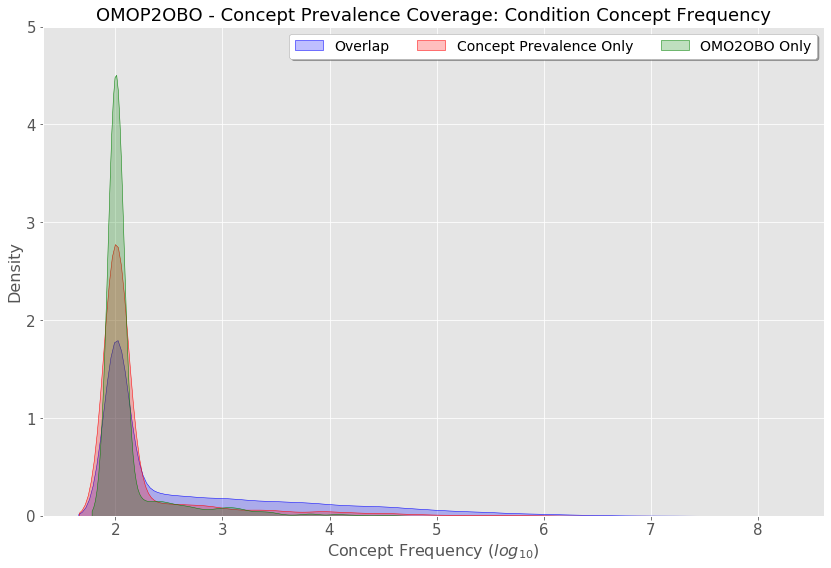

In [29]:
# create histograms
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
y = sns.kdeplot(cond_coverage_sets['overlap']['counts'], color='blue', label='Overlap', shade=True)
y = sns.kdeplot(cond_coverage_sets['cp_only']['counts'], color='red', label='Concept Prevalence Only', shade=True)
y = sns.kdeplot(cond_coverage_sets['omop2obo_only']['counts'], color='green', label='OMO2OBO Only', shade=True)

plt.title('OMOP2OBO - Concept Prevalence Coverage: Condition Concept Frequency', fontsize=18)
plt.suptitle('')
plt.xlabel('Concept Frequency ($log_{10}$)', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.ylim(0.0, 5.0)
plt.tick_params(labelsize=15)
plt.legend(title='', fontsize=14, title_fontsize=14, shadow=True, facecolor='white', edgecolor='darkgray', ncol=3)
plt.show()

OVERLAP COVERAGE SET

In [44]:
# get stats on concepts in both sets and by ontology
covered_concepts_omop2obo = cond_mappings_standard[cond_mappings_standard.CONCEPT_ID.isin(list(overlap_cond_concepts))]

# split results by concept type (i.e. concepts used in practice, standard concepts)
cond_overlap_res = covered_concepts_omop2obo.groupby('CONCEPT_TYPE')

# re-group by ontology
cond_overlap_prac = cond_overlap_res.get_group('Concept Used In Practice').drop_duplicates()
cond_overlap_stnd = cond_overlap_res.get_group('Standard Concept Not Used In Practice').drop_duplicates()

# print the number of overlapping concepts
print('{} OMOP concepts overlapped in OMOP2OBO and the Concept Prevalence data'.format(len(overlap_cond_concepts)))


57663 OMOP concepts overlapped in OMOP2OBO and the Concept Prevalence data


***Concepts Used In Clinical Practice***

In [45]:
print('{} overlapping codes for Concepts Used in Practice'.format(len(cond_overlap_prac)))

# print mapping categories
cond_prac_hp_cat = cond_overlap_prac.groupby('HP_MAPPING').size().reset_index(name='COUNT')
cond_prac_mondo_cat = cond_overlap_prac.groupby('MONDO_MAPPING').size().reset_index(name='COUNT')

# create plotting data
overlap_cond_prac_data = pd.DataFrame({'ontology': ['HP'] * len(cond_prac_hp_cat) + ['MONDO'] * len(cond_prac_mondo_cat),
                                       'mapping_category': list(cond_prac_hp_cat['HP_MAPPING']) + list(cond_prac_mondo_cat['MONDO_MAPPING']),
                                       'counts': list(np.log10(cond_prac_hp_cat['COUNT'])) + list(np.log10(cond_prac_mondo_cat['COUNT']))})


26807 overlapping codes for Concepts Used in Practice


In [46]:
# print hp data
cond_prac_hp_cat

,HP_MAPPING,COUNT
0,Automatic Constructor - Ancestor,1095
1,Automatic Constructor - Concept,123
2,Automatic Exact - Ancestor,2843
3,Automatic Exact - Concept,3506
4,Manual,4801
5,Manual Constructor,9217
6,Manual Exact - Concept Similarity,955
7,Unmapped,4267


In [47]:
# print mondo
cond_prac_mondo_cat

,MONDO_MAPPING,COUNT
0,Automatic Constructor - Ancestor,4133
1,Automatic Constructor - Concept,621
2,Automatic Exact - Ancestor,5411
3,Automatic Exact - Concept,4694
4,Manual,509
5,Manual Constructor,2523
6,Manual Exact - Concept Similarity,512
7,Unmapped,8404


***Standard SNOMED-CT Concepts Not Used In Practice***

In [48]:
print('{} overlapping codes for Standard SNOMED-CT Concepts Not Used in Practice'.format(len(cond_overlap_stnd)))

# print mapping categories
cond_stnd_hp_cat = cond_overlap_stnd.groupby('HP_MAPPING').size().reset_index(name='COUNT')
cond_stnd_mondo_cat = cond_overlap_stnd.groupby('MONDO_MAPPING').size().reset_index(name='COUNT')

# create plotting data
overlap_cond_stnd_data = pd.DataFrame({'ontology': ['HP'] * (len(cond_stnd_hp_cat) + 2) + ['MONDO'] * (len(cond_stnd_mondo_cat) + 2),
                                       'mapping_category': list(list(cond_stnd_hp_cat['HP_MAPPING']) + ['Manual Constructor', 'Manual']) + list(list(cond_stnd_mondo_cat['MONDO_MAPPING']) + ['Manual Constructor', 'Manual']),
                                       'counts': list(np.log10(cond_stnd_hp_cat['COUNT'])) + [0, 0] + list(np.log10(cond_stnd_mondo_cat['COUNT'])) + [0, 0]})


30856 overlapping codes for Standard SNOMED-CT Concepts Not Used in Practice


In [49]:
# print hp data
cond_stnd_hp_cat

,HP_MAPPING,COUNT
0,Automatic Constructor - Ancestor,20539
1,Automatic Constructor - Concept,19
2,Automatic Exact - Ancestor,3873
3,Automatic Exact - Concept,878
4,Manual Exact - Concept Similarity,202
5,Unmapped,5345


In [50]:
# print mondo
cond_stnd_mondo_cat

,MONDO_MAPPING,COUNT
0,Automatic Constructor - Ancestor,19600
1,Automatic Constructor - Concept,197
2,Automatic Exact - Ancestor,449
3,Automatic Exact - Concept,2619
4,Manual Exact - Concept Similarity,94
5,Unmapped,7897


***Plot Counts of Concepts By Mapping Category***

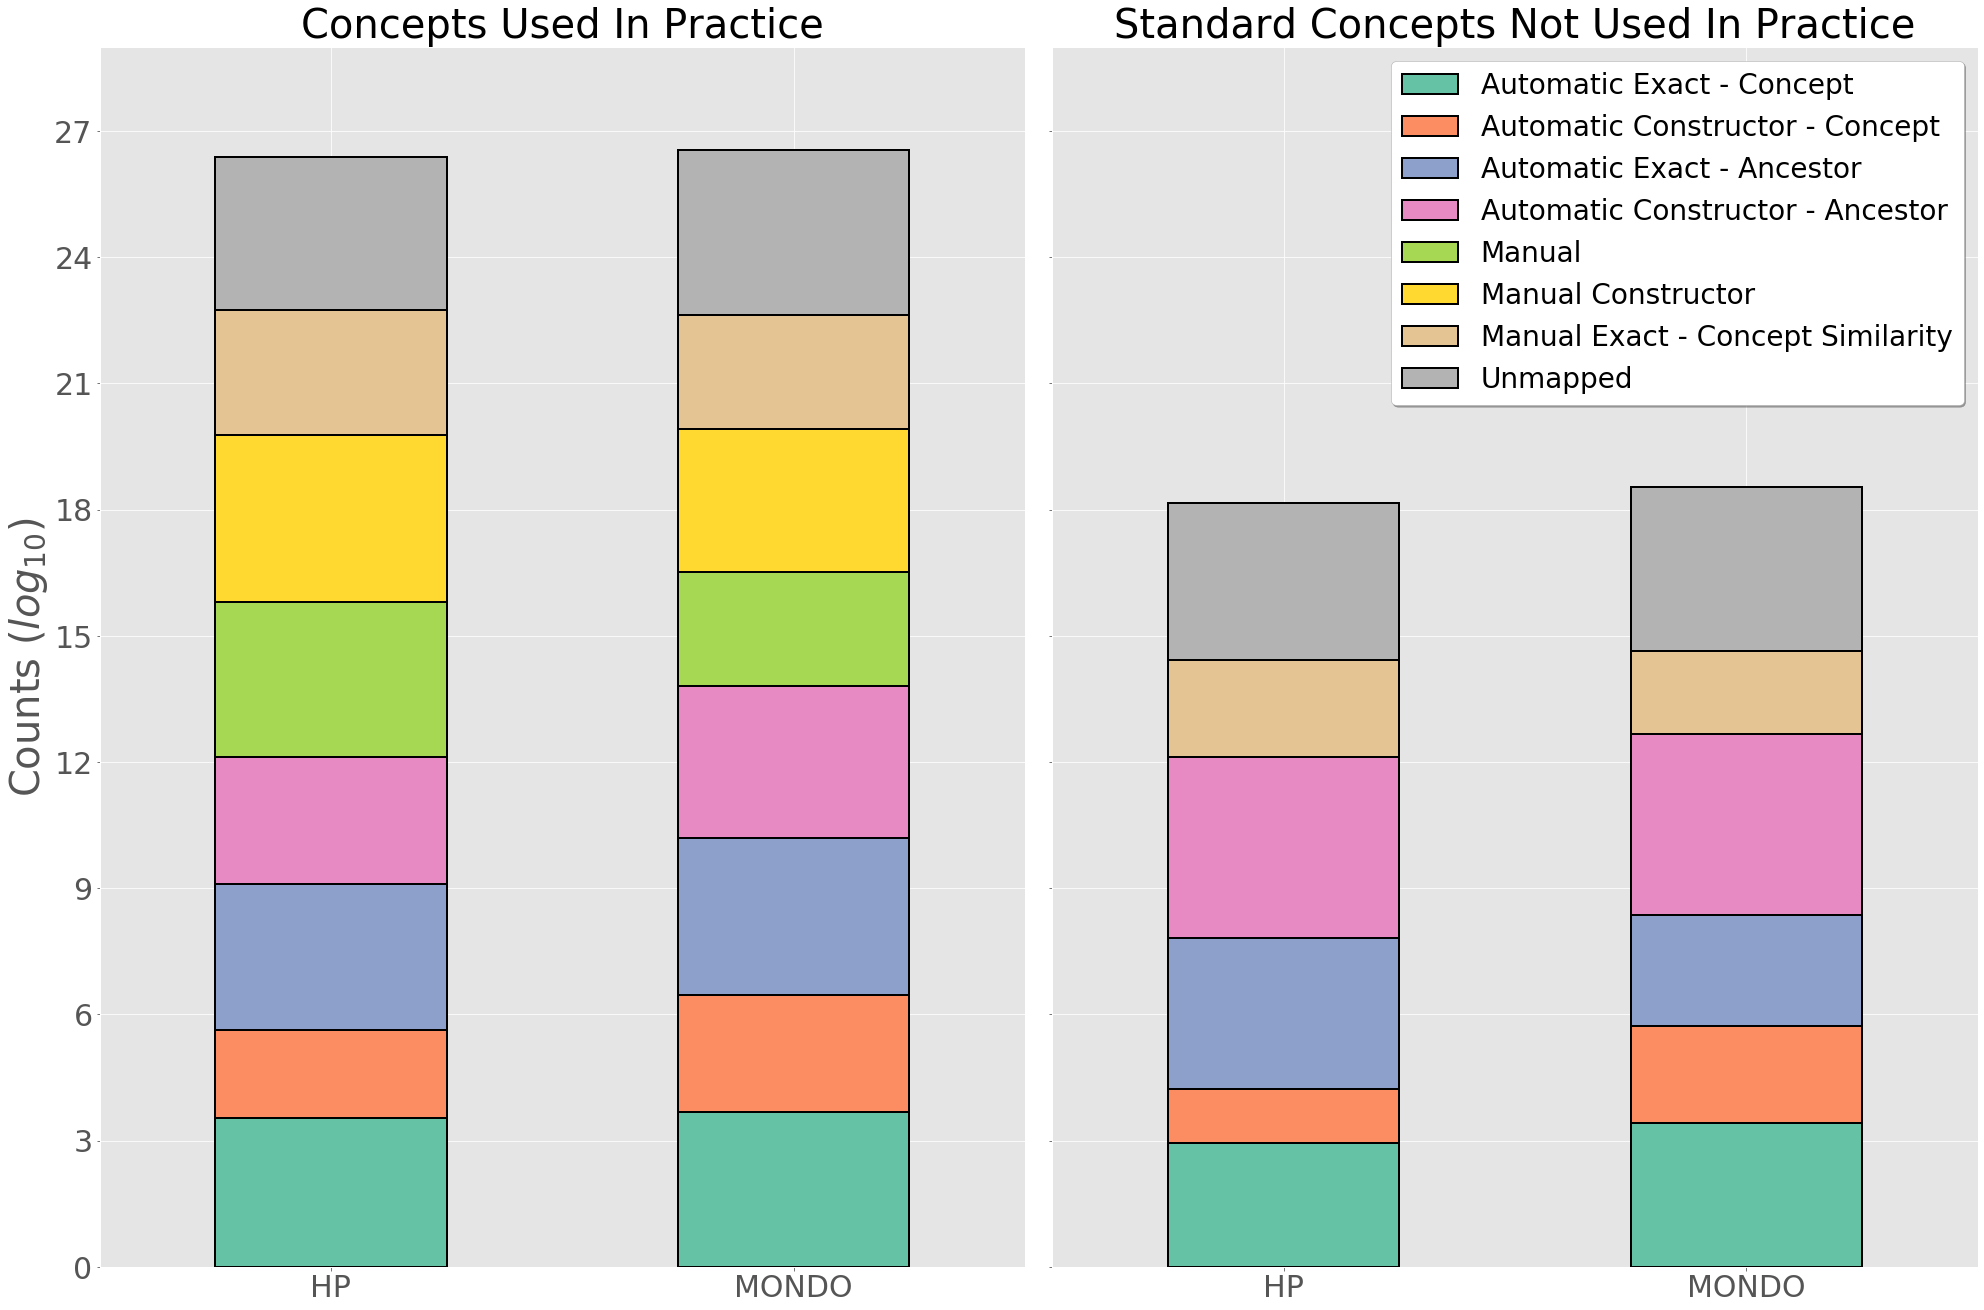

In [51]:
# create plot data
plots = { 'Concepts Used In Practice': overlap_cond_prac_data,
         'Standard Concepts Not Used In Practice': overlap_cond_stnd_data}

ordering = ['Automatic Exact - Concept', 'Automatic Constructor - Concept',
           'Automatic Exact - Ancestor', 'Automatic Constructor - Ancestor',
            'Manual', 'Manual Constructor', 'Manual Exact - Concept Similarity', 'Unmapped']

# create plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 18))
scale_min, scale_max, scale_step = 0, 29, 3 
xlabel, ylabel = '', 'Counts ($log_{10}$)'
for df, ax in zip(plots.keys(), axes):
    plt_data = plots[df].pivot(index='ontology', columns='mapping_category', values='counts')
    plt_data = plt_data.reindex(ordering, axis=1)
    ax = plt_data.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', linewidth=2, colormap='Set2')
    ax.set_title(df, fontsize=40, alpha=1.0)
    ax.set_ylabel(ylabel, fontsize=40),
    ax.set_xlabel(xlabel, fontsize=40),
    ax.set_ylim(scale_min, scale_max)
    ax.set_yticks(range(scale_min, scale_max, scale_step))
    ax.set_yticklabels(labels=range(scale_min, scale_max, scale_step), rotation=0, minor=False, fontsize=30)
    ax.set_xticklabels(labels=list(plt_data.index), rotation=0, minor=False, fontsize=30)
    handles, labels = ax.get_legend_handles_labels()

# facet into single plot
plt.tight_layout(pad=0.0, w_pad=-6.5, h_pad=0.0)
axes[1].set_ylabel("")
axes[1].set_yticklabels("")
axes[0].legend().set_visible(False)
axes[1].legend(ordering, fontsize=28, shadow=True, facecolor='white', edgecolor='darkgray', ncol=1)

plt.show()

OMOP2OBO ONLY COVERAGE SET

In [52]:
# get stats on concepts in both sets and by ontology
omop2obo_only_concepts = cond_mappings_standard[cond_mappings_standard.CONCEPT_ID.isin(list(only_omop2obo_cond_concepts))]

# split results by concept type (i.e. concepts used in practice, standard concepts)
cond_omop2obo_res = omop2obo_only_concepts.groupby('CONCEPT_TYPE')

# re-group by ontology
cond_omop2obo_prac = cond_omop2obo_res.get_group('Concept Used In Practice').drop_duplicates()
cond_omop2obo_stnd = cond_omop2obo_res.get_group('Standard Concept Not Used In Practice').drop_duplicates()

# print the number of overlapping concepts
print('{} OMOP concepts Only Found in OMOP2OBO'.format(len(omop2obo_only_concepts)))


34704 OMOP concepts Only Found in OMOP2OBO


***Concepts Used In Practice***

In [53]:
# print stats for hp category mapping
print('{} OMOP2OBO only codes for Concepts Used in Practice'.format(len(cond_omop2obo_prac)))

# print mapping categories
cond_prac_hp_cat = cond_omop2obo_prac.groupby('HP_MAPPING').size().reset_index(name='COUNT')
cond_prac_mondo_cat = cond_omop2obo_prac.groupby('MONDO_MAPPING').size().reset_index(name='COUNT')

# create plotting data
omop2obo_only_cond_prac_data = pd.DataFrame({'ontology': ['HP'] * len(cond_prac_hp_cat) + ['MONDO'] * len(cond_prac_mondo_cat),
                                             'mapping_category': list(cond_prac_hp_cat['HP_MAPPING']) + list(cond_prac_mondo_cat['MONDO_MAPPING']),
                                             'counts': list(np.log10(cond_prac_hp_cat['COUNT'])) + list(np.log10(cond_prac_mondo_cat['COUNT']))})

2272 OMOP2OBO only codes for Concepts Used in Practice


In [54]:
# print hp data
cond_prac_hp_cat

,HP_MAPPING,COUNT
0,Automatic Constructor - Ancestor,43
1,Automatic Constructor - Concept,2
2,Automatic Exact - Ancestor,312
3,Automatic Exact - Concept,95
4,Manual,219
5,Manual Constructor,1208
6,Manual Exact - Concept Similarity,40
7,Unmapped,353


In [55]:
# print mondo
cond_prac_mondo_cat

,MONDO_MAPPING,COUNT
0,Automatic Constructor - Ancestor,349
1,Automatic Constructor - Concept,11
2,Automatic Exact - Ancestor,550
3,Automatic Exact - Concept,142
4,Manual,246
5,Manual Constructor,313
6,Manual Exact - Concept Similarity,41
7,Unmapped,620


***Standard SNOMED-CT Concepts Not Used In Practice***

In [56]:
print('{} OMOP2OBO only codes for Standard SNOMED-CT Concepts Not Used in Practice'.format(len(cond_omop2obo_stnd)))

# print mapping categories
cond_stnd_hp_cat = cond_omop2obo_stnd.groupby('HP_MAPPING').size().reset_index(name='COUNT')
cond_stnd_mondo_cat = cond_omop2obo_stnd.groupby('MONDO_MAPPING').size().reset_index(name='COUNT')

# create plotting data
omop2obo_only_cond_stnd_data = pd.DataFrame({'ontology': ['HP'] * (len(cond_stnd_hp_cat) + 2) + ['MONDO'] * (len(cond_stnd_mondo_cat) + 2),
                                             'mapping_category': list(list(cond_stnd_hp_cat['HP_MAPPING']) + ['Manual Constructor', 'Manual']) + list(list(cond_stnd_mondo_cat['MONDO_MAPPING']) + ['Manual Constructor', 'Manual']),
                                             'counts': list(np.log10(cond_stnd_hp_cat['COUNT'])) + [0, 0] + list(np.log10(cond_stnd_mondo_cat['COUNT'])) + [0, 0]})

32432 OMOP2OBO only codes for Standard SNOMED-CT Concepts Not Used in Practice


In [57]:
# print hp data
cond_stnd_hp_cat

,HP_MAPPING,COUNT
0,Automatic Constructor - Ancestor,16408
1,Automatic Constructor - Concept,6
2,Automatic Exact - Ancestor,6567
3,Automatic Exact - Concept,288
4,Manual Exact - Concept Similarity,178
5,Unmapped,8985


In [58]:
# print mondo
cond_stnd_mondo_cat

,MONDO_MAPPING,COUNT
0,Automatic Constructor - Ancestor,16142
1,Automatic Constructor - Concept,56
2,Automatic Exact - Ancestor,2500
3,Automatic Exact - Concept,1642
4,Manual Exact - Concept Similarity,20
5,Unmapped,12072


***Plot Counts of Concepts By Mapping Category***

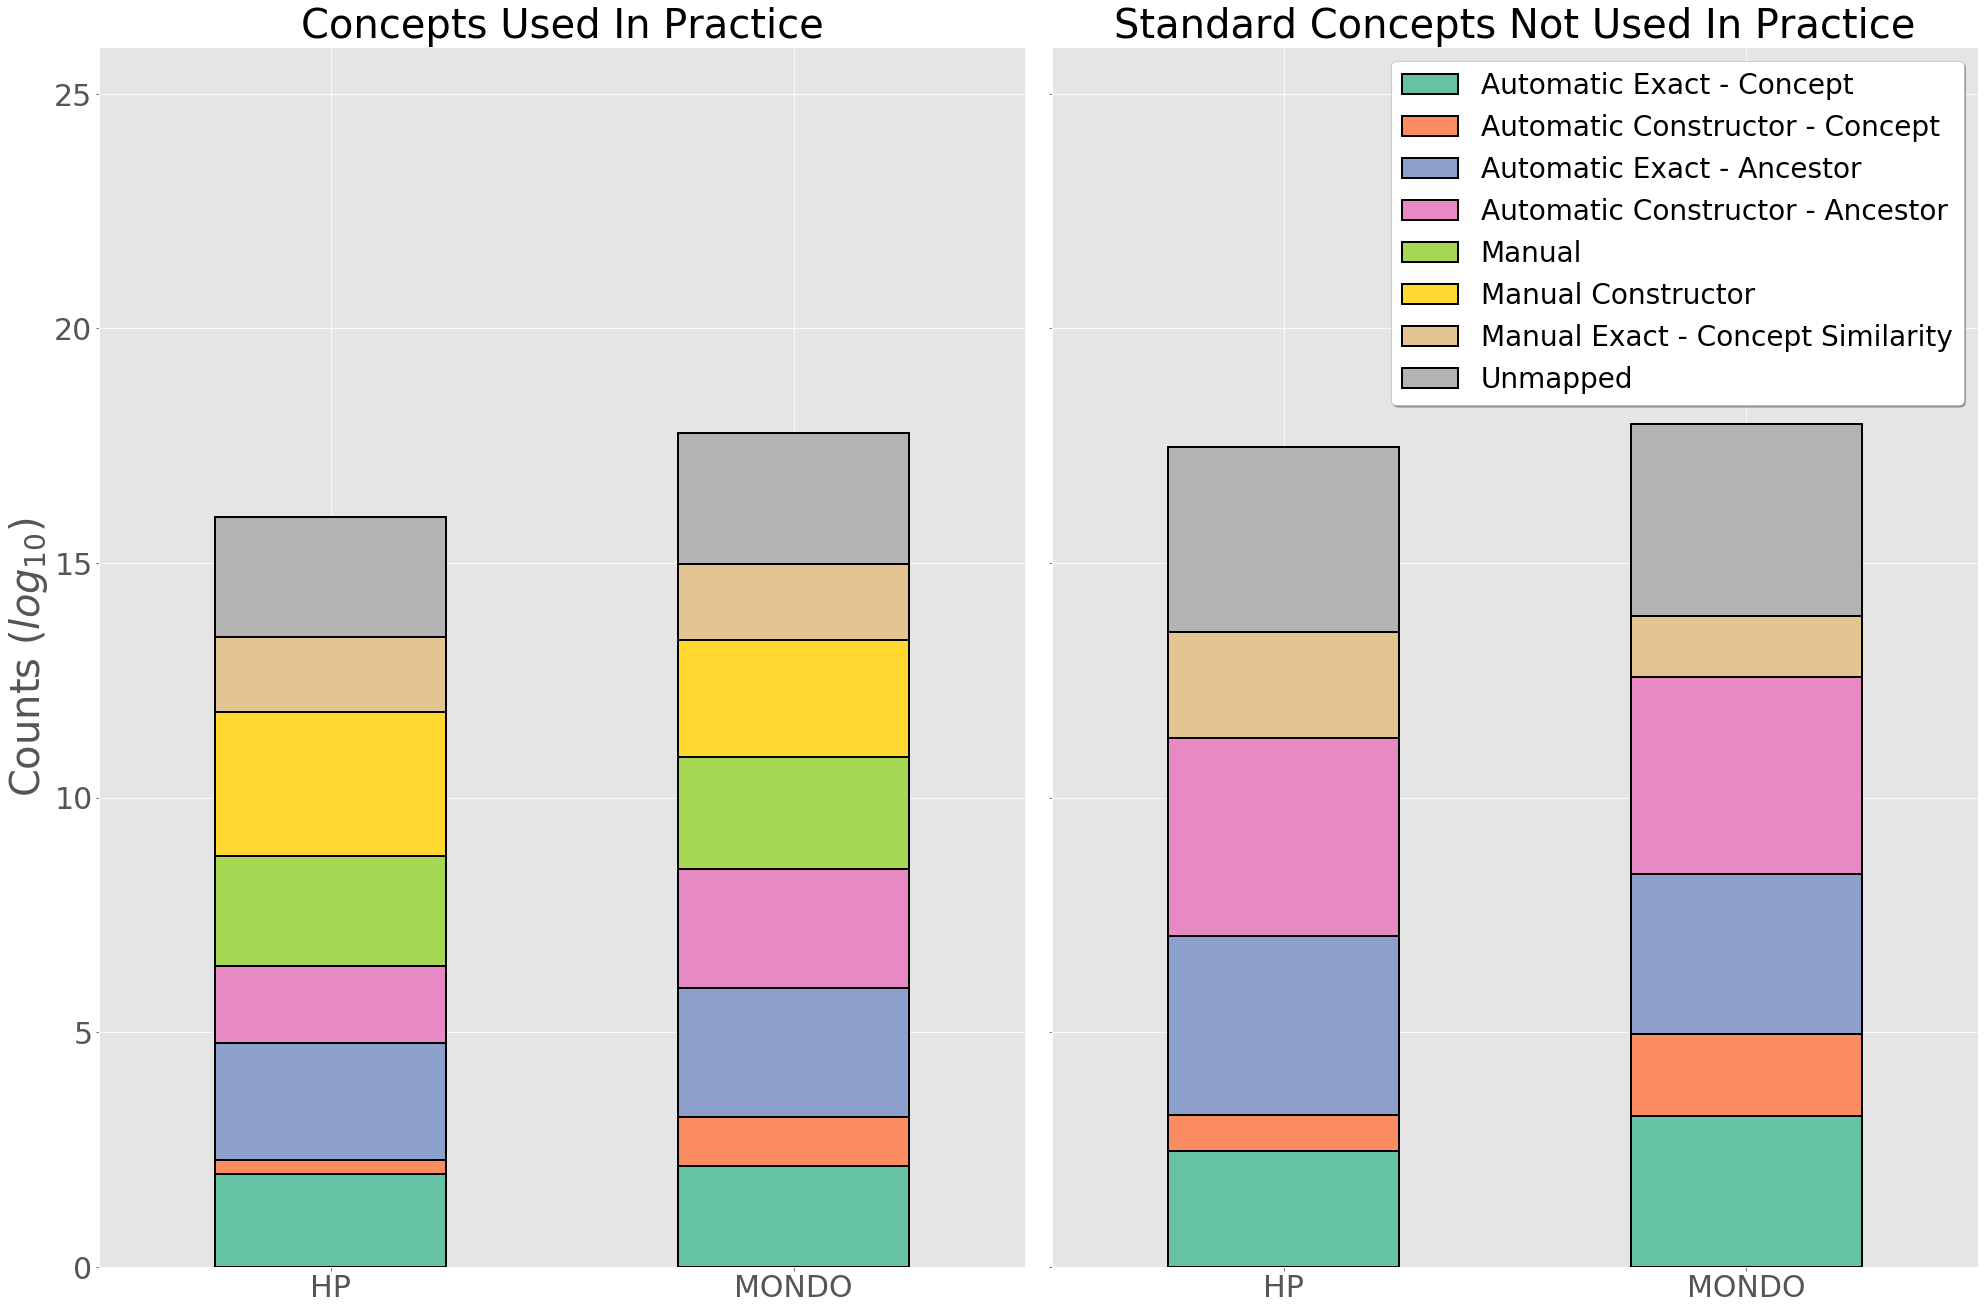

In [59]:
# create plot data
plots = { 'Concepts Used In Practice': omop2obo_only_cond_prac_data,
         'Standard Concepts Not Used In Practice': omop2obo_only_cond_stnd_data}

ordering = ['Automatic Exact - Concept', 'Automatic Constructor - Concept',
           'Automatic Exact - Ancestor', 'Automatic Constructor - Ancestor',
            'Manual', 'Manual Constructor', 'Manual Exact - Concept Similarity', 'Unmapped']

# create plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 18))
scale_min, scale_max, scale_step = 0, 26, 5 
xlabel, ylabel = '', 'Counts ($log_{10}$)'
for df, ax in zip(plots.keys(), axes):
    plt_data = plots[df].pivot(index='ontology', columns='mapping_category', values='counts')
    plt_data = plt_data.reindex(ordering, axis=1)
    ax = plt_data.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', linewidth=2, colormap='Set2')
    ax.set_title(df, fontsize=40, alpha=1.0)
    ax.set_ylabel(ylabel, fontsize=40),
    ax.set_xlabel(xlabel, fontsize=40),
    ax.set_ylim(scale_min, scale_max)
    ax.set_yticks(range(scale_min, scale_max, scale_step))
    ax.set_yticklabels(labels=range(scale_min, scale_max, scale_step), rotation=0, minor=False, fontsize=30)
    ax.set_xticklabels(labels=list(plt_data.index), rotation=0, minor=False, fontsize=30)
    handles, labels = ax.get_legend_handles_labels()

# facet into single plot
plt.tight_layout(pad=0.0, w_pad=-6.5, h_pad=0.0)
axes[1].set_ylabel("")
axes[1].set_yticklabels("")
axes[0].legend().set_visible(False)
axes[1].legend(ordering, fontsize=28, shadow=True, facecolor='white', edgecolor='darkgray', ncol=1)

plt.show()

ERROR ANALYSIS   
The goal of the error analysis was to try and explain the `OMOP2OBO` concepts that were not found in the `Concept Prevalence` data. For this analysis, we group the `4,672` OMOP concepts not covered by the `OMOP2OBO` mapping set into three groups:  
1. **Error Analysis Concepts:** missing concepts found in a current version of the `OMOP` Common Data Model  
2. **Excluded Concepts:** missing concepts that are in the original mapping data, but were excluded from the final mapping set (see [here](#coverage-conditions) for more details)  
3. **Truly Missing Concepts:** missing concepts that cannot be explained by other data sources.


In [61]:
# 4,672 total concepts in CP not included in OMOP2OBO
cond_error_analysis = process_error_analysis_data(error_analysis, only_cp_cond_concepts, cond_mappings,
                                                  cond_mappings_standard, concept_prev_conds)

# find not covered concepts in error analysis data (n=367)
cond_error_analysis_concepts_data = cond_error_analysis[0]

# find not covered concepts in excluded condition mapping data (n=4,231)
cond_filtered_concepts_data = cond_error_analysis[1]

# remaining not covered concepts (n=74)
cond_true_not_covered_concepts_data = cond_error_analysis[2]

# print the results
print('Of the {} concepts not covered by OMOP2OBO:\n  - {} are in the Error Analysis data\n  - {} are in the excluded condition map set data\n  - {} are truly not covered'.format(len(only_cp_cond_concepts),
                                                                                                                                                                                   len(set(cond_error_analysis_concepts_data['TARGET_CONCEPT_ID'])),
                                                                                                                                                                                   len(set(cond_filtered_concepts_data['CONCEPT_ID'])),
                                                                                                                                                                                   len(set(cond_true_not_covered_concepts_data['CONCEPT_ID']))))


Of the 4672 concepts not covered by OMOP2OBO:
  - 367 are in the Error Analysis data
  - 4231 are in the excluded condition map set data
  - 74 are truly not covered


In [62]:
# convert data frames into dictionaries
# create a list of databases
cond_dbs = [concept_prev_conds, cond_mappings, cond_mappings_standard]

# find not covered concepts in error analysis data (n=367)
cond_error_analysis_dict = classifies_missing_concepts(cond_error_analysis_concepts_data, condition_onts, 'TARGET_CONCEPT_ID', 'error', cond_dbs)

# find not covered concepts in excluded condition mapping data (n=4,231)
cond_filtered_concepts_dict = classifies_missing_concepts(cond_filtered_concepts_data, condition_onts, 'CONCEPT_ID', 'excluded', cond_dbs)

# remaining not covered concepts (n=74)
cond_tp_not_covered_dict = classifies_missing_concepts(cond_true_not_covered_concepts_data, condition_onts, 'CONCEPT_ID', 'missing', cond_dbs)


100%|██████████| 74/74 [00:00<00:00, 120.32it/s]


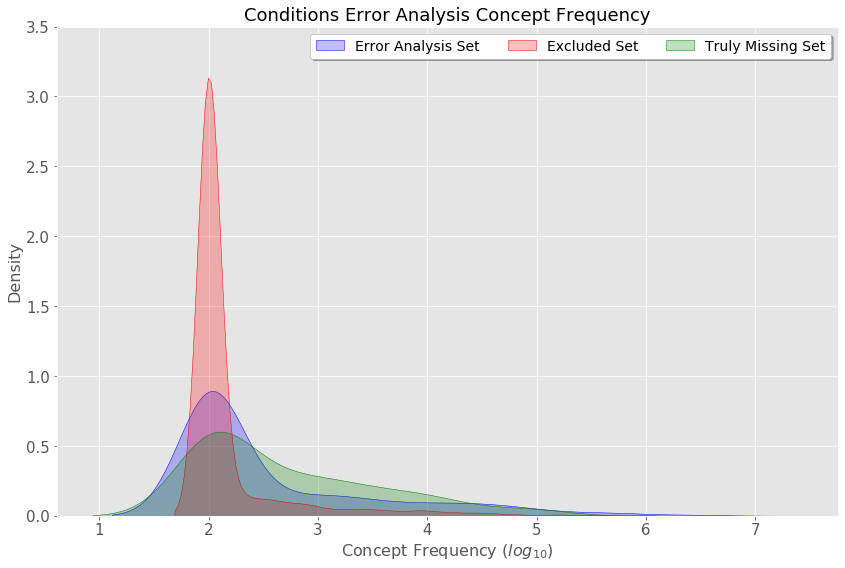

In [63]:
# process count data
cond_error_analysis_counts = [statistics.mean(cond_error_analysis_dict['error'][x]['counts']) for x in cond_error_analysis_dict['error'].keys()]
cond_filtered_counts = [statistics.mean(cond_filtered_concepts_dict['excluded'][x]['counts']) for x in cond_filtered_concepts_dict['excluded'].keys()]
cond_missing_counts = [statistics.mean(cond_tp_not_covered_dict['missing'][x]['counts']) for x in cond_tp_not_covered_dict['missing'].keys()]

# create plot data
plt_data = pd.DataFrame({'set':['Error Analysis Set'] * len(cond_error_analysis_counts) + ['Excluded Set'] * len(cond_filtered_counts) + ['Truly Missing Set'] * len(cond_missing_counts),
                        'counts': np.log10(cond_error_analysis_counts).tolist() + np.log10(cond_filtered_counts).tolist() + np.log10(cond_missing_counts).tolist()})

# create histograms
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
y = sns.kdeplot(np.log10(cond_error_analysis_counts).tolist(), color='blue', label='Error Analysis Set', shade=True)
y = sns.kdeplot(np.log10(cond_filtered_counts).tolist(), color='red', label='Excluded Set', shade=True)
y = sns.kdeplot(np.log10(cond_missing_counts).tolist(), color='green', label='Truly Missing Set', shade=True)

plt.title('Conditions Error Analysis Concept Frequency', fontsize=18)
plt.suptitle('')
plt.xlabel('Concept Frequency ($log_{10}$)', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.ylim(0.0, 3.5)
plt.tick_params(labelsize=15)
plt.legend(title='', fontsize=14, title_fontsize=14, shadow=True, facecolor='white', edgecolor='darkgray', ncol=3)
plt.show()


***Error Analysis Concepts***

In [64]:
# get counts of error analysis types (i.e. newly added concept or replaced concept)
cond_source_concepts, cond_relationship_types = [], []
for x in cond_error_analysis_dict['error'].keys():
    for y in cond_error_analysis_dict['error'][x]['evidence'].keys():
        if y != 'master_evidence':
            cond_source_concepts.append(y)
            cond_relationship_types.append(cond_error_analysis_dict['error'][x]['evidence'][y]['relation']) 

# get counts of relationship ids
cond_error_analysis_types = Counter(cond_relationship_types)

print('The {} missing concepts account can be mapped to {} source concepts using the following relations:'.format(len(cond_error_analysis_dict['error'].keys()),
                                                                                                                 len(cond_source_concepts)))
print('  - ' + '\n  - '.join(['{}: {}'.format(x[0], x[1]) for x in cond_error_analysis_types.items()]))
            

The 367 missing concepts account can be mapped to 1423 source concepts using the following relations:
  - Is a: 1225
  - Maps to: 167
  - Concept replaced by: 31


In [66]:
cond_error_analysis_dbs = [cond_error_analysis_dict['error'][x]['dbs'] for x in cond_error_analysis_dict['error'].keys()]
cond_error_analysis_count = [statistics.mean(cond_error_analysis_dict['error'][x]['counts']) for x in cond_error_analysis_dict['error'].keys()]

print('Database site concept occurrence: {} min, {} mean, {} max'.format(min(cond_error_analysis_dbs), round(statistics.mean(cond_error_analysis_dbs), 3), max(cond_error_analysis_dbs)))
print('Concept Frequency information: {} min, {} mean, {} max'.format(min(cond_error_analysis_count), round(statistics.mean(cond_error_analysis_count), 3), max(cond_error_analysis_count)))


Database site concept occurrence: 1 min, 2.635 mean, 19 max
Concept Frequency information: 100 min, 27412.262 mean, 3539698.5 max


***Excluded Concepts***

In [67]:
cond_evidence_types = [cond_filtered_concepts_dict['excluded'][x]['evidence'] for x in cond_filtered_concepts_dict['excluded'].keys()]

cond_evidence_type_list = []
for x in cond_evidence_types:
    key = [i for i in x.keys() if i != 'master_evidence']
    for y in key:
        cond_evidence_type_list.append(tuple(x[y]['evidence']))

# get counts of each tye of evidence        
cond_evidence = Counter(cond_evidence_type_list)

print('Of the {} missing variables found in the excluded data frame:\n  - {}'.format(len(cond_filtered_concepts_dict['excluded'].keys()),
                                                                                     '\n  - '.join([str(x[1]) + ' ' + '-'.join(x[0]) for x in cond_evidence.items()])))

Of the 4231 missing variables found in the excluded data frame:
  - 3400 HP:NOT YET MAPPED-MONDO:FINDING
  - 796 HP:NOT YET MAPPED-MONDO:NOT YET MAPPED
  - 35 HP:NONE-MONDO:NONE


In [69]:
cond_excluded_analysis_dbs = [cond_filtered_concepts_dict['excluded'][x]['dbs'] for x in cond_filtered_concepts_dict['excluded'].keys()]
cond_excluded_analysis_count = [statistics.mean(cond_filtered_concepts_dict['excluded'][x]['counts']) for x in cond_filtered_concepts_dict['excluded'].keys()]

print('Database site concept occurrence: {} min, {} mean, {} max'.format(min(cond_excluded_analysis_dbs), statistics.mean(cond_excluded_analysis_dbs), max(cond_excluded_analysis_dbs)))
print('Concept Frequency information: {} min, {} mean, {} max'.format(min(cond_excluded_analysis_count), statistics.mean(cond_excluded_analysis_count), max(cond_excluded_analysis_count)))


Database site concept occurrence: 1 min, 1.6516190025998583 mean, 24 max
Concept Frequency information: 100 min, 6139.319766410318 mean, 8254186.5 max


***Truly Missing Concepts***

In [68]:
# freq_dict = {tp_not_covered_dict['missing'][x]['avg_count']: str(x) + ':' + tp_not_covered_dict['missing'][x]['evidence'] for x in tp_not_covered_dict['missing'].keys()}
counts, dbs, concepts = [], [], []
for x in cond_tp_not_covered_dict['missing'].keys():
    for y in cond_tp_not_covered_dict['missing'][x]:
        for z in cond_tp_not_covered_dict['missing'][x]['evidence'].keys():
            if z != 'master_evidence':
                counts.append(statistics.mean(cond_tp_not_covered_dict['missing'][x]['counts']))
                dbs.append(cond_tp_not_covered_dict['missing'][x]['dbs'])
                concepts.append(str(x) + ': ' + cond_tp_not_covered_dict['missing'][x]['evidence'][z]['evidence'])

# create Pandas DataFrame
cond_truly_mising_df = pd.DataFrame({'Concept Frequency': counts, 'Database Count': dbs, 'Concept': concepts}).drop_duplicates()
                
# print missing concepts sorted descending by concept frequency
cond_truly_mising_df = cond_truly_mising_df.sort_values(['Concept Frequency', 'Database Count'], ascending=False)
cond_truly_mising_df.head(n=20)

,Concept Frequency,Database Count,Concept
204,100483.000,1,4091502: Increased fluid intake
168,93585.000,1,37311061: Disease caused by 2019-nCoV
69,62900.333,3,40443308: Polycystic ovary syndrome
138,22324.400,10,35615055: Saddle embolus of pulmonary artery w...
42,18453.000,1,36684319: Adjustment disorder with mixed anxie...
207,13394.000,1,40650479: Primary malignant neoplasm of poster...
0,9941.643,14,35610112: Mania with psychotic features
27,9392.000,1,36684820: Primary malignant neoplasm of axilla...
3,7830.500,12,35624320: Acute adrenal insufficiency
123,6994.000,1,37309625: Acute on chronic right-sided congest...


In [70]:
cond_tp_analysis_dbs = [cond_tp_not_covered_dict['missing'][x]['dbs'] for x in cond_tp_not_covered_dict['missing'].keys()]
cond_tp_analysis_count = [statistics.mean(cond_tp_not_covered_dict['missing'][x]['counts']) for x in cond_tp_not_covered_dict['missing'].keys()]

print('Database site concept occurrence: {} min, {} mean, {} max'.format(min(cond_tp_analysis_dbs), statistics.mean(cond_tp_analysis_dbs), max(cond_tp_analysis_dbs)))
print('Concept Frequency information: {} min, {} mean, {} max'.format(min(cond_tp_analysis_count), statistics.mean(cond_tp_analysis_count), max(cond_tp_analysis_count)))


Database site concept occurrence: 1 min, 2.7432432432432434 mean, 14 max
Concept Frequency information: 100 min, 5320.0589124839125 mean, 100483 max


#### DATA SITE COVERAGE<a class="anchor" id="cond-data-site-coverage"></a>    
This phase of the experiment aimed to demonstrate the coverage of the `OMOP2OBO` condition occurrence concepts for each `Concept Prevalence` study site. Across the `Concept Prevalence` study sites, coverage ranged from `93.04-99.69%`. A Chi-Square test of independence was run to determine if coverage available differed by database. First, an omnibus test was run to determine whether there was a significant relationship between database and coverage. Results from this test (with Yate's correction) revealed a significant association between the database and coverage ($X^{2}(23)=7,559.11$, $p<0.0001$). In order to better understand these findings, post-hoc tests were run using a Bonferroni adjustment to correct for multiple comparisons. These tests confirmed that `107` of the `276` database comparisons had significantly different coverage ($ps<0.001$).


In [74]:
# Get concept coverage by database
conds_coverage_dict = gets_group_stats(concept_prev_conds.copy(), cond_mappings_standard.copy(), 'DATABASE_NAME', 'CONCEPT_ID')

# create contingency table
dbs = list(conds_coverage_dict.keys())
db_covered = [len(conds_coverage_dict[j]['overlap'].keys()) for j in dbs]
db_not_covered = [len(conds_coverage_dict[j]['primary_only'].keys()) for j in dbs]

# convert to Pandas DataFrame
conds_coverage_df = pd.DataFrame({'Database': dbs, 'Covered': db_covered, 'Not Covered': db_not_covered})

# calculate coverage 
conds_coverage_df['% Coverage'] = round(conds_coverage_df['Covered']/(conds_coverage_df['Covered'] + conds_coverage_df['Not Covered'])*100, 3)

# view table
conds_coverage_df.sort_values('% Coverage', ascending=False)


  8%|▊         | 2/24 [00:00<00:01, 12.28it/s]

Processing 24 Database groups



100%|██████████| 24/24 [00:01<00:00, 16.03it/s]


,Database,Covered,Not Covered,% Coverage
19,Stanford,8759,27,99.693
11,MIMIC3_CDM,2248,7,99.690
18,Pscanner,9075,48,99.474
0,Ajou_university,6023,32,99.472
5,HCUP,9268,53,99.431
12,NHIS_Korea,6602,47,99.293
10,JMDC,5349,43,99.203
3,DA_France,3341,30,99.110
9,IBM_MDCR,15102,136,99.107
6,Hospital,15556,150,99.045


***Plot Coverage by Concept Prevalence Study Site***

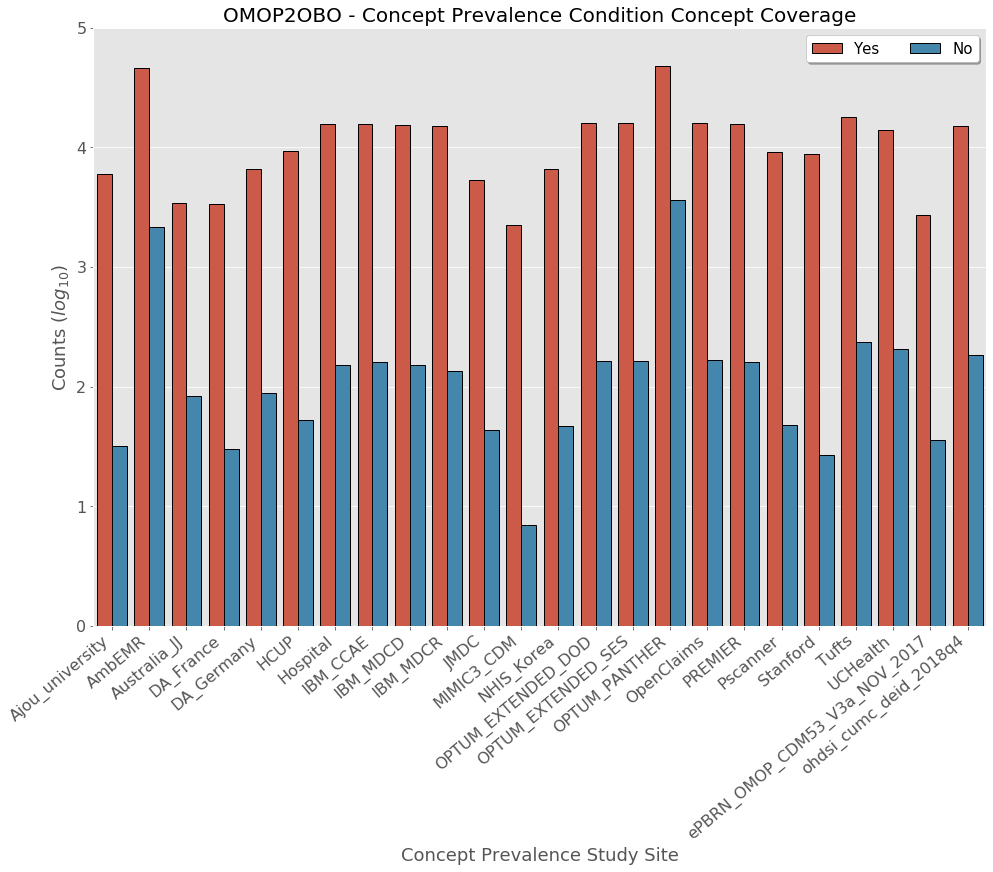

In [75]:
# create plotting data
db_names = dbs * 2
db_coverage = ['Yes'] * len(db_covered) + ['No'] * len(db_not_covered)
db_coverage_counts = np.log10(db_covered + db_not_covered).tolist()

# convert to Pandas DataFrame
conds_cov_df = pd.DataFrame({'Database': db_names, 'Coverage': db_coverage, 'Counts': db_coverage_counts})

# generate bar plot
fig, ax = plt.subplots(1, 1, figsize=(16, 11))

g = sns.barplot(data=conds_cov_df, x='Database', y='Counts', hue="Coverage", edgecolor='black', linewidth=1)
g.set_xticklabels(g.get_xticklabels(), rotation=40, horizontalalignment='right')

# set plot label information
plt.ylim(0, 5)
plt.title('OMOP2OBO - Concept Prevalence Condition Concept Coverage', fontsize=20)
plt.xlabel('Concept Prevalence Study Site', fontsize=18)
plt.ylabel('Counts ($log_{10}$)', fontsize=18)
plt.tick_params(labelsize=16)
plt.legend(title='', fontsize=15, title_fontsize=14,
           shadow=True, facecolor='white', edgecolor='darkgray', ncol=3)

plt.show()


***Chi-Square Test***  


In [76]:
# reformat data to create contingency table
dbs = list(conds_coverage_dict.keys())
db_names = [[j] * (len(conds_coverage_dict[j]['overlap'].keys()) + len(conds_coverage_dict[j]['primary_only'].keys())) for j in dbs]
res = [['Yes'] * len(conds_coverage_dict[j]['overlap'].keys()) + ['No'] * len(conds_coverage_dict[j]['primary_only'].keys()) for j in dbs]

# create df
df = pd.DataFrame({'database': [x for y in db_names for x in y], 'coverage': [x for y in res for x in y]})

# create cross-tab view
df_cross = pd.crosstab(df['database'], df['coverage'])

# perform post hoc analysis adjusting applying multiple comparisons correction
# other correction types available: https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
result = chisq_and_posthoc_corrected(df_cross, 'bonferroni')

# group results by outcome
chi_res = result.groupby('reject_h0')
chi_diff = chi_res.get_group(True).drop_duplicates()
chi_same = chi_res.get_group(False).drop_duplicates()


Chi-Square Omnibus Test Results: Test statistic: 7559.105383635358, df: 23, p-value: 0.0
Performing post hoc testing using: bonferroni p-value correction method


Create Heatmap to view Study Site Comparisons

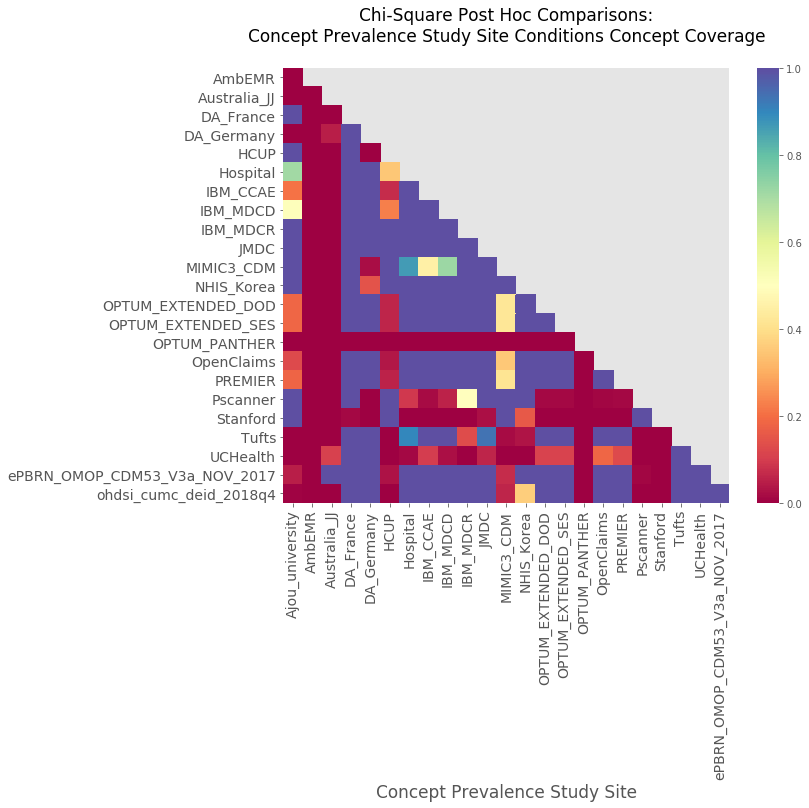

In [712]:
# reformat data and create heat map
result_df = result.copy()

# split comparison column names and add as separate columns
row_names = [x.split('-')[0] for x in list(result_df['comparison'])]
col_names = [x.split('-')[1] for x in list(result_df['comparison'])]
result_df['comparison1'] = row_names
result_df['comparison2'] = col_names

# drop uneeded columns
result_df = result_df.drop(columns=['comparison', 'original_pvalue', 'reject_h0'], axis=1)

# reformat data
res_plot = result_df.pivot(index='comparison2', columns='comparison1', values='corrected_pvalue')

# create heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
g = sns.heatmap(res_plot, annot = False, cmap='Spectral')
# set plot label information
plt.title('Chi-Square Post Hoc Comparisons:\nConcept Prevalence Study Site Conditions Concept Coverage\n', fontsize=17)
plt.xlabel('Concept Prevalence Study Site', fontsize=17)
plt.ylabel('', fontsize=18)
plt.tick_params(labelsize=14)

plt.show()

***OMOP2OBO Overlap Concept Frequency***  
This section examines the frequency of concepts that occurs in both the `OMOP2OBO` map and the `Concept Prevalence` study sites.

In [82]:
# get range of concept frequency for codes in omop2obo and cp
both_covered, both_plt = [], []

for grp in conds_coverage_dict.keys(): 
    overlap = conds_coverage_dict[grp]['overlap'].values()    
    both_covered.append([grp, min(overlap), max(overlap), statistics.median(overlap)])
    both_plt.append([[grp] * len(overlap), overlap])

# create pandas df
cond_covered = pd.DataFrame({'database': [x[0] for x in both_covered],
                             'min_freq': [x[1] for x in both_covered],
                             'max_freq': [x[2] for x in both_covered],
                             'median_freq': [x[3] for x in both_covered]})

In [83]:
cond_covered.sort_values(['median_freq', 'max_freq'], ascending=False)

,database,min_freq,max_freq,median_freq
16,OpenClaims,100,874824195,43000.000
14,OPTUM_EXTENDED_SES,100,177011982,7391.000
13,OPTUM_EXTENDED_DOD,100,177011962,7391.000
7,IBM_CCAE,100,100441128,6779.500
8,IBM_MDCD,100,89563517,3796.000
17,PREMIER,100,117315066,3756.500
6,Hospital,100,59415155,2539.000
5,HCUP,100,44558690,1704.000
10,JMDC,100,25654412,1536.000
21,UCHealth,100,14219460,1346.000


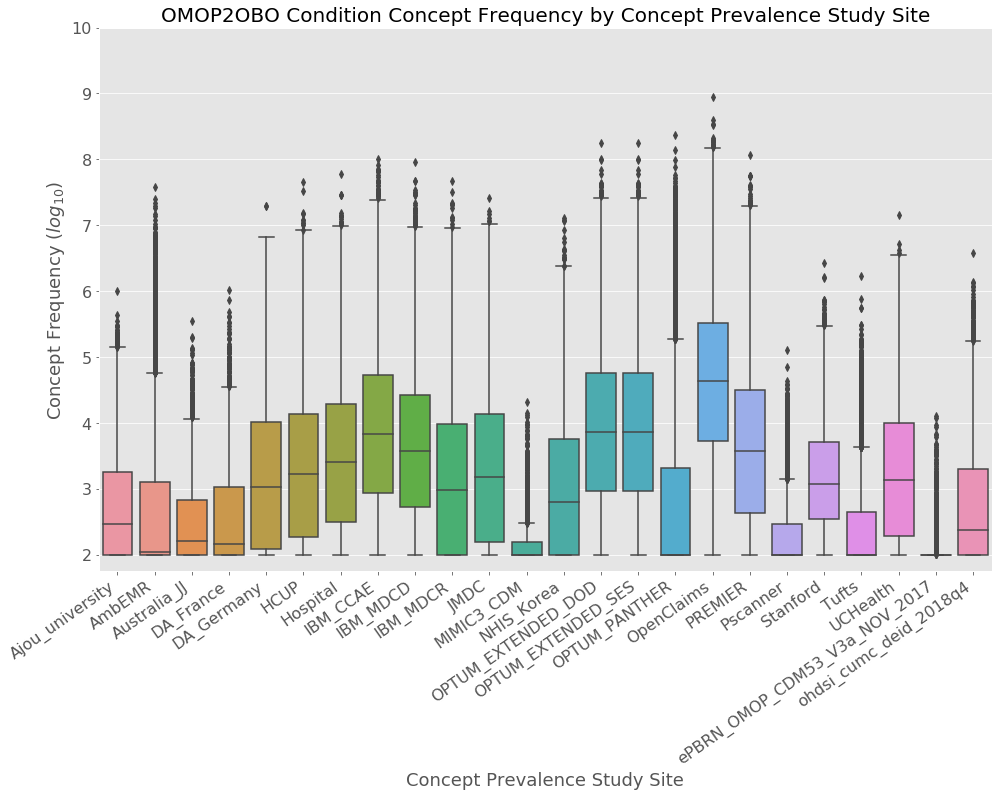

In [84]:
# create plot data
overlap_covered = pd.DataFrame({'database': [x for y in both_plt for x in y[0]],
                                'concept_frequency': [math.log10(x) for y in both_plt for x in y[1]]})

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
sboxplot = sns.boxplot(y='concept_frequency', x='database', data=overlap_covered)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=35, horizontalalignment='right')
plt.title('OMOP2OBO Condition Concept Frequency by Concept Prevalence Study Site', fontsize=20)
plt.suptitle("")
plt.ylim(1.75, 10)
plt.xlabel('Concept Prevalence Study Site', fontsize=18)
plt.ylabel('Concept Frequency ($log_{10}$)', fontsize=18)
plt.tick_params(labelsize=16)
plt.show()

***OMOP2OBO Missing Concept Frequency***   
This section examines the frequency of concepts that occur in the `Concept Prevalence` study sites, but not the `OMOP2OBO` map.

In [85]:
# get range of concept frequency for codes not covered by OMOP2OBO
cp_not_covered, cp_not_plt = [], []

for grp in conds_coverage_dict.keys(): 
    # cp not in omop2obo
    cp_not = conds_coverage_dict[grp]['primary_only'].values()    
    cp_not_covered.append([grp, min(cp_not), max(cp_not), statistics.median(cp_not)])
    cp_not_plt.append([[grp] * len(cp_not), cp_not])

# create pandas df
cond_cp_not_covered = pd.DataFrame({'database': [x[0] for x in cp_not_covered],
                                    'min_freq': [x[1] for x in cp_not_covered],
                                    'max_freq': [x[2] for x in cp_not_covered],
                                    'median_freq': [x[3] for x in cp_not_covered]})
    

In [86]:
# concepts not covered by OMOP2OBO
cond_cp_not_covered.sort_values(['median_freq', 'max_freq'], ascending=False)

# {k: v for k, v in sorted(conds_coverage_dict['OpenClaims']['primary_only'].items(), key=lambda item: item[1], reverse=True)}


,database,min_freq,max_freq,median_freq
16,OpenClaims,100,11663870,5385.000
13,OPTUM_EXTENDED_DOD,100,4456178,1141.500
14,OPTUM_EXTENDED_SES,100,4456178,1141.500
7,IBM_CCAE,100,6133301,839.000
10,JMDC,100,185969,722.000
19,Stanford,102,171382,709.000
21,UCHealth,100,786602,599.000
4,DA_Germany,100,337355,541.500
8,IBM_MDCD,100,52739431,509.500
17,PREMIER,100,3387141,302.000


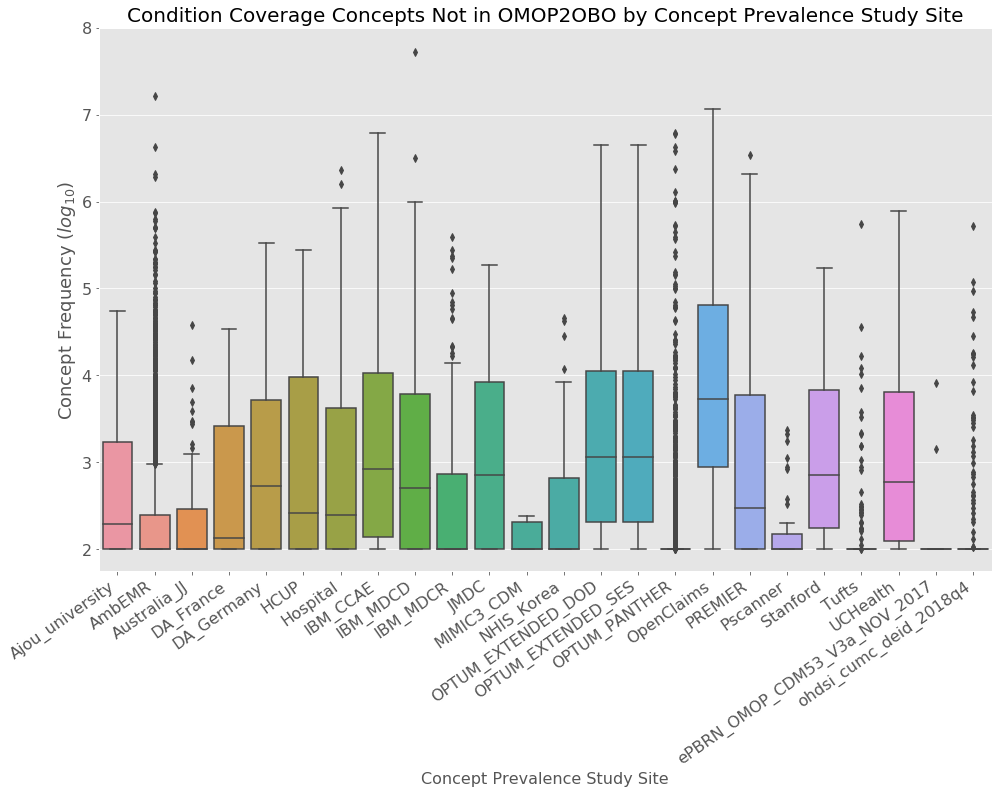

In [87]:
# create plot data
omop_not_cond_plot = pd.DataFrame({'database': [x for y in cp_not_plt for x in y[0]],
                                   'concept_frequency': [math.log10(x) for y in cp_not_plt for x in y[1]]})

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
sboxplot = sns.boxplot(y='concept_frequency', x='database', data=omop_not_cond_plot)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=35, horizontalalignment='right')
plt.title('Condition Coverage Concepts Not in OMOP2OBO by Concept Prevalence Study Site', fontsize=20)
plt.suptitle("")
plt.xlabel('Concept Prevalence Study Site', fontsize=16)
plt.ylabel('Concept Frequency ($log_{10}$)', fontsize=18)
plt.ylim(1.75, 8)
plt.tick_params(labelsize=16)
plt.show()


***

**Click [here](#"coverage-conditions) to return to the Conditions Mapping Validation section**   
**Click [here](#mapping-validation) to return to the Mapping Validation section**  

***

### Drug Ingredients <a class="anchor" id="coverage-drugs"></a>
***

The OHDSI `Concept Prevalence` data contained `4,588` unique OMOP vocabulary concepts from `18` sites. The `OMOP2OBO` vocabulary concepts from each of these sites was compared to the list of concepts from the `OMOP2OBO` mappings. After filtering the `OMOP2OBO` mappings to remove all entries where all ontologies were "NONE" or "NOT YET MAPPED" and all non-standard concepts, `8,615` concepts remained eligible for use in the coverage study. These data were utilized for all condition coverage experiments.

**Experiments**  
- [Full Set Coverage](#drug-full-set-coverage)  
- [Data Site Coverage](#drug-data-site-coverage)  

<br>


**LOAD DATA**

#### *CHCO Concept Frequency Data*  

In [88]:
# read in frequency counts data
chco_concept_counts = pd.read_csv(chco_concept_freq_url, sep=',', header=0)
chco_concept_counts.fillna('', inplace=True)

# reduce columns
chco_concept_counts = chco_concept_counts[['CONCEPT_ID', 'DOMAIN', 'CONCEPT_COUNT', 'CONCEPT_COUNT_ADJUSTED']]

# subset data to only keep conditions
chco_concept_counts = chco_concept_counts[chco_concept_counts['DOMAIN'] == 'Drugs']

# view data
chco_concept_counts.head(n=5)

,CONCEPT_ID,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
458,19123846,Drugs,1,100
459,42900069,Drugs,1,100
493,954853,Drugs,1,100
494,19136429,Drugs,1,100
495,715710,Drugs,1,100


#### *OHDSI Concept Prevalence Data*

In [89]:
# load concept prevalence data
concept_prev_meds = pd.read_excel(coverage_data, sheet_name='Drug_Exposure_Concepts', sep=',', header=0)
concept_prev_meds.fillna('', inplace=True)

# get only RxNorm concepts
concept_prev_meds = concept_prev_meds[concept_prev_meds['VOCAB (TJC)'] =='RxNorm']

# approved databases
concept_prev_meds = concept_prev_meds[concept_prev_meds['ANALYSIS APPROVED  (TJC)'] == 1]

# view data
concept_prev_meds.head(n=5)

,CONCEPT_ID,CONCEPT_NAME,DOMAIN (TJC),STANDARD (TJC),VOCAB (TJC),DATABASE_NAME,RECORD_COUNT,ANALYSIS APPROVED (TJC)
0,501343,hepatitis B immune globulin,Drug,Standard,RxNorm,AmbEMR,9558,1
1,507832,"herpesvirus 3, human",Drug,Standard,RxNorm,AmbEMR,200,1
2,509079,meningococcal group A polysaccharide,Drug,Standard,RxNorm,AmbEMR,135995,1
3,509081,meningococcal group C polysaccharide,Drug,Standard,RxNorm,AmbEMR,130342,1
4,514012,meningococcal polysaccharide vaccine group W-135,Drug,Standard,RxNorm,AmbEMR,119768,1


#### *OMOP2OBO Drug Exposure Ingredient Concept Mappings*

In [90]:
# load data
med_mappings = pd.read_excel(meds_mapping_url, sheet_name='Aggregated_Mapping_Results', sep=',', header=0)
med_mappings.fillna('', inplace=True)

# merge concept counts
med_mappings = med_mappings.merge(chco_concept_counts, how='left', on='CONCEPT_ID').drop_duplicates()

# # get only standard concepts that have been mapped to at least 1 ontology
not_standard = med_mappings.query('STANDARD_CONCEPT != "S"')
not_mapped = med_mappings.query('CHEBI_URI == "NOT YET MAPPED" & PR_URI == "NOT YET MAPPED" & NCBITAXON_URI == "NOT YET MAPPED" & VO_URI == "NOT YET MAPPED"')
nones = med_mappings.query('CHEBI_URI == "NONE" & PR_URI == "NONE" & NCBITAXON_URI == "NONE" & VO_URI == "NONE"')
mixed_chebi_nots = med_mappings.query('CHEBI_URI == "NOT YET MAPPED" & PR_MAPPING == "Unmapped" & NCBITAXON_MAPPING == "Unmapped" & VO_MAPPING == "Unmapped"')
mixed_pr_nots = med_mappings.query('PR_URI == "NOT YET MAPPED" & CHEBI_MAPPING == "Unmapped" & NCBITAXON_MAPPING == "Unmapped" & VO_MAPPING == "Unmapped"')
mixed_ncbitaxon_nots = med_mappings.query('NCBITAXON_URI == "NOT YET MAPPED" & PR_MAPPING == "Unmapped" & CHEBI_MAPPING == "Unmapped" & VO_MAPPING == "Unmapped"')
mixed_vo_nots = med_mappings.query('VO_URI == "NOT YET MAPPED" & PR_MAPPING == "Unmapped" & NCBITAXON_MAPPING == "Unmapped" & CHEBI_MAPPING == "Unmapped"')

med_mappings_standard = med_mappings[~med_mappings.CONCEPT_ID.isin(not_standard['CONCEPT_ID']) &
                                     ~med_mappings.CONCEPT_ID.isin(not_mapped['CONCEPT_ID']) &
                                     ~med_mappings.CONCEPT_ID.isin(nones['CONCEPT_ID']) & 
                                     ~med_mappings.CONCEPT_ID.isin(mixed_chebi_nots['CONCEPT_ID']) & 
                                     ~med_mappings.CONCEPT_ID.isin(mixed_pr_nots['CONCEPT_ID']) &
                                     ~med_mappings.CONCEPT_ID.isin(mixed_ncbitaxon_nots['CONCEPT_ID']) &
                                     ~med_mappings.CONCEPT_ID.isin(mixed_vo_nots['CONCEPT_ID'])]

# keep only needed columns
med_mappings_standard.head()


,CONCEPT_TYPE,CONCEPT_ID,STANDARD_CONCEPT,CONCEPT_LABEL,UMLS_CUI,UMLS_SEM_TYPE,CHEBI_LOGIC,CHEBI_URI,CHEBI_LABEL,CHEBI_MAPPING,...,PR_MAPPING,PR_EVIDENCE,VO_LOGIC,VO_URI,VO_LABEL,VO_MAPPING,VO_EVIDENCE,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
0,Concept Used In Practice,501343,S,hepatitis B immune globulin,C0062525,"Amino Acid, Peptide, or Protein | Pharmacologi...",,CHEBI_60816,immunogen,Manual,...,Manual,Hand Mapping,,VO_0010781,hepatitis b virus protein,Manual,Hand Mapping,Drugs,145.000,145.000
1,Concept Used In Practice,507832,S,Human herpesvirus 3,C0042338,Virus,,CHEBI_60816,immunogen,Manual,...,Manual,Hand Mapping,,VO_0000729,herpes simplex virus vaccine,Manual,Hand Mapping,Drugs,12912.000,12912.000
2,Concept Used In Practice,509079,S,meningococcal group A polysaccharide,C0065942,Organic Chemical | Pharmacologic Substance | I...,AND,CHEBI_65212 | CHEBI_60816,polysaccharide derivative | immunogen,Manual Constructor,...,Manual,Expert Reviewed Mapping | Hand Mapping,,VO_0004888,meningococcal group a polysaccharide,Automatic Exact - Concept,OBO_LABEL-OMOP_CONCEPT_LABEL:meningococcal_gro...,Drugs,93.000,100.000
3,Concept Used In Practice,509081,S,meningococcal group C polysaccharide,C0065944,Organic Chemical | Pharmacologic Substance | I...,AND,CHEBI_65212 | CHEBI_60816,polysaccharide derivative | immunogen,Manual Constructor,...,Manual,Hand Mapping,,VO_0004859,meningococcal group c polysaccharide,Automatic Exact - Concept,OBO_LABEL-OMOP_ANCESTOR_LABEL:meningococcal_gr...,Drugs,93.000,100.000
4,Concept Used In Practice,514012,S,MENINGOCOCCAL POLYSACCHARIDE VACCINE GROUP W-135,C0982275,Organic Chemical | Pharmacologic Substance | I...,AND,CHEBI_65212 | CHEBI_60816,polysaccharide derivative | immunogen,Manual Constructor,...,Manual,Hand Mapping,,VO_0004886,meningococcal polysaccharide vaccine group w-135,Automatic Exact - Concept,OBO_LABEL-OMOP_ANCESTOR_LABEL:meningococcal_po...,Drugs,93.000,100.000


#### *Error Analysis Data*

In [91]:
# load data
error_analysis = pd.read_csv(error_analysis_data, sep=',', header=0)
error_analysis.fillna('', inplace=True)

# view data
error_analysis.head()

,RELATIONSHIP_ID,SCENARIO_TYPE,SOURCE_CONCEPT_ID,SOURCE_CONCEPT_LABEL,TARGET_CONCEPT_ID,TARGET_CONCEPT_LABEL
0,Concept poss_eq from,Newly Added Concept,4243823,Cyst of pharynx,23789,Pharynx or nasopharynx cyst
1,Concept poss_eq from,Newly Added Concept,4108471,Burn of digit of hand,72769,Deep full thickness burn of more than one fing...
2,Concept poss_eq from,Newly Added Concept,4286676,Acquired deformity of rib,73576,Acquired chest and rib deformity
3,Concept poss_eq from,Newly Added Concept,4326589,Pseudohermaphroditism,73584,Indeterminate sex and pseudohermaphroditism
4,Concept poss_eq from,Newly Added Concept,434499,Open fracture of sternum,73615,Open multiple fractures involving both upper l...


In [92]:
print('There are {} OMOP concept ids covered by CHEBI, PR, NCBITaxon or VO mappings via OMOP2OBO mappings'.format(len(med_mappings_standard)))


There are 8615 OMOP concept ids covered by CHEBI, PR, NCBITaxon or VO mappings via OMOP2OBO mappings


In [93]:
print('The Concept Prevalence data contained {} unique OMOP concepts from {} study sites'.format(len(set(list(concept_prev_meds['CONCEPT_ID']))),
                                                                                                 len(set(list(concept_prev_meds['DATABASE_NAME'])))))
                                                                                                    

The Concept Prevalence data contained 4588 unique OMOP concepts from 18 study sites


<br>

#### FULL SET COVERAGE<a class="anchor" id="drug-full-set-coverage"></a>    
This phase of the experiment aimed to demonstrate the coverage of the `OMOP2OBO` drug exposure ingredient concepts across the `Concept Prevalence` study sites. For this phase, a single set of all unique `concept_ids` was used and when reporting concept frequency, we used the average frequency across all relevant sites. To be complete, we first report results for all of the `OMOP2OBO` condition concepts regardless of data type (i.e. *Concept Used in Clinical Practice*, *Standard RxNorm Concept Not Used in Practice*) and then explore each type with respect to the annotated ontologies (i.e. [Chemical Entities of Biological Interest ('CHEBI')](https://www.ebi.ac.uk/chebi/), [NCBI Organism Taxonomy Ontology (NCBITaxon)](https://www.ncbi.nlm.nih.gov/taxonomy), [Protein Ontology (PRO)](https://proconsortium.org/), and [Vaccine Ontology (VO)](http://www.violinet.org/vaccineontology/)). Finally, this section is concluded by performing an *error analysis*, where we use a current version of the `OMOP` Common Data Model (CDM) to try and explain `Concept Prevalence` concepts that were not included in the `OMOP2OBO` mapping set.  

**RESULTS**  
The `OMOP2OBO` ingredient set contained `8,615` OMOP drug ingredient concept ids, which covered `87.99%` of the `4,588` `Concept Prevalence` drug ingredient concepts. There were `4,578` `OMOP2OBO` concepts that were not included in the `Concept Prevalence` set and `551` `Concept Prevalence` concepts that were not covered by the `OMOP2OBO` mappings. These findings are organized into three sets:  
1. <u>Overlap:</u> `4,037` `OMOP2OBO` concepts (`26,807` *Concepts Used in Clinical Practice*, `30,856` *Standard SNOMED-CT Concepts Not Used in Clinical Practice*) existed in `OMOP2OBO` and `Concept Prevalence`. On average, the Overlap Coverage Concepts occurred `8,071.59` times (min: `100.0`, max: `125,634,570.39`)      
2. <u>`OMOP2OBO` Only:</u> `4,578` `OMOP2OBO` concepts (`2,272` *Concepts Used in Clinical Practice*, `32,432` *Standard RxNorm Concepts Not Used in Clinical Practice*) existed only in the `OMOP2OBO` set. On average, the `OMOP2OBO` Only Concepts occurred `468.89` times (min: `100.0`, max: `69,311.0`)       
3. <u>`Concept Prevalence` Only:</u> `551` `OMOP` concepts that existed only in the `Concept Prevalence` set. On average, the `Concept Prevalence` Only Concepts occurred `801.2` times (min: `100.0`, max: `1,795,364.83`)   


**Ontology Annotation Mapping Category Results by Coverage Set and Data Type**  

<table>
<tr>
<th align="center">DATA TYPE</th>  
<th align="center">ONTOLOGY</th>  
<th align="center">EXACT CONCEPT</th>
<th align="center">CONCEPT CONSTRUCTOR</th>
<th align="center">EXACT ANCESTOR</th>
<th align="center">ANCESTOR CONSTRUCTOR</th>
<th align="center">COSINE SIMILARITY</th>
<th align="center">MANUAL</th>
<th align="center">MANUAL CONSTRUCTOR</th>
<th align="center">UNMAPPED</th>
</tr>  
<tr>
  <td colspan="10"><b>OVERLAP SET (n=4,037)</b></td>
</tr>
<tr>
  <td rowspan="4"><i>Concepts Used In Practice (n=1,639)</i></td>
  <td rowspan="1"><i>CHEBI</i></td>
    <td>955</td>
    <td>235</td>
    <td>14</td>
    <td>59</td>
	<td>26</td>
	<td>278</td>
	<td>72</td>
	<td>0</td>
</tr>
<tr>
  <td rowspan="1"><i>PRO</i></td>
    <td>6</td>
    <td>0</td>
    <td>5</td>
    <td>2</td>
	<td>9</td>
	<td>188</td>
	<td>5</td>
	<td>1,424</td>
</tr>
<tr>
  <td rowspan="1"><i>NCBITaxon</i></td>
    <td>18</td>
    <td>0</td>
    <td>22</td>
    <td>2</td>
	<td>113</td>
	<td>262</td>
	<td>9</td>
	<td>1,213</td>
</tr>
<tr>
  <td rowspan="1"><i>VO</i></td>
    <td>90</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
	<td>5</td>
	<td>9</td>
	<td>0</td>
	<td>1,535</td>
</tr>
<tr>
  <td rowspan="4"><i>Standard RxNorm Concepts Not Used In Practice (n=2,398)</i></td>
  <td rowspan="1"><i>CHEBI</i></td>
    <td>1,157</td>
    <td>101</td>
    <td>79</td>
    <td>106</td>
	<td>29</td>
	<td>0</td>
	<td>0</td>
	<td>926</td>
</tr>
<tr>
  <td rowspan="1"><i>PRO</i></td>
    <td>27</td>
    <td>0</td>
    <td>16</td>
    <td>1</td>
	<td>2</td>
	<td>0</td>
	<td>0</td>
	<td>2,352</td>
</tr>
<tr>
  <td rowspan="1"><i>NCBITaxon</i></td>
    <td>50</td>
    <td>0</td>
    <td>10</td>
    <td>1</td>
	<td>918</td>
	<td>0</td>
	<td>0</td>
	<td>1,419</td>
</tr>
<tr>
  <td rowspan="1"><i>VO</i></td>
    <td>7</td>
    <td>0</td>
    <td>3</td>
    <td>0</td>
	<td>4</td>
	<td>0</td>
	<td>0</td>
	<td>2,384</td>
</tr>
<tr>
  <td colspan="10"><b>OMOP2OBO ONLY SET (n=4,578)</b></td>
</tr>
<tr>
  <td rowspan="4"><i>Concepts Used In Practice (n=58)</i></td>
  <td rowspan="1"><i>CHEBI</i></td>
    <td>4</td>
    <td>0</td>
    <td>3</td>
    <td>2</td>
	<td>5</td>
	<td>40</td>
	<td>4</td>
	<td>5</td>
</tr>
<tr>
  <td rowspan="1"><i>PRO</i></td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
	<td>0</td>
	<td>26</td>
	<td>2</td>
	<td>30</td>
</tr>
<tr>
  <td rowspan="1"><i>NCBITaxon</i></td>
    <td>2</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
	<td>23</td>
	<td>12</td>
	<td>3</td>
	<td>18</td>
</tr>
<tr>
  <td rowspan="1"><i>VO</i></td>
    <td>2</td>
    <td>0</td>
    <td>0</td>
    <td>2</td>
	<td>0</td>
	<td>16</td>
	<td>2</td>
	<td>36</td>
</tr>
<tr>
  <td rowspan="4"><i>Standard RxNorm Concepts Not Used In Practice (n=4,520)</i></td>
  <td rowspan="1"><i>CHEBI</i></td>
    <td>1,035</td>
    <td>68</td>
    <td>51</td>
    <td>43</td>
	<td>49</td>
	<td>0</td>
	<td>0</td>
	<td>3,274</td>
</tr>
<tr>
  <td rowspan="1"><i>PRO</i></td>
    <td>15</td>
    <td>0</td>
    <td>3</td>
    <td>0</td>
	<td>8</td>
	<td>0</td>
	<td>0</td>
	<td>4,494</td>
</tr>
<tr>
  <td rowspan="1"><i>NCBITaxon</i></td>
    <td>85</td>
    <td>1</td>
    <td>4</td>
    <td>0</td>
	<td>3,187</td>
	<td>0</td>
	<td>0</td>
	<td>1,243</td>
</tr>
<tr>
  <td rowspan="1"><i>VO</i></td>
    <td>11</td>
    <td>0</td>
    <td>1</td>
    <td>0</td>
	<td>10</td>
	<td>0</td>
	<td>0</td>
	<td>4,498</td>
</tr>
</table>       

<br>

**Error Analysis**   
Of the `551` concepts not covered by `OMOP2OBO`, `5` can be accounted for by the current version of the `OMOP` CDM (i.e. *Error Analysis Concepts*), `456` can be accounted for in set of excluded mappings from the original mapping set (i.e. *Excluded Concepts*), and `90` concepts were missing and unable to be explained by existing data sources (i.e. *Truly Missing Concepts*). Additional details on each of these concept sets is provided below.

- *Error Analysis Concepts:* A total of `5` (`0.91%`) missing concepts were accounted for using the current version of the `OMOP` CDM using the OMOP `concept_relationship` table. These concepts occurred in an average of `8.4` `Concept Prevalence` study sites and had a mean frequency of `51,732.04` (min: `100`; max: `221,229.71`). The `5` missing concepts could be traced to `6` `source_concept_ids` in the original `OMOP2OBO` map set using the following `relationship_ids`: Maps to (n=`6`)


- *Excluded Concepts:* A total of `456` (`82.76%`) `OMOP` concepts could be found in the set of data which was initially filtered from the original `OMOP2OBO` mapping set. These concepts occurred in an average of `3.88` `Concept Prevalence` study sites and had a mean frequency of `18,847.28` (min: `100`; max: `1,077,258.9`).These concepts were initially excluded for one of the following reasons: (1) `456` OMOP concepts were of type *Standard RxNorm Concepts Not Yet Used in Practice* with CHEBI, PRO, NCBITaxon, and VO type "NOT YET MAPPED" 


- *Truly Missing Concepts:* A total of `90` (`16.33%`) `OMOP` concepts were truly missing. These concepts occurred in an average of `2.66` `Concept Prevalence` study sites and had a mean frequency of `3,361.15` (min: `100`; max: `175,551.29`). The top five most frequently occurring missing concepts were: hepatitis A virus strain CR 326F antigen, inactivated, erenumab, fremanezumab, galcanezumab, and baloxavir marboxil

In [94]:
# get overall coverage metrics
cp_med_concepts = set(list(concept_prev_meds['CONCEPT_ID']))
omop2obo_med_concepts = set(list(med_mappings_standard['CONCEPT_ID']))

# get general coverage across all Concept Prevalence databases
overlap_med_concepts = cp_med_concepts.intersection(omop2obo_med_concepts)
only_omop2obo_med_concepts = omop2obo_med_concepts.difference(cp_med_concepts)
only_cp_med_concepts = cp_med_concepts.difference(omop2obo_med_concepts)

# print metrics
med_coverage = 'The OMOP2OBO mappings covered {}% of the {} Concept Prevalence concepts'.format(round(len(overlap_med_concepts)/(len(overlap_med_concepts) + len(only_cp_med_concepts))*100, 3),
                                                                                                len(cp_med_concepts))  
overlap = '\n - {} concepts in OMOP2OBO were also in the Concept Prevalence concept set'.format(len(overlap_med_concepts))
omop2obo_only = '\n - {} concepts in OMOP2OBO that are not in the Concept Prevalence concept set'.format(len(only_omop2obo_med_concepts))
cp_only = '\n - {} concepts in the Concept Prevalence concept set that are not in OMOP2OBO'.format(len(only_cp_med_concepts))

print(med_coverage, overlap, omop2obo_only, cp_only)


The OMOP2OBO mappings covered 87.99% of the 4588 Concept Prevalence concepts 
 - 4037 concepts in OMOP2OBO were also in the Concept Prevalence concept set 
 - 4578 concepts in OMOP2OBO that are not in the Concept Prevalence concept set 
 - 551 concepts in the Concept Prevalence concept set that are not in OMOP2OBO


#### Concept Counts by Coverage Set

In [95]:
# process coverage set data
med_coverage_sets = output_coverage_set_counts(concept_prev_meds, med_mappings_standard,
                                               [overlap_med_concepts, only_cp_med_concepts, only_omop2obo_med_concepts])


In [96]:
# print stats on concepts in OMOP2OBO were also in the Concept Prevalance concept set
min_overlap = 10 ** min(med_coverage_sets['overlap']['counts'])
max_overlap = round(10 ** max(med_coverage_sets['overlap']['counts']), 2)
mean_overlap = round(10 ** statistics.mean(med_coverage_sets['overlap']['counts']), 2)

print('On average, the Overlap Coverage Concepts occurred {} times (min: {}, max: {})'.format(mean_overlap, min_overlap, max_overlap))


On average, the Overlap Coverage Concepts occurred 8071.59 times (min: 100.0, max: 125634570.39)


In [100]:
# print stats on concepts in OMOP2OBO that are not in the Concept Prevalance concept set 
min_overlap = 10 ** min(med_coverage_sets['omop2obo_only']['counts'])
max_overlap = round(10 ** max(med_coverage_sets['omop2obo_only']['counts']), 2)
mean_overlap = round(10 ** statistics.mean(med_coverage_sets['omop2obo_only']['counts']), 2)

print('On average, the OMOP2OBO Only Concepts occurred {} times (min: {}, max: {})'.format(mean_overlap, min_overlap, max_overlap))


On average, the OMOP2OBO Only Concepts occurred 468.89 times (min: 100.0, max: 69311.0)


In [101]:
# print stats on concepts in the Concept Prevalance concept set that are not in OMOP2OBO
min_overlap = 10 ** min(med_coverage_sets['cp_only']['counts'])
max_overlap = round(10 ** max(med_coverage_sets['cp_only']['counts']), 2)
mean_overlap = round(10 ** statistics.mean(med_coverage_sets['cp_only']['counts']), 2)

print('On average, the Concept Prevalence Only Concepts occurred {} times (min: {}, max: {})'.format(mean_overlap, min_overlap, max_overlap))


On average, the Concept Prevalence Only Concepts occurred 801.2 times (min: 100.0, max: 1795364.83)


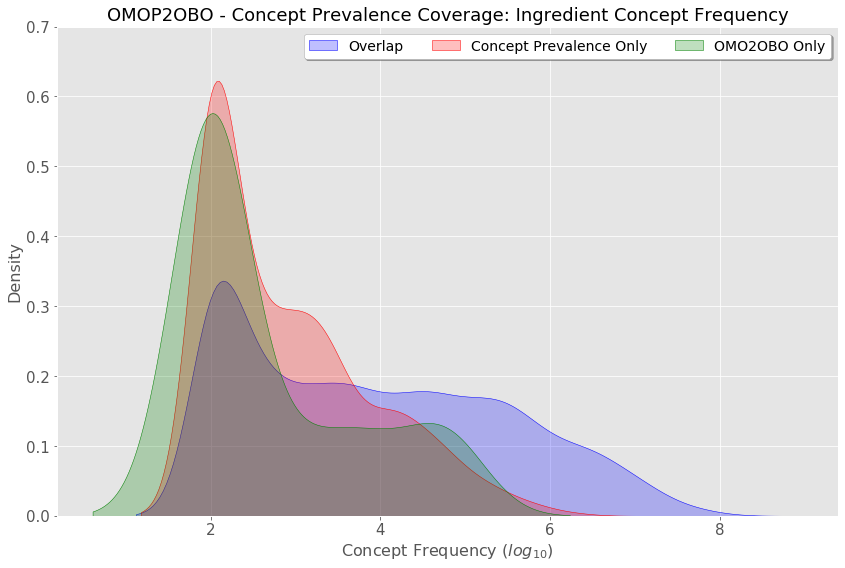

In [102]:
# create histograms
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
y = sns.kdeplot(med_coverage_sets['overlap']['counts'], color='blue', label='Overlap', shade=True)
y = sns.kdeplot(med_coverage_sets['cp_only']['counts'], color='red', label='Concept Prevalence Only', shade=True)
y = sns.kdeplot(med_coverage_sets['omop2obo_only']['counts'], color='green', label='OMO2OBO Only', shade=True)

plt.title('OMOP2OBO - Concept Prevalence Coverage: Ingredient Concept Frequency', fontsize=18)
plt.suptitle('')
plt.xlabel('Concept Frequency ($log_{10}$)', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.ylim(0.0, 0.7)
plt.tick_params(labelsize=15)
plt.legend(title='', fontsize=14, title_fontsize=14, shadow=True, facecolor='white', edgecolor='darkgray', ncol=3)
plt.show()

OVERLAP COVERAGE SET

In [103]:
# get stats on concepts in both sets and by ontology
covered_concepts_omop2obo = med_mappings_standard[med_mappings_standard.CONCEPT_ID.isin(list(overlap_med_concepts))]

# split results by concept type (i.e. concepts used in practice, standard concepts)
med_overlap_res = covered_concepts_omop2obo.groupby('CONCEPT_TYPE')

# re-group by ontology
med_overlap_prac = med_overlap_res.get_group('Concept Used In Practice').drop_duplicates()
med_overlap_stnd = med_overlap_res.get_group('Standard Concept Not Used In Practice').drop_duplicates()

# print the number of overlapping concepts
print('{} OMOP concepts overlapped in OMOP2OBO and the Concept Prevalence data'.format(len(overlap_med_concepts)))


4037 OMOP concepts overlapped in OMOP2OBO and the Concept Prevalence data


***Concepts Used In Clinical Practice***

In [104]:
print('{} overlapping codes for Concepts Used in Practice'.format(len(med_overlap_prac)))

# print mapping categories
med_prac_chebi_cat = med_overlap_prac.groupby('CHEBI_MAPPING').size().reset_index(name='COUNT')
med_prac_pr_cat = med_overlap_prac.groupby('PR_MAPPING').size().reset_index(name='COUNT')
med_prac_ncbitaxon_cat = med_overlap_prac.groupby('NCBITAXON_MAPPING').size().reset_index(name='COUNT')
med_prac_vo_cat = med_overlap_prac.groupby('VO_MAPPING').size().reset_index(name='COUNT')

# create plotting data
overlap_med_prac_data = pd.DataFrame({'ontology': ['CHEBI'] * len(med_prac_chebi_cat) + ['PR'] * len(med_prac_pr_cat) + ['NCBITAXON'] * len(med_prac_ncbitaxon_cat) + ['VO'] * len(med_prac_vo_cat),
                                      'mapping_category': list(med_prac_chebi_cat['CHEBI_MAPPING']) + list(med_prac_pr_cat['PR_MAPPING']) + list(med_prac_ncbitaxon_cat['NCBITAXON_MAPPING']) + list(med_prac_vo_cat['VO_MAPPING']),
                                      'counts': list(np.log10(med_prac_chebi_cat['COUNT'])) + list(np.log10(med_prac_pr_cat['COUNT'])) + list(np.log10(med_prac_ncbitaxon_cat['COUNT'])) + list(np.log10(med_prac_vo_cat['COUNT']))})


1639 overlapping codes for Concepts Used in Practice


In [105]:
# print chebi data
med_prac_chebi_cat

,CHEBI_MAPPING,COUNT
0,Automatic Constructor - Ancestor,59
1,Automatic Constructor - Concept,235
2,Automatic Exact - Ancestor,14
3,Automatic Exact - Concept,955
4,Manual,278
5,Manual Constructor,72
6,Manual Exact - Concept Similarity,26


In [106]:
# print pro data
med_prac_pr_cat

,PR_MAPPING,COUNT
0,Automatic Constructor - Ancestor,2
1,Automatic Exact - Ancestor,5
2,Automatic Exact - Concept,6
3,Manual,188
4,Manual Constructor,5
5,Manual Exact - Concept Similarity,9
6,Unmapped,1424


In [107]:
# print ncbitaxon data
med_prac_ncbitaxon_cat

,NCBITAXON_MAPPING,COUNT
0,Automatic Constructor - Ancestor,2
1,Automatic Exact - Ancestor,22
2,Automatic Exact - Concept,18
3,Manual,262
4,Manual Constructor,9
5,Manual Exact - Concept Similarity,113
6,Unmapped,1213


In [108]:
# print vo data
med_prac_vo_cat

,VO_MAPPING,COUNT
0,Automatic Exact - Concept,90
1,Manual,9
2,Manual Exact - Concept Similarity,5
3,Unmapped,1535


***Standard RxNorm Concepts Not Used In Practice***

In [109]:
print('{} overlapping codes for Standard RxNorm Concepts Not Used in Practice'.format(len(med_overlap_stnd)))

# print mapping categories
med_stnd_chebi_cat = med_overlap_stnd.groupby('CHEBI_MAPPING').size().reset_index(name='COUNT')
med_stnd_pr_cat = med_overlap_stnd.groupby('PR_MAPPING').size().reset_index(name='COUNT')
med_stnd_ncbitaxon_cat = med_overlap_stnd.groupby('NCBITAXON_MAPPING').size().reset_index(name='COUNT')
med_stnd_vo_cat = med_overlap_stnd.groupby('VO_MAPPING').size().reset_index(name='COUNT')

# create plotting data
overlap_med_stnd_data = pd.DataFrame({'ontology': ['CHEBI'] * len(med_stnd_chebi_cat) + ['PR'] * len(med_stnd_pr_cat) + ['NCBITAXON'] * len(med_stnd_ncbitaxon_cat) + ['VO'] * len(med_stnd_vo_cat),
                                      'mapping_category': list(med_stnd_chebi_cat['CHEBI_MAPPING']) + list(med_stnd_pr_cat['PR_MAPPING']) + list(med_stnd_ncbitaxon_cat['NCBITAXON_MAPPING']) + list(med_stnd_vo_cat['VO_MAPPING']),
                                      'counts': list(np.log10(med_stnd_chebi_cat['COUNT'])) + list(np.log10(med_stnd_pr_cat['COUNT'])) + list(np.log10(med_stnd_ncbitaxon_cat['COUNT'])) + list(np.log10(med_stnd_vo_cat['COUNT']))})


2398 overlapping codes for Standard RxNorm Concepts Not Used in Practice


In [110]:
# print chebi data
med_stnd_chebi_cat

,CHEBI_MAPPING,COUNT
0,Automatic Constructor - Ancestor,106
1,Automatic Constructor - Concept,101
2,Automatic Exact - Ancestor,79
3,Automatic Exact - Concept,1157
4,Manual Exact - Concept Similarity,29
5,Unmapped,926


In [111]:
# print pr data
med_stnd_pr_cat

,PR_MAPPING,COUNT
0,Automatic Constructor - Concept,1
1,Automatic Exact - Ancestor,16
2,Automatic Exact - Concept,27
3,Manual Exact - Concept Similarity,2
4,Unmapped,2352


In [112]:
# print ncbitaxon data
med_stnd_ncbitaxon_cat

,NCBITAXON_MAPPING,COUNT
0,Automatic Constructor - Ancestor,1
1,Automatic Exact - Ancestor,10
2,Automatic Exact - Concept,50
3,Manual Exact - Concept Similarity,918
4,Unmapped,1419


In [113]:
# print vo data
med_stnd_vo_cat

,VO_MAPPING,COUNT
0,Automatic Exact - Ancestor,3
1,Automatic Exact - Concept,7
2,Manual Exact - Concept Similarity,4
3,Unmapped,2384


***Plot Counts of Concepts By Mapping Category***

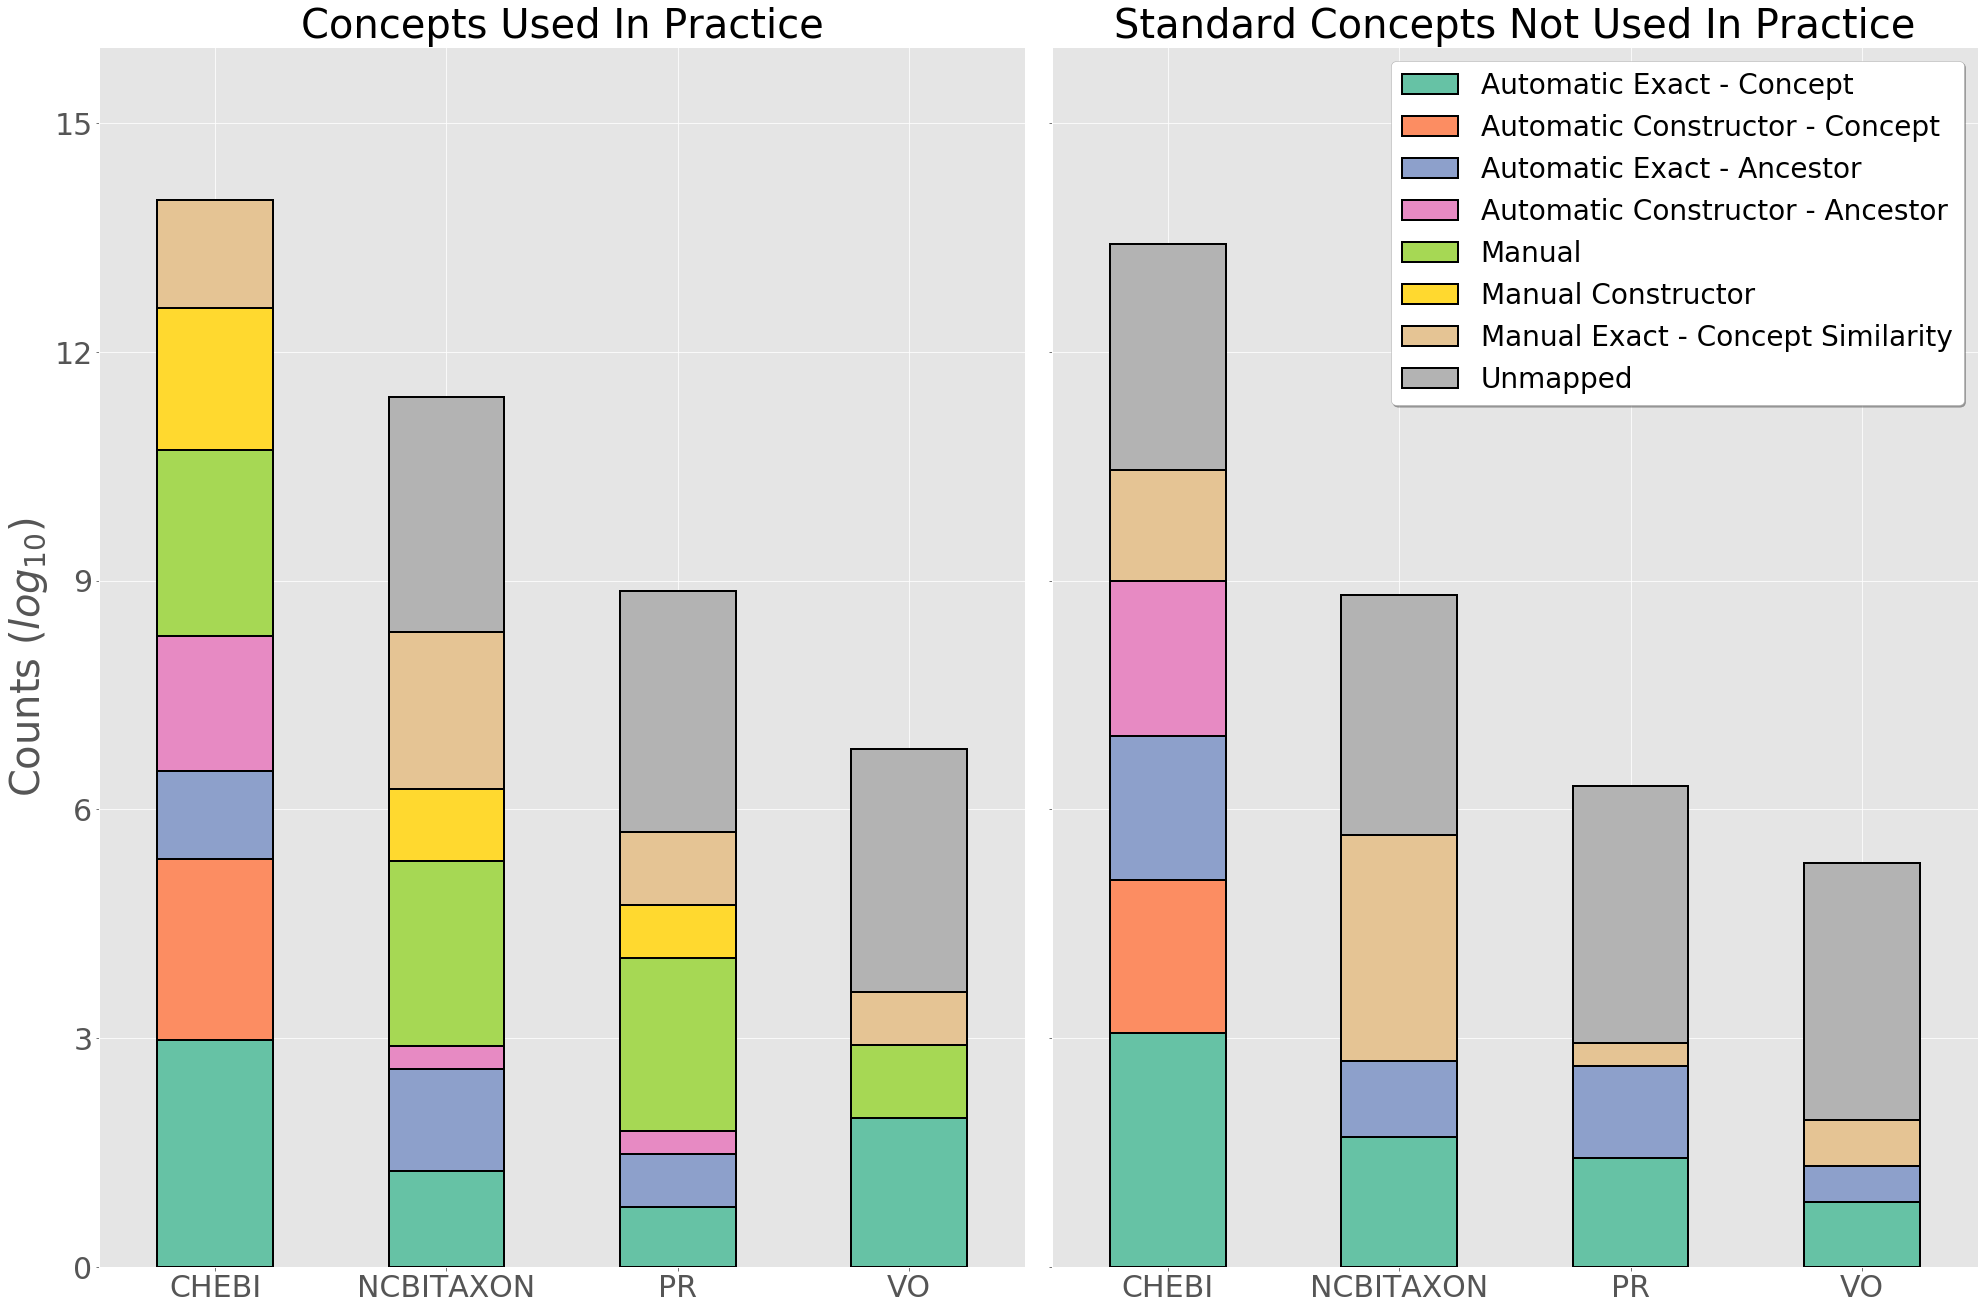

In [115]:
# create plot data
plots = { 'Concepts Used In Practice': overlap_med_prac_data,
         'Standard Concepts Not Used In Practice': overlap_med_stnd_data}

ordering = ['Automatic Exact - Concept', 'Automatic Constructor - Concept',
           'Automatic Exact - Ancestor', 'Automatic Constructor - Ancestor',
            'Manual', 'Manual Constructor', 'Manual Exact - Concept Similarity', 'Unmapped']

# create plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 18))
scale_min, scale_max, scale_step = 0, 16, 3 
xlabel, ylabel = '', 'Counts ($log_{10}$)'
for df, ax in zip(plots.keys(), axes):
    plt_data = plots[df].pivot(index='ontology', columns='mapping_category', values='counts')
    plt_data = plt_data.reindex(ordering, axis=1)
    ax = plt_data.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', linewidth=2, colormap='Set2')
    ax.set_title(df, fontsize=40, alpha=1.0)
    ax.set_ylabel(ylabel, fontsize=40),
    ax.set_xlabel(xlabel, fontsize=40),
    ax.set_ylim(scale_min, scale_max)
    ax.set_yticks(range(scale_min, scale_max, scale_step))
    ax.set_yticklabels(labels=range(scale_min, scale_max, scale_step), rotation=0, minor=False, fontsize=30)
    ax.set_xticklabels(labels=list(plt_data.index), rotation=0, minor=False, fontsize=30)
    handles, labels = ax.get_legend_handles_labels()

# facet into single plot
plt.tight_layout(pad=0.0, w_pad=-6.5, h_pad=0.0)
axes[1].set_ylabel("")
axes[1].set_yticklabels("")
axes[0].legend().set_visible(False)
axes[1].legend(ordering, fontsize=28, shadow=True, facecolor='white', edgecolor='darkgray', ncol=1)

plt.show()


OMOP2OBO ONLY COVERAGE SET

In [116]:
# get stats on concepts in both sets and by ontology
omop2obo_only_concepts = med_mappings_standard[med_mappings_standard.CONCEPT_ID.isin(list(only_omop2obo_med_concepts))]

# split results by concept type (i.e. concepts used in practice, standard concepts)
med_omop2obo_res = omop2obo_only_concepts.groupby('CONCEPT_TYPE')

# re-group by ontology
med_omop2obo_prac = med_omop2obo_res.get_group('Concept Used In Practice').drop_duplicates()
med_omop2obo_stnd = med_omop2obo_res.get_group('Standard Concept Not Used In Practice').drop_duplicates()

# print the number of overlapping concepts
print('{} OMOP concepts Only Found in OMOP2OBO'.format(len(omop2obo_only_concepts)))

4578 OMOP concepts Only Found in OMOP2OBO


***Concepts Used In Practice***

In [117]:
print('{} overlapping codes for Concepts Used in Practice'.format(len(med_omop2obo_prac)))

# print mapping categories
med_prac_chebi_cat = med_omop2obo_prac.groupby('CHEBI_MAPPING').size().reset_index(name='COUNT')
med_prac_pr_cat = med_omop2obo_prac.groupby('PR_MAPPING').size().reset_index(name='COUNT')
med_prac_ncbitaxon_cat = med_omop2obo_prac.groupby('NCBITAXON_MAPPING').size().reset_index(name='COUNT')
med_prac_vo_cat = med_omop2obo_prac.groupby('VO_MAPPING').size().reset_index(name='COUNT')

# create plotting data
omop2obo_only_med_prac_data = pd.DataFrame({'ontology': ['CHEBI'] * len(med_prac_chebi_cat) + ['PR'] * len(med_prac_pr_cat) + ['NCBITAXON'] * len(med_prac_ncbitaxon_cat) + ['VO'] * len(med_prac_vo_cat),
                                            'mapping_category': list(med_prac_chebi_cat['CHEBI_MAPPING']) + list(med_prac_pr_cat['PR_MAPPING']) + list(med_prac_ncbitaxon_cat['NCBITAXON_MAPPING']) + list(med_prac_vo_cat['VO_MAPPING']),
                                            'counts': list(np.log10(med_prac_chebi_cat['COUNT'])) + list(np.log10(med_prac_pr_cat['COUNT'])) + list(np.log10(med_prac_ncbitaxon_cat['COUNT'])) + list(np.log10(med_prac_vo_cat['COUNT']))})


58 overlapping codes for Concepts Used in Practice


In [118]:
# print chebi data
med_prac_chebi_cat

,CHEBI_MAPPING,COUNT
0,Automatic Constructor - Ancestor,2
1,Automatic Exact - Ancestor,3
2,Automatic Exact - Concept,4
3,Manual,40
4,Manual Constructor,4
5,Manual Exact - Concept Similarity,5


In [119]:
# print pro data
med_prac_pr_cat

,PR_MAPPING,COUNT
0,Manual,26
1,Manual Constructor,2
2,Unmapped,30


In [120]:
# print ncbitaxon data
med_prac_ncbitaxon_cat

,NCBITAXON_MAPPING,COUNT
0,Automatic Exact - Concept,2
1,Manual,12
2,Manual Constructor,3
3,Manual Exact - Concept Similarity,23
4,Unmapped,18


In [121]:
# print vo data
med_prac_vo_cat

,VO_MAPPING,COUNT
0,Automatic Constructor - Ancestor,2
1,Automatic Exact - Concept,2
2,Manual,16
3,Manual Constructor,2
4,Unmapped,36


***Standard RxNorm Concepts Not Used In Practice***

In [122]:
print('{} OMOP2OBO only codes for Standard RxNorm Concepts Not Used in Practice'.format(len(med_omop2obo_stnd)))

# print mapping categories
med_stnd_chebi_cat = med_omop2obo_stnd.groupby('CHEBI_MAPPING').size().reset_index(name='COUNT')
med_stnd_pr_cat = med_omop2obo_stnd.groupby('PR_MAPPING').size().reset_index(name='COUNT')
med_stnd_ncbitaxon_cat = med_omop2obo_stnd.groupby('NCBITAXON_MAPPING').size().reset_index(name='COUNT')
med_stnd_vo_cat = med_omop2obo_stnd.groupby('VO_MAPPING').size().reset_index(name='COUNT')

# create plotting data
omop2obo_only_med_stnd_data = pd.DataFrame({'ontology': ['CHEBI'] * len(med_stnd_chebi_cat) + ['PR'] * len(med_stnd_pr_cat) + ['NCBITAXON'] * len(med_stnd_ncbitaxon_cat) + ['VO'] * len(med_stnd_vo_cat),
                                            'mapping_category': list(med_stnd_chebi_cat['CHEBI_MAPPING']) + list(med_stnd_pr_cat['PR_MAPPING']) + list(med_stnd_ncbitaxon_cat['NCBITAXON_MAPPING']) + list(med_stnd_vo_cat['VO_MAPPING']),
                                            'counts': list(np.log10(med_stnd_chebi_cat['COUNT'])) + list(np.log10(med_stnd_pr_cat['COUNT'])) + list(np.log10(med_stnd_ncbitaxon_cat['COUNT'])) + list(np.log10(med_stnd_vo_cat['COUNT']))})

4520 OMOP2OBO only codes for Standard RxNorm Concepts Not Used in Practice


In [123]:
# print chebi data
med_stnd_chebi_cat

,CHEBI_MAPPING,COUNT
0,Automatic Constructor - Ancestor,43
1,Automatic Constructor - Concept,68
2,Automatic Exact - Ancestor,51
3,Automatic Exact - Concept,1035
4,Manual Exact - Concept Similarity,49
5,Unmapped,3274


In [124]:
# print pr data
med_stnd_pr_cat

,PR_MAPPING,COUNT
0,Automatic Exact - Ancestor,3
1,Automatic Exact - Concept,15
2,Manual Exact - Concept Similarity,8
3,Unmapped,4494


In [125]:
# print ncbitaxon data
med_stnd_ncbitaxon_cat

,NCBITAXON_MAPPING,COUNT
0,Automatic Constructor - Concept,1
1,Automatic Exact - Ancestor,4
2,Automatic Exact - Concept,85
3,Manual Exact - Concept Similarity,3187
4,Unmapped,1243


In [126]:
# print vo data
med_stnd_vo_cat

,VO_MAPPING,COUNT
0,Automatic Exact - Ancestor,1
1,Automatic Exact - Concept,11
2,Manual Exact - Concept Similarity,10
3,Unmapped,4498


***Plot Counts of Concepts By Mapping Category***

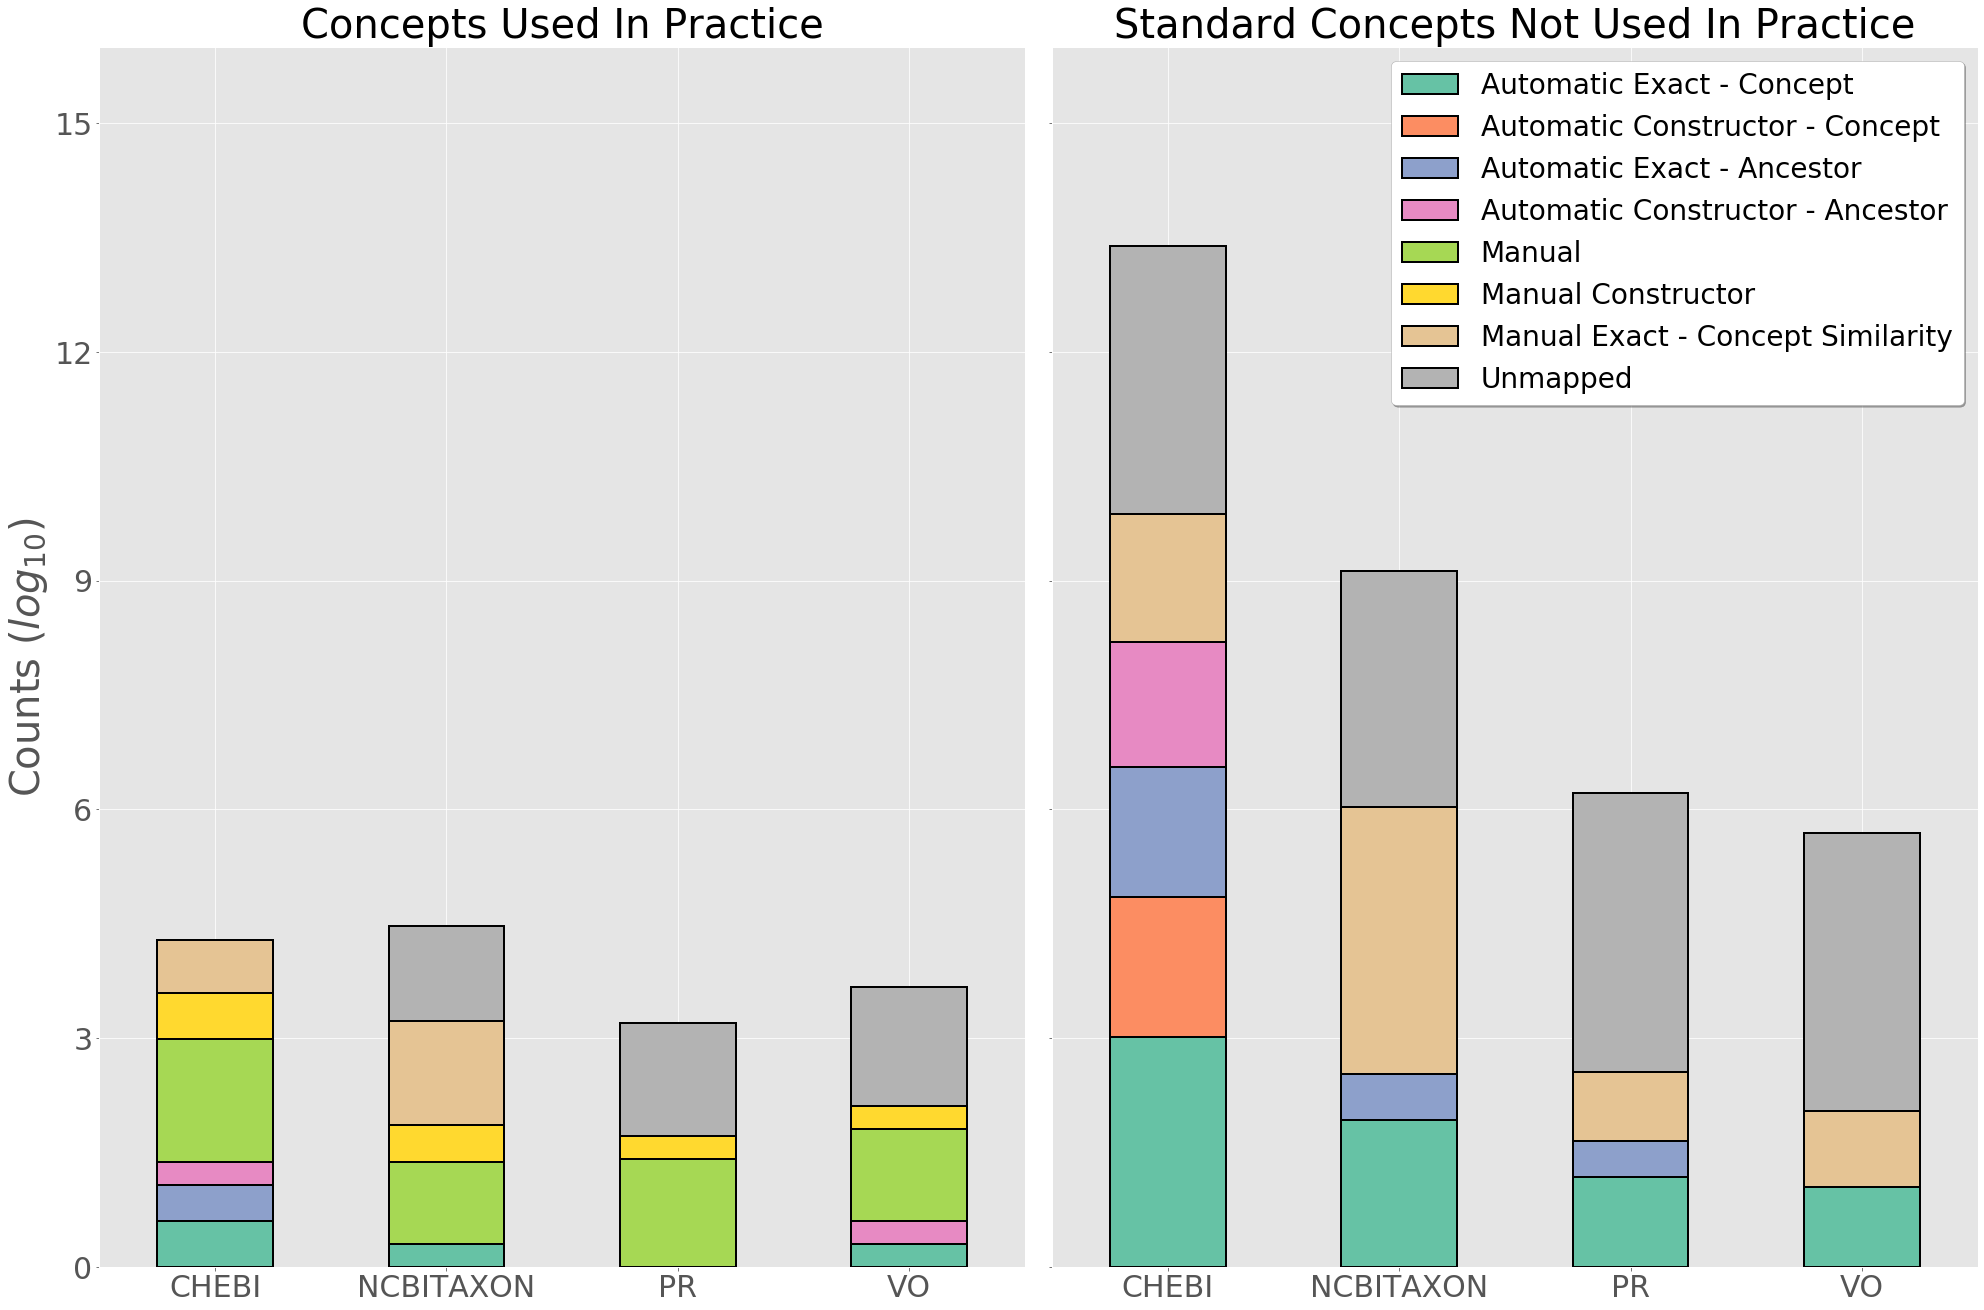

In [127]:
# create plot data
plots = { 'Concepts Used In Practice': omop2obo_only_med_prac_data,
         'Standard Concepts Not Used In Practice': omop2obo_only_med_stnd_data}

ordering = ['Automatic Exact - Concept', 'Automatic Constructor - Concept',
           'Automatic Exact - Ancestor', 'Automatic Constructor - Ancestor',
            'Manual', 'Manual Constructor', 'Manual Exact - Concept Similarity', 'Unmapped']

# create plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 18))
scale_min, scale_max, scale_step = 0, 16, 3 
xlabel, ylabel = '', 'Counts ($log_{10}$)'
for df, ax in zip(plots.keys(), axes):
    plt_data = plots[df].pivot(index='ontology', columns='mapping_category', values='counts')
    plt_data = plt_data.reindex(ordering, axis=1)
    ax = plt_data.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', linewidth=2, colormap='Set2')
    ax.set_title(df, fontsize=40, alpha=1.0)
    ax.set_ylabel(ylabel, fontsize=40),
    ax.set_xlabel(xlabel, fontsize=40),
    ax.set_ylim(scale_min, scale_max)
    ax.set_yticks(range(scale_min, scale_max, scale_step))
    ax.set_yticklabels(labels=range(scale_min, scale_max, scale_step), rotation=0, minor=False, fontsize=30)
    ax.set_xticklabels(labels=list(plt_data.index), rotation=0, minor=False, fontsize=30)
    handles, labels = ax.get_legend_handles_labels()

# facet into single plot
plt.tight_layout(pad=0.0, w_pad=-6.5, h_pad=0.0)
axes[1].set_ylabel("")
axes[1].set_yticklabels("")
axes[0].legend().set_visible(False)
axes[1].legend(ordering, fontsize=28, shadow=True, facecolor='white', edgecolor='darkgray', ncol=1)

plt.show()

ERROR ANALYSIS   
The goal of the error analysis was to try and explain the `OMOP2OBO` concepts that were not found in the `Concept Prevalence` data. For this analysis, we group the `551` OMOP concepts not covered by the `OMOP2OBO` mapping set into three groups:  
1. **Error Analysis Concepts:** missing concepts found in a current version of the `OMOP` Common Data Model  
2. **Excluded Concepts:** missing concepts that are in the original mapping data, but were excluded from the final mapping set (see [here](#coverage-drugs) for more details)  
3. **Truly Missing Concepts:** missing concepts that cannot be explained by other data sources.

In [128]:
# 551 total concepts in CP not included in OMOP2OBO
med_error_analysis = process_error_analysis_data(error_analysis, only_cp_med_concepts, med_mappings,
                                                  med_mappings_standard, concept_prev_meds)

# find not covered concepts in error analysis data (n=5)
med_error_analysis_concepts_data = med_error_analysis[0]

# find not covered concepts in excluded condition mapping data (n=456)
med_filtered_concepts_data = med_error_analysis[1]

# remaining not covered concepts (n=90)
med_true_not_covered_concepts_data = med_error_analysis[2]

# print the results
print('Of the {} concepts not covered by OMOP2OBO:\n  - {} are in the Error Analysis data\n  - {} are in the excluded condition map set data\n  - {} are truly not covered'.format(len(only_cp_med_concepts),
                                                                                                                                                                                   len(set(med_error_analysis_concepts_data['TARGET_CONCEPT_ID'])),
                                                                                                                                                                                   len(set(med_filtered_concepts_data['CONCEPT_ID'])),
                                                                                                                                                                                   len(set(med_true_not_covered_concepts_data['CONCEPT_ID']))))

Of the 551 concepts not covered by OMOP2OBO:
  - 5 are in the Error Analysis data
  - 456 are in the excluded condition map set data
  - 90 are truly not covered


In [129]:
# convert data frames into dictionaries
# create a list of databases
med_dbs = [concept_prev_meds, med_mappings, med_mappings_standard]

# find not covered concepts in error analysis data (n=5)
med_error_analysis_dict = classifies_missing_concepts(med_error_analysis_concepts_data, ingredient_onts, 'TARGET_CONCEPT_ID', 'error', med_dbs)

# find not covered concepts in excluded condition mapping data (n=456)
med_filtered_concepts_dict = classifies_missing_concepts(med_filtered_concepts_data, ingredient_onts, 'CONCEPT_ID', 'excluded', med_dbs)

# remaining not covered concepts (n=90)
med_tp_not_covered_dict = classifies_missing_concepts(med_true_not_covered_concepts_data, ingredient_onts, 'CONCEPT_ID', 'missing', med_dbs)

100%|██████████| 90/90 [00:00<00:00, 133.83it/s]


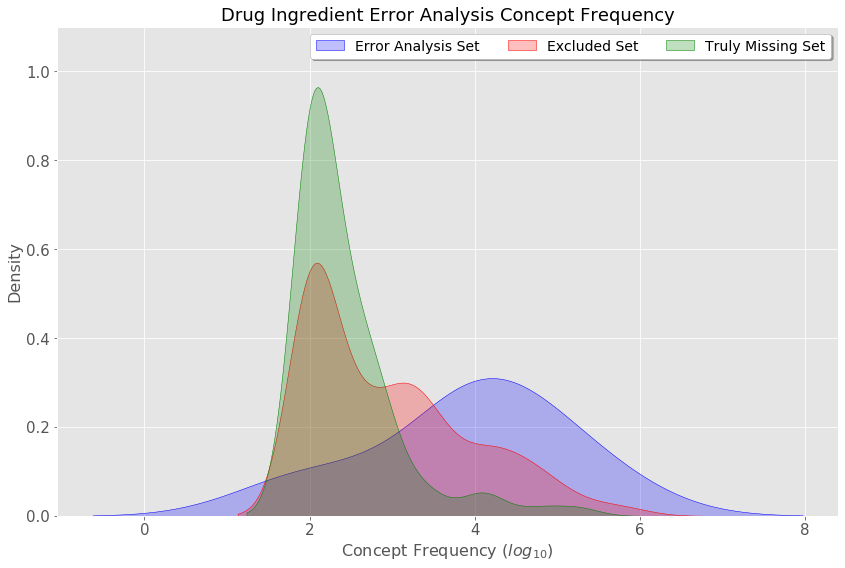

In [130]:
# process count data
med_error_analysis_counts = [statistics.mean(med_error_analysis_dict['error'][x]['counts']) for x in med_error_analysis_dict['error'].keys()]
med_filtered_counts = [statistics.mean(med_filtered_concepts_dict['excluded'][x]['counts']) for x in med_filtered_concepts_dict['excluded'].keys()]
med_missing_counts = [statistics.mean(med_tp_not_covered_dict['missing'][x]['counts']) for x in med_tp_not_covered_dict['missing'].keys()]

# create plot data
plt_data = pd.DataFrame({'set':['Error Analysis Set'] * len(med_error_analysis_counts) + ['Excluded Set'] * len(med_filtered_counts) + ['Truly Missing Set'] * len(med_missing_counts),
                        'counts': np.log10(med_error_analysis_counts).tolist() + np.log10(med_filtered_counts).tolist() + np.log10(med_missing_counts).tolist()})

# create histograms
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
y = sns.kdeplot(np.log10(med_error_analysis_counts).tolist(), color='blue', label='Error Analysis Set', shade=True)
y = sns.kdeplot(np.log10(med_filtered_counts).tolist(), color='red', label='Excluded Set', shade=True)
y = sns.kdeplot(np.log10(med_missing_counts).tolist(), color='green', label='Truly Missing Set', shade=True)

plt.title('Drug Ingredient Error Analysis Concept Frequency', fontsize=18)
plt.suptitle('')
plt.xlabel('Concept Frequency ($log_{10}$)', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.ylim(0.0, 1.1)
plt.tick_params(labelsize=15)
plt.legend(title='', fontsize=14, title_fontsize=14, shadow=True, facecolor='white', edgecolor='darkgray', ncol=3)
plt.show()


***Error Analysis Concepts***

In [131]:
# get counts of error analysis types (i.e. newly added concept or replaced concept)
med_source_concepts, med_relationship_types = [], []
for x in med_error_analysis_dict['error'].keys():
    for y in med_error_analysis_dict['error'][x]['evidence'].keys():
        if y != 'master_evidence':
            med_source_concepts.append(y)
            med_relationship_types.append(med_error_analysis_dict['error'][x]['evidence'][y]['relation']) 

# get counts of relationship ids
med_error_analysis_types = Counter(med_relationship_types)

print('The {} missing concepts account can be mapped to {} source concepts using the following relations:'.format(len(med_error_analysis_dict['error'].keys()),
                                                                                                                 len(med_source_concepts)))
print('  - ' + '\n  - '.join(['{}: {}'.format(x[0], x[1]) for x in med_error_analysis_types.items()]))

The 5 missing concepts account can be mapped to 6 source concepts using the following relations:
  - Maps to: 6


In [132]:
med_error_analysis_dbs = [med_error_analysis_dict['error'][x]['dbs'] for x in med_error_analysis_dict['error'].keys()]
med_error_analysis_count = [statistics.mean(med_error_analysis_dict['error'][x]['counts']) for x in med_error_analysis_dict['error'].keys()]

print('Database site concept occurrence: {} min, {} mean, {} max'.format(min(med_error_analysis_dbs), round(statistics.mean(med_error_analysis_dbs), 3), max(med_error_analysis_dbs)))
print('Concept Frequency information: {} min, {} mean, {} max'.format(min(med_error_analysis_count), round(statistics.mean(med_error_analysis_count), 3), max(med_error_analysis_count)))

Database site concept occurrence: 1 min, 8.4 mean, 14 max
Concept Frequency information: 100 min, 51732.035 mean, 221229.7142857143 max


***Excluded Concepts***

In [133]:
med_evidence_types = [med_filtered_concepts_dict['excluded'][x]['evidence'] for x in med_filtered_concepts_dict['excluded'].keys()]

med_evidence_type_list = []
for x in med_evidence_types:
    key = [i for i in x.keys() if i != 'master_evidence']
    for y in key:
        med_evidence_type_list.append(tuple(x[y]['evidence']))

# get counts of each tye of evidence        
med_evidence = Counter(med_evidence_type_list)

print('Of the {} missing variables found in the excluded data frame:\n  - {}'.format(len(med_filtered_concepts_dict['excluded'].keys()),
                                                                                     '\n  - '.join([str(x[1]) + ' ' + '-'.join(x[0]) for x in med_evidence.items()])))

Of the 456 missing variables found in the excluded data frame:
  - 456 CHEBI:NOT YET MAPPED-PR:NOT YET MAPPED-NCBITAXON:NOT YET MAPPED-VO:NOT YET MAPPED


In [134]:
med_excluded_analysis_dbs = [med_filtered_concepts_dict['excluded'][x]['dbs'] for x in med_filtered_concepts_dict['excluded'].keys()]
med_excluded_analysis_count = [statistics.mean(med_filtered_concepts_dict['excluded'][x]['counts']) for x in med_filtered_concepts_dict['excluded'].keys()]

print('Database site concept occurrence: {} min, {} mean, {} max'.format(min(med_excluded_analysis_dbs), statistics.mean(med_excluded_analysis_dbs), max(med_excluded_analysis_dbs)))
print('Concept Frequency information: {} min, {} mean, {} max'.format(min(med_excluded_analysis_count), statistics.mean(med_excluded_analysis_count), max(med_excluded_analysis_count)))

Database site concept occurrence: 1 min, 3.883771929824561 mean, 18 max
Concept Frequency information: 100 min, 18847.280843721088 mean, 1077258.9 max


***Truly Missing Concepts***

In [135]:
# freq_dict = {tp_not_covered_dict['missing'][x]['avg_count']: str(x) + ':' + tp_not_covered_dict['missing'][x]['evidence'] for x in tp_not_covered_dict['missing'].keys()}
med_counts, med_dbs, med_concepts = [], [], []
for x in med_tp_not_covered_dict['missing'].keys():
    for y in med_tp_not_covered_dict['missing'][x]:
        for z in med_tp_not_covered_dict['missing'][x]['evidence'].keys():
            if z != 'master_evidence':
                med_counts.append(statistics.mean(med_tp_not_covered_dict['missing'][x]['counts']))
                med_dbs.append(med_tp_not_covered_dict['missing'][x]['dbs'])
                med_concepts.append(str(x) + ': ' + med_tp_not_covered_dict['missing'][x]['evidence'][z]['evidence'])

# create Pandas DataFrame
med_truly_mising_df = pd.DataFrame({'Concept Frequency': med_counts, 'Database Count': med_dbs, 'Concept': med_concepts}).drop_duplicates()
                
# print missing concepts sorted descending by concept frequency
med_truly_mising_df = med_truly_mising_df.sort_values(['Concept Frequency', 'Database Count'], ascending=False)
med_truly_mising_df.head(n=20)

,Concept Frequency,Database Count,Concept
147,175551.286,14,37498625: hepatitis A virus strain CR 326F ant...
36,60618.000,10,1510467: erenumab
33,15579.600,5,35200577: fremanezumab
168,11594.800,5,35200800: galcanezumab
42,11366.667,3,35201105: baloxavir marboxil
207,2940.000,1,37498244: ubrogepant
18,2610.167,6,1560104: elagolix
69,1976.000,1,37498993: Rimegepant
3,1050.500,4,1510417: cannabidiol
195,977.000,1,35200881: sarecycline


In [136]:
med_tp_analysis_dbs = [med_tp_not_covered_dict['missing'][x]['dbs'] for x in med_tp_not_covered_dict['missing'].keys()]
med_tp_analysis_count = [statistics.mean(med_tp_not_covered_dict['missing'][x]['counts']) for x in med_tp_not_covered_dict['missing'].keys()]

print('Database site concept occurrence: {} min, {} mean, {} max'.format(min(med_tp_analysis_dbs), statistics.mean(med_tp_analysis_dbs), max(med_tp_analysis_dbs)))
print('Concept Frequency information: {} min, {} mean, {} max'.format(min(med_tp_analysis_count), statistics.mean(med_tp_analysis_count), max(med_tp_analysis_count)))

Database site concept occurrence: 1 min, 2.6555555555555554 mean, 14 max
Concept Frequency information: 100 min, 3361.150998075998 mean, 175551.2857142857 max


#### DATA SITE COVERAGE<a class="anchor" id="drug-data-site-coverage"></a>    
This phase of the experiment aimed to demonstrate the coverage of the `OMOP2OBO` condition occurrence concepts for each `Concept Prevalence` study site. Across the `Concept Prevalence` study sites, coverage ranged from `91.23-98.35%`. A Chi-Square test of independence was run to determine if coverage available differed by database. First, an omnibus test was run to determine whether there was a significant relationship between database and coverage. Results from this test (with Yate's correction) revealed a significant association between the database and coverage ($X^{2}(17)=195.640$, $p<0.0001$). In order to better understand these findings, post-hoc tests were run using a Bonferroni adjustment to correct for multiple comparisons. These tests confirmed that `53` of the `153` database comparisons had significantly different coverage ($ps<0.001$).

In [137]:
# Get concept coverage by database
meds_coverage_dict = gets_group_stats(concept_prev_meds.copy(), med_mappings_standard.copy(), 'DATABASE_NAME', 'CONCEPT_ID')

# create contingency table
dbs = list(meds_coverage_dict.keys())
db_covered = [len(meds_coverage_dict[j]['overlap'].keys()) for j in dbs]
db_not_covered = [len(meds_coverage_dict[j]['primary_only'].keys()) for j in dbs]

# convert to Pandas DataFrame
meds_coverage_df = pd.DataFrame({'Database': dbs, 'Covered': db_covered, 'Not Covered': db_not_covered})

# calculate coverage 
meds_coverage_df['% Coverage'] = round(meds_coverage_df['Covered']/(meds_coverage_df['Covered'] + meds_coverage_df['Not Covered'])*100, 3)

# view table
meds_coverage_df.sort_values('% Coverage', ascending=False)


100%|██████████| 18/18 [00:00<00:00, 204.42it/s]

Processing 18 Database groups



,Database,Covered,Not Covered,% Coverage
13,Stanford,1369,23,98.348
16,ePBRN_OMOP_CDM53_V3a_NOV_2017,943,21,97.822
12,Pscanner,1030,25,97.630
1,Australia_JJ,1210,51,95.956
7,JMDC,1348,64,95.467
17,ohdsi_cumc_deid_2018q4,2043,109,94.935
2,DA_Germany,2442,131,94.909
11,PREMIER,1061,60,94.648
5,IBM_MDCD,1865,116,94.144
6,IBM_MDCR,1802,115,94.001


***Plot Coverage by Concept Prevalence Study Site***

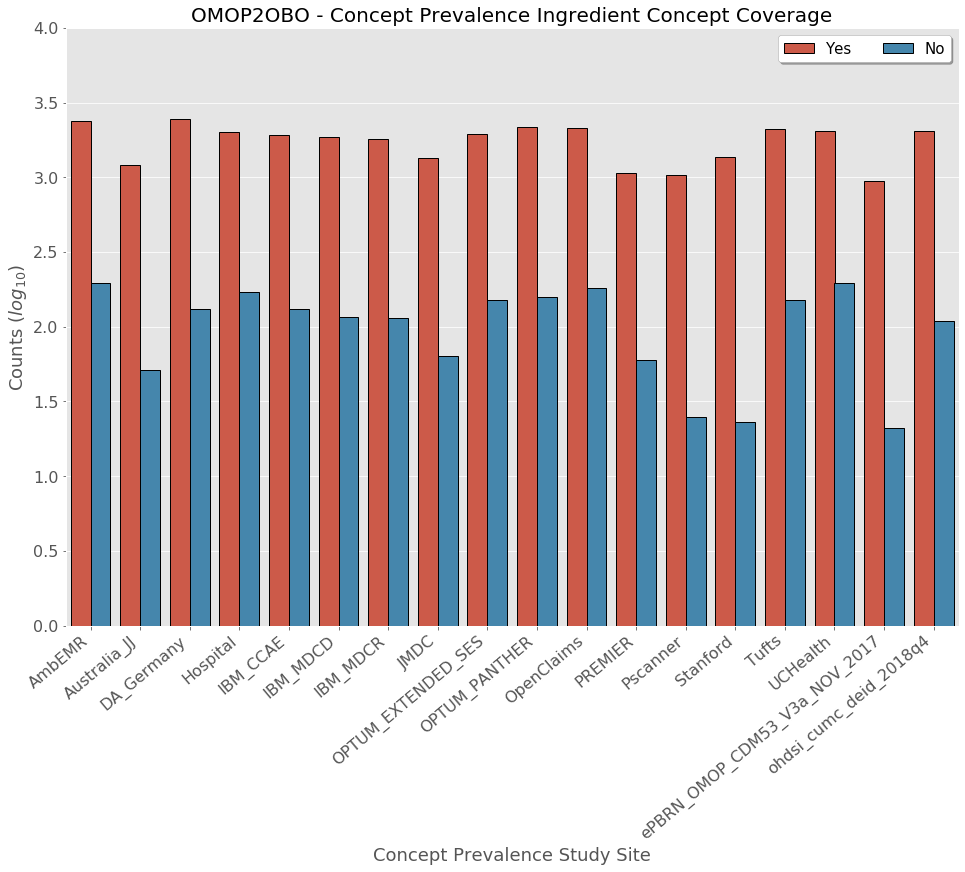

In [138]:
# create plotting data
db_names = dbs * 2
db_coverage = ['Yes'] * len(db_covered) + ['No'] * len(db_not_covered)
db_coverage_counts = np.log10(db_covered + db_not_covered).tolist()

# convert to Pandas DataFrame
meds_cov_df = pd.DataFrame({'Database': db_names, 'Coverage': db_coverage, 'Counts': db_coverage_counts})

# generate bar plot
fig, ax = plt.subplots(1, 1, figsize=(16, 11))

g = sns.barplot(data=meds_cov_df, x='Database', y='Counts', hue="Coverage", edgecolor='black', linewidth=1)
# g = sns.barplot(data=ontology_counts, x='ontology', y='counts', hue="metadata",
#                 palette=sns.color_palette('gray', 4), edgecolor='black', linewidth=1)
g.set_xticklabels(g.get_xticklabels(), rotation=40, horizontalalignment='right')

# set plot label information
plt.ylim(0, 4.0)
plt.title('OMOP2OBO - Concept Prevalence Ingredient Concept Coverage', fontsize=20)
plt.xlabel('Concept Prevalence Study Site', fontsize=18)
plt.ylabel('Counts ($log_{10}$)', fontsize=18)
plt.tick_params(labelsize=16)
plt.legend(title='', fontsize=15, title_fontsize=14,
           shadow=True, facecolor='white', edgecolor='darkgray', ncol=3)

plt.show()

***Chi-Square Test***  

In [139]:
# reformat data to create contingency table
dbs = list(meds_coverage_dict.keys())
db_names = [[j] * (len(meds_coverage_dict[j]['overlap'].keys()) + len(meds_coverage_dict[j]['primary_only'].keys())) for j in dbs]
res = [['Yes'] * len(meds_coverage_dict[j]['overlap'].keys()) + ['No'] * len(meds_coverage_dict[j]['primary_only'].keys()) for j in dbs]

# create df
df = pd.DataFrame({'database': [x for y in db_names for x in y], 'coverage': [x for y in res for x in y]})

# create cross-tab view
df_cross = pd.crosstab(df['database'], df['coverage'])

# perform post hoc analysis adjusting applying multiple comparisons correction
# other correction types availabel here: https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
result = chisq_and_posthoc_corrected(df_cross, 'bonferroni')

# group results by outcome
chi_res = result.groupby('reject_h0')
chi_diff = chi_res.get_group(True).drop_duplicates()
chi_same = chi_res.get_group(False).drop_duplicates()

Chi-Square Omnibus Test Results: Test statistic: 195.63972818502666, df: 17, p-value: 2.1509759066312721e-32
Performing post hoc testing using: bonferroni p-value correction method


Create Heatmap to view Study Site Comparisons

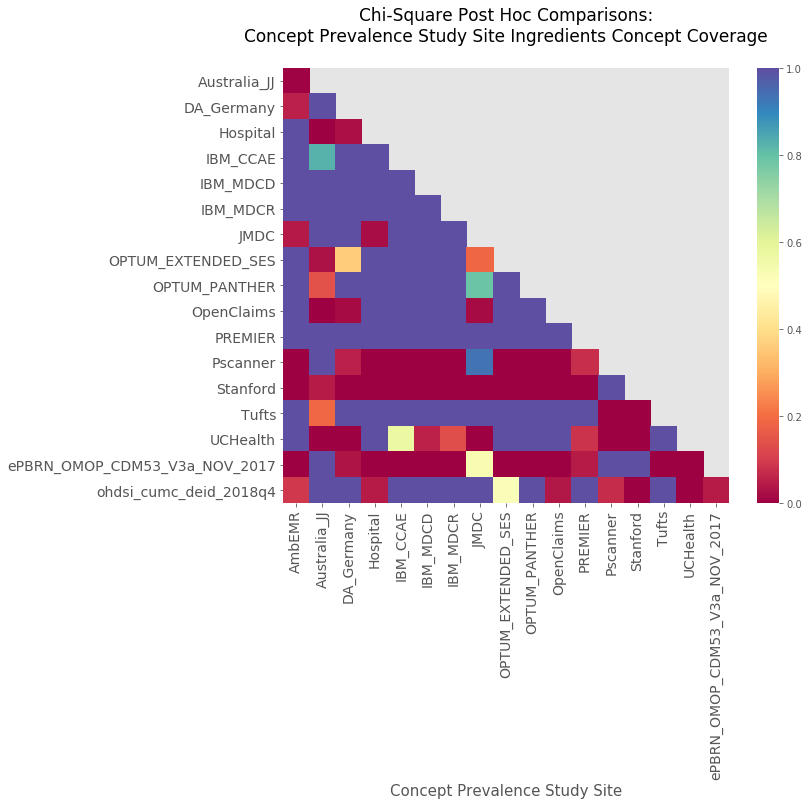

In [140]:
# reformat data and create heat map
result_df = result.copy()

# split comparison column names and add as separate columns
row_names = [x.split('-')[0] for x in list(result_df['comparison'])]
col_names = [x.split('-')[1] for x in list(result_df['comparison'])]
result_df['comparison1'] = row_names
result_df['comparison2'] = col_names

# drop uneeded columns
result_df = result_df.drop(columns=['comparison', 'original_pvalue', 'reject_h0'], axis=1)

# reformat data
res_plot = result_df.pivot(index='comparison2', columns='comparison1', values='corrected_pvalue')

# create heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
g = sns.heatmap(res_plot, annot = False, cmap='Spectral')
# set plot label information
plt.title('Chi-Square Post Hoc Comparisons:\nConcept Prevalence Study Site Ingredients Concept Coverage\n', fontsize=17)
plt.xlabel('Concept Prevalence Study Site', fontsize=15)
plt.ylabel('', fontsize=18)
plt.tick_params(labelsize=14)

plt.show()

***OMOP2OBO Overlap Concept Frequency***  
This section examines the frequency of concepts that occurs in both the `OMOP2OBO` map and the `Concept Prevalence` study sites.

In [141]:
# get range of concept frequency for codes in omop2obo and cp
both_covered, both_plt = [], []

for grp in meds_coverage_dict.keys(): 
    overlap = meds_coverage_dict[grp]['overlap'].values()    
    both_covered.append([grp, min(overlap), max(overlap), statistics.median(overlap)])
    both_plt.append([[grp] * len(overlap), overlap])

# create pandas df
med_covered = pd.DataFrame({'database': [x[0] for x in both_covered],
                            'min_freq': [x[1] for x in both_covered],
                            'max_freq': [x[2] for x in both_covered],
                            'median_freq': [x[3] for x in both_covered]})

In [142]:
med_covered.sort_values(['median_freq', 'max_freq'], ascending=False)

,database,min_freq,max_freq,median_freq
11,PREMIER,100,441161533,417479.000
10,OpenClaims,100,1308580305,253942.000
4,IBM_CCAE,100,162747224,52422.000
9,OPTUM_PANTHER,100,180311533,51788.500
8,OPTUM_EXTENDED_SES,100,107283459,47690.500
7,JMDC,100,23754385,25718.000
3,Hospital,100,158099597,18838.500
5,IBM_MDCD,100,45348432,14951.000
6,IBM_MDCR,100,44057951,12290.500
0,AmbEMR,100,58299592,9849.500


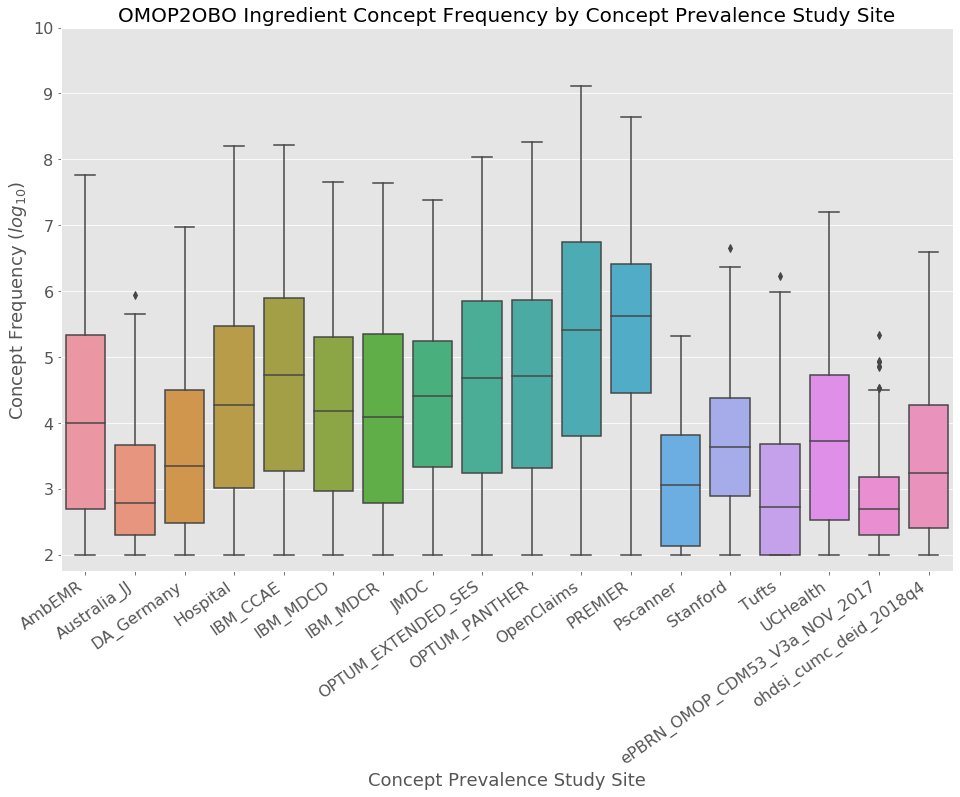

In [143]:
# create plot data
overlap_covered = pd.DataFrame({'database': [x for y in both_plt for x in y[0]],
                                'concept_frequency': [math.log10(x) for y in both_plt for x in y[1]]})

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
sboxplot = sns.boxplot(y='concept_frequency', x='database', data=overlap_covered)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=35, horizontalalignment='right')
plt.title('OMOP2OBO Ingredient Concept Frequency by Concept Prevalence Study Site', fontsize=20)
plt.suptitle("")
plt.ylim(1.75, 10)
plt.xlabel('Concept Prevalence Study Site', fontsize=18)
plt.ylabel('Concept Frequency ($log_{10}$)', fontsize=18)
plt.tick_params(labelsize=16)
plt.show()

***OMOP2OBO Missing Concept Frequency***   
This section examines the frequency of concepts that occur in the `Concept Prevalence` study sites, but not the `OMOP2OBO` map.

In [144]:
# get range of concept frequency for codes not covered by OMOP2OBO
cp_not_covered, cp_not_plt = [], []

for grp in meds_coverage_dict.keys(): 
    # cp not in omop2obo
    cp_not = meds_coverage_dict[grp]['primary_only'].values()    
    cp_not_covered.append([grp, min(cp_not), max(cp_not), statistics.median(cp_not)])
    cp_not_plt.append([[grp] * len(cp_not), cp_not])

# create pandas df
med_cp_not_covered = pd.DataFrame({'database': [x[0] for x in cp_not_covered],
                                   'min_freq': [x[1] for x in cp_not_covered],
                                   'max_freq': [x[2] for x in cp_not_covered],
                                   'median_freq': [x[3] for x in cp_not_covered]})

In [145]:
# concepts not covered by OMOP2OBO
med_cp_not_covered.sort_values(['median_freq', 'max_freq'], ascending=False)

# {k: v for k, v in sorted(conds_coverage_dict['OpenClaims']['primary_only'].items(), key=lambda item: item[1], reverse=True)}

,database,min_freq,max_freq,median_freq
7,JMDC,100,1396485,2517.500
3,Hospital,100,512801,1728.000
10,OpenClaims,100,5185035,1462.500
13,Stanford,108,150549,1120.000
4,IBM_CCAE,100,326406,1096.000
11,PREMIER,100,10748492,602.000
9,OPTUM_PANTHER,100,1339873,521.000
2,DA_Germany,100,848424,500.000
8,OPTUM_EXTENDED_SES,100,850865,453.500
6,IBM_MDCR,100,437780,296.000


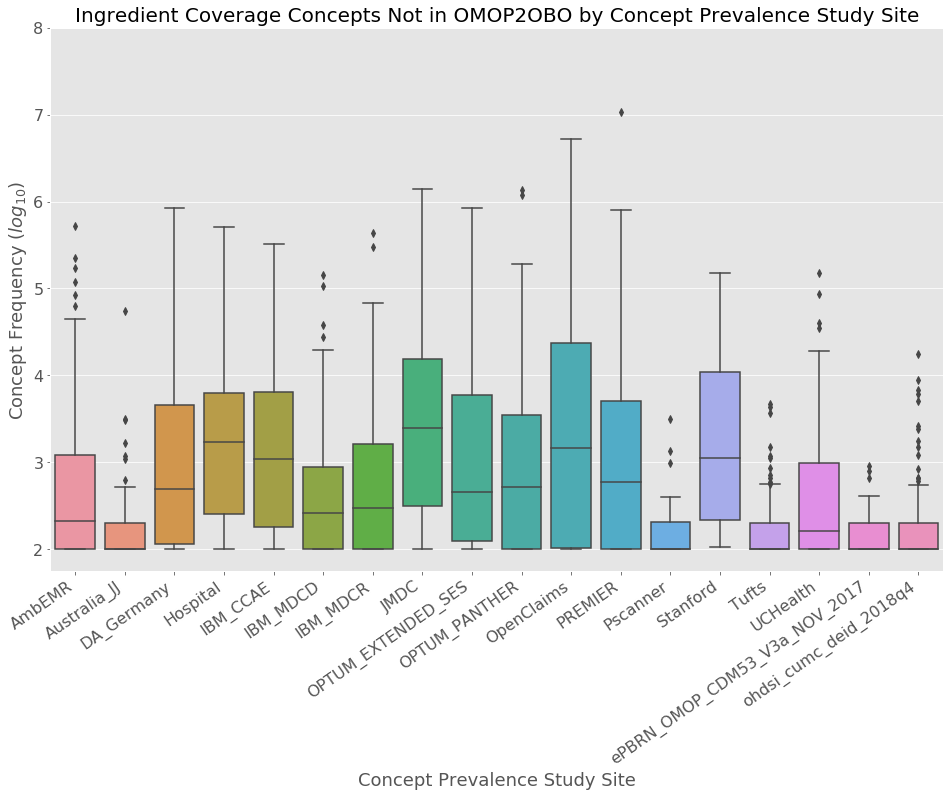

In [146]:
# create plot data
omop_not_med_plot = pd.DataFrame({'database': [x for y in cp_not_plt for x in y[0]],
                                  'concept_frequency': [math.log10(x) for y in cp_not_plt for x in y[1]]})

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
sboxplot = sns.boxplot(y='concept_frequency', x='database', data=omop_not_med_plot)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=35, horizontalalignment='right')
plt.title('Ingredient Coverage Concepts Not in OMOP2OBO by Concept Prevalence Study Site', fontsize=20)
plt.suptitle("")
plt.xlabel('Concept Prevalence Study Site', fontsize=18)
plt.ylabel('Concept Frequency ($log_{10}$)', fontsize=18)
plt.ylim(1.75, 8)
plt.tick_params(labelsize=16)
plt.show()

***

**Click [here](#coverage-drugs) to return to the Drug Exposure Ingredients Mapping Validation section**   
**Click [here](#mapping-validation) to return to the Mapping Validation section**  

***

### Measurements <a class="anchor" id="coverage-labs"></a>

***

The OHDSI `Concept Prevalence` data contained `23,513` unique OMOP vocabulary concepts from `18` sites. The `OMOP2OBO` vocabulary concepts from each of these sites was compared to the list of concepts from the `OMOP2OBO` mappings. After filtering the `OMOP2OBO` mappings to remove all entries where all ontologies were "NONE", "UNSPECIFIED SAMPLE" or "UNMAPPED TEST TYPE" and all non-standard concepts, `3,827` concepts (`10,673` lab test results) remained eligible for use in the coverage study. These data were utilized for all condition coverage experiments.


**Experiments**  
- [Full Set Coverage](#lab-full-set-coverage)  
- [Data Site Coverage](#lab-data-site-coverage)  

<br>


**LOAD DATA**

#### *CHCO Concept Frequency Data*  

In [147]:
# read in frequency counts data
chco_concept_counts = pd.read_csv(chco_concept_freq_url, sep=',', header=0)
chco_concept_counts.fillna('', inplace=True)

# reduce columns
chco_concept_counts = chco_concept_counts[['CONCEPT_ID', 'DOMAIN', 'CONCEPT_COUNT', 'CONCEPT_COUNT_ADJUSTED']]

# subset data to only keep conditions
chco_concept_counts = chco_concept_counts[chco_concept_counts['DOMAIN'] == 'Labs']

# view data
chco_concept_counts.head(n=5)


,CONCEPT_ID,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
591,3006228,Labs,1,100
694,3013530,Labs,1,100
695,3019677,Labs,1,100
847,3021535,Labs,1,100
848,3009381,Labs,1,100


#### *OHDSI Concept Prevalence Data*

In [148]:
# load concept prevalence data
concept_prev_labs = pd.read_excel(coverage_data, sheet_name='Measurement_Concepts', sep=',', header=0)
concept_prev_labs.fillna('', inplace=True)

# get only LOINC concepts
concept_prev_labs = concept_prev_labs[concept_prev_labs['VOCAB (TJC)'] =='LOINC']

# approved databases
concept_prev_labs = concept_prev_labs[concept_prev_labs['ANALYSIS APPROVED  (TJC)'] == 1]

# view data
concept_prev_labs.head(n=5)


,CONCEPT_ID,CONCEPT_NAME,DOMAIN (TJC),STANDARD (TJC),VOCAB (TJC),DATABASE_NAME,RECORD_COUNT,ANALYSIS APPROVED (TJC)
8,1175452,Monoclonal gammopathy panel - Serum or Plasma,Measurement,Standard,LOINC,AmbEMR,4597,1
9,1175604,T-cell regulatory (Treg) subsets panel - Blood,Measurement,Standard,LOINC,AmbEMR,523,1
10,1175721,Fatty acid omega-3 and omega-6 panel - Blood,Measurement,Standard,LOINC,AmbEMR,1520,1
11,1175774,CT Guidance for injection of Shoulder - left,Measurement,Standard,LOINC,AmbEMR,100,1
12,1175825,Sexually transmitted pathogens panel - Unspeci...,Measurement,Standard,LOINC,AmbEMR,10056,1


#### *OMOP2OBO Measurement Concept Mappings*

In [149]:
# load data
lab_mappings = pd.read_excel(labs_mapping_url, sheet_name='Aggregated_Mapping_Results', sep=',', header=0)
lab_mappings.fillna('', inplace=True)

# merge concept counts
lab_mappings = lab_mappings.merge(chco_concept_counts, how='left', on='CONCEPT_ID').drop_duplicates()

# get only standard concepts that have been mapped to at least 1 ontology
not_standard = lab_mappings.query('STANDARD != "S"')
not_mapped = lab_mappings.query('HP_MAPPING == "Unmapped" & UBERON_MAPPING == "Unmapped" & NCBITAXON_MAPPING == "Unmapped" & CHEBI_MAPPING == "Unmapped" & PR_MAPPING == "Unmapped" & CL_MAPPING == "Unmapped"')
nones = lab_mappings.query('HP_URI == "NONE" & UBERON_URI == "NONE" & NCBITAXON_URI == "NONE" & CHEBI_URI == "NONE" & PR_URI == "NONE" & CL_URI == "NONE"')

lab_mappings_standard = lab_mappings[~lab_mappings.CONCEPT_ID.isin(not_standard['CONCEPT_ID']) &
                                     ~lab_mappings.CONCEPT_ID.isin(not_mapped['CONCEPT_ID']) &
                                     ~lab_mappings.CONCEPT_ID.isin(nones['CONCEPT_ID'])]

# keep only needed columns
lab_mappings_standard.head()


,COMPOSITE_ID,CONCEPT_TYPE,CONCEPT_ID,STANDARD,CONCEPT_SOURCE_CODE,CONCEPT_LABEL,UMLS_CUI,UMLS_SEMANTIC_TYPE,SCALE,RESULT_TYPE,...,NCBITAXON_MAPPING,NCBITAXON_EVIDENCE,PR_LOGIC,PR_URI,PR_LABEL,PR_MAPPING,PR_EVIDENCE,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
0,3000003_Normal,LOINC2HPO Concept,3000003,S,7099-05-01 00:00:00,Asparagus IgE Ab [Units/volume] in Serum,C0483670,Clinical Attribute,QUANT,Normal,...,Manual,Hand Mapping,,PR_000050032,immunoglobulin complex (human),Manual,Hand Mapping,NaN,nan,nan
1,3000003_Low,LOINC2HPO Concept,3000003,S,7099-05-01 00:00:00,Asparagus IgE Ab [Units/volume] in Serum,C0483670,Clinical Attribute,QUANT,Low,...,Manual,Hand Mapping,,PR_000050032,immunoglobulin complex (human),Manual,Hand Mapping,NaN,nan,nan
2,3000003_High,LOINC2HPO Concept,3000003,S,7099-05-01 00:00:00,Asparagus IgE Ab [Units/volume] in Serum,C0483670,Clinical Attribute,QUANT,High,...,Manual,Hand Mapping,,PR_000050032,immunoglobulin complex (human),Manual,Hand Mapping,NaN,nan,nan
3,3000034_Normal,CHCO Concept Used In Practice,3000034,S,14957-5,Microalbumin urine,C0798130,Clinical Attribute,QUANT,Normal,...,Manual,Hand Mapping,,PR_000029067,homo sapiens protein,Manual,Hand Mapping,Labs,1009.000,1009.000
4,3000034_Low,CHCO Concept Used In Practice,3000034,S,14957-5,Microalbumin urine,C0798130,Clinical Attribute,QUANT,Low,...,Manual,Hand Mapping,,PR_000029067,homo sapiens protein,Manual,Hand Mapping,Labs,1009.000,1009.000


#### *Error Analysis Data*

In [150]:
# load data
error_analysis = pd.read_csv(error_analysis_data, sep=',', header=0)
error_analysis.fillna('', inplace=True)

# view data
error_analysis.head()

,RELATIONSHIP_ID,SCENARIO_TYPE,SOURCE_CONCEPT_ID,SOURCE_CONCEPT_LABEL,TARGET_CONCEPT_ID,TARGET_CONCEPT_LABEL
0,Concept poss_eq from,Newly Added Concept,4243823,Cyst of pharynx,23789,Pharynx or nasopharynx cyst
1,Concept poss_eq from,Newly Added Concept,4108471,Burn of digit of hand,72769,Deep full thickness burn of more than one fing...
2,Concept poss_eq from,Newly Added Concept,4286676,Acquired deformity of rib,73576,Acquired chest and rib deformity
3,Concept poss_eq from,Newly Added Concept,4326589,Pseudohermaphroditism,73584,Indeterminate sex and pseudohermaphroditism
4,Concept poss_eq from,Newly Added Concept,434499,Open fracture of sternum,73615,Open multiple fractures involving both upper l...


<br>

#### FULL SET COVERAGE<a class="anchor" id="lab-full-set-coverage"></a>    
This phase of the experiment aimed to demonstrate the coverage of the `OMOP2OBO` measurement concepts across the `Concept Prevalence` study sites. For this phase, a single set of all unique `concept_ids` is used and when reporting concept frequency, we use the average frequency across all sites. To be complete, we first report results for all of the `OMOP2OBO` condition concepts regardless of data type (i.e. `Concept Used in Clinical Practice`, `Standard LOINC Concept Not Used in Practice`) and then explore each type with respect to the annotated ontologies (i.e. [Human Phenotype Ontology ('HPO')](https://hpo.jax.org/), [Uber-Anatomy Ontology (UBERON)](http://uberon.org/), [NCBI Organism Taxonomy Ontology (NCBITaxon)](https://www.ncbi.nlm.nih.gov/taxonomy)
[Chemical Entities of Biological Interest ('CHEBI')](https://www.ebi.ac.uk/chebi/), [Cell Ontology (CL)](https://github.com/obophenotype/cell-ontology), and [Protein Ontology (PRO)](https://proconsortium.org/)). Finally, this section is concluded by performing an *error analysis*, where we use a current version of the `OMOP` Common Data Model (CDM) to try and explain `Concept Prevalence` concepts that were not included in the `OMOP2OBO` mapping set.  

**RESULTS**  
The `OMOP2OBO` measurement set contained `3,827` OMOP measurement concept ids (`10,673` lab test results), which covered `11.14%` of the `23,513` `Concept Prevalence` concepts. There were`1,207` `OMOP2OBO` concepts were not included in the `Concept Prevalence` set and `20,893` `Concept Prevalence` concepts were not covered by the `OMOP2OBO` mappings. The remaining results for this section are ordered by set:  
1. <u>Overlap:</u> `2,620` `OMOP2OBO` concepts (`1,393` *Concepts Used in Clinical Practice*, `1,207` *Standard SNOMED-CT Concepts Not Used in Clinical Practice*) existed in `OMOP2OBO` and `Concept Prevalence`. On average, the Overlap Coverage Concepts occurred `3,072.33` times (min: `100.0`, max: `183,333,482.38`)       
2. <u>`OMOP2OBO` Only:</u> `1,207` `OMOP2OBO` concepts (`42` *Concepts Used in Clinical Practice*, `1,164` *Standard RxNorm Concepts Not Used in Clinical Practice*) existed only in the `OMOP2OBO` set. On average, the `OMOP2OBO` Only Concepts occurred `346.92` times (min: `100.0`, max: `1,842,485.0`)      
3. <u>`Concept Prevalence` Only:</u> `20,893` `OMOP` concepts that existed only in the `Concept Prevalence` set. On average, the `Concept Prevalence` Only Concepts occurred `669.55` times (min: `100.0`, max: `1,219,846,862.0`)     


**Lab Test Result Ontology Annotations by Data Type**  

<table>
<tr>
<th align="center">DATA TYPE</th>  
<th align="center">ONTOLOGY</th>  
<th align="center">EXACT CONCEPT</th>
<th align="center">CONCEPT CONSTRUCTOR</th>
<th align="center">EXACT ANCESTOR</th>
<th align="center">ANCESTOR CONSTRUCTOR</th>
<th align="center">COSINE SIMILARITY</th>
<th align="center">MANUAL</th>
<th align="center">MANUAL CONSTRUCTOR</th>
<th align="center">UNMAPPED</th>
</tr>  
<tr>
  <td colspan="10"><b>OVERLAP SET (n=7,299)</b></td>
</tr>
<tr>
  <td rowspan="6"><i>Concepts Used In Practice (n=3,966)</i></td>
  <td rowspan="1"><i>HPO</i></td>
    <td>17</td>
    <td>0</td>
    <td>23</td>
    <td>0</td>
	<td>105</td>
	<td>3,788</td>
	<td>33</td>
	<td>0</td>
</tr>
<tr>
  <td rowspan="1"><i>UBERON</i></td>
    <td>1,765</td>
    <td>10</td>
    <td>544</td>
    <td>0</td>
	<td>50</td>
	<td>386</td>
	<td>1,211</td>
	<td>0</td>
</tr>
<tr>
  <td rowspan="1"><i>NCBITaxon</i></td>
    <td>317</td>
    <td>0</td>
    <td>180</td>
    <td>0</td>
	<td>44</td>
	<td>1,952</td>
	<td>5</td>
	<td>1,468</td>
</tr>
<tr>
  <td rowspan="1"><i>CHEBI</i></td>
    <td>257</td>
    <td>0</td>
    <td>1,321</td>
    <td>21</td>
	<td>100</td>
	<td>1,352</td>
	<td>338</td>
	<td>577</td>
</tr>
<tr>
  <td rowspan="1"><i>CL</i></td>
    <td>180</td>
    <td>43</td>
    <td>11</td>
    <td>3</td>
	<td>85</td>
	<td>256</td>
	<td>30</td>
	<td>3,358</td>
</tr>
<tr>
  <td rowspan="1"><i>PR</i></td>
    <td>44</td>
    <td>0</td>
    <td>15</td>
    <td>0</td>
	<td>103</td>
	<td>1,252</td>
	<td>144</td>
	<td>2,408</td>
</tr>
<tr>
  <td rowspan="6"><i>Standard LOINC Concepts Not Used In Practice (n=3,333)</i></td>
  <td rowspan="1"><i>HPO</i></td>
    <td>3</td>
    <td>0</td>
    <td>20</td>
    <td>0</td>
	<td>4</td>
	<td>3,297</td>
	<td>9</td>
	<td>0</td>
</tr>
<tr>
  <td rowspan="1"><i>UBERON</i></td>
    <td>1,745</td>
    <td>0</td>
    <td>405</td>
    <td>0</td>
	<td>71</td>
	<td>275</td>
	<td>837</td>
	<td>0</td>
</tr>
<tr>
  <td rowspan="1"><i>NCBITaxon</i></td>
    <td>279</td>
    <td>0</td>
    <td>223</td>
    <td>0</td>
	<td>76</td>
	<td>1,441</td>
	<td>132</td>
	<td>1,182</td>
</tr>
<tr>
  <td rowspan="1"><i>CHEBI</i></td>
    <td>158</td>
    <td>0</td>
    <td>999</td>
    <td>0</td>
	<td>78</td>
	<td>1,335</td>
	<td>484</td>
	<td>279</td>
</tr>
<tr>
  <td rowspan="1"><i>CL</i></td>
    <td>136</td>
    <td>21</td>
    <td>0</td>
    <td>0</td>
	<td>8</td>
	<td>130</td>
	<td>9</td>
	<td>3,029</td>
</tr>
<tr>
  <td rowspan="1"><i>PR</i></td>
    <td>12</td>
    <td>0</td>
    <td>6</td>
    <td>0</td>
	<td>23</td>
	<td>1,425</td>
	<td>124</td>
	<td>1,743</td>
</tr>
<tr>
  <td colspan="10"><b>OMOP2OBO ONLY SET (n=3,374)</b></td>
</tr>
<tr>
  <td rowspan="6"><i>Concepts Used In Practice (n=118)</i></td>
  <td rowspan="1"><i>HPO</i></td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
	<td>3</td>
	<td>111</td>
	<td>4</td>
	<td>0</td>
</tr>
<tr>
  <td rowspan="1"><i>UBERON</i></td>
    <td>28</td>
    <td>0</td>
    <td>48</td>
    <td>2</td>
	<td>0</td>
	<td>17</td>
	<td>23</td>
	<td>0</td>
</tr>
<tr>
  <td rowspan="1"><i>NCBITaxon</i></td>
    <td>3</td>
    <td>0</td>
    <td>4</td>
    <td>0</td>
	<td>0</td>
	<td>67</td>
	<td>0</td>
	<td>44</td>
</tr>
<tr>
  <td rowspan="1"><i>CHEBI</i></td>
    <td>6</td>
    <td>0</td>
    <td>61</td>
    <td>0</td>
	<td>2</td>
	<td>17</td>
	<td>12</td>
	<td>20</td>
</tr>
<tr>
  <td rowspan="1"><i>CL</i></td>
    <td>2</td>
    <td>3</td>
    <td>3</td>
    <td>0</td>
	<td>0</td>
	<td>0</td>
	<td>0</td>
	<td>110</td>
</tr>
<tr>
  <td rowspan="1"><i>PR</i></td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
	<td>0</td>
	<td>9</td>
	<td>5</td>
	<td>104</td>
</tr>
  <td rowspan="6"><i>Standard LOINC Concepts Not Used In Practice (n=3,256)</i></td>
  <td rowspan="1"><i>HPO</i></td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
	<td>1</td>
	<td>3,252</td>
	<td>3</td>
	<td>0</td>
</tr>
<tr>
  <td rowspan="1"><i>UBERON</i></td>
    <td>1,820</td>
    <td>0</td>
    <td>188</td>
    <td>0</td>
	<td>12</td>
	<td>152</td>
	<td>1,084</td>
	<td>0</td>
</tr>
<tr>
  <td rowspan="1"><i>NCBITaxon</i></td>
    <td>165</td>
    <td>0</td>
    <td>137</td>
    <td>0</td>
	<td>29</td>
	<td>1,929</td>
	<td>322</td>
	<td>674</td>
</tr>
<tr>
  <td rowspan="1"><i>CHEBI</i></td>
    <td>147</td>
    <td>0</td>
    <td>913</td>
    <td>0</td>
	<td>245</td>
	<td>1,008</td>
	<td>848</td>
	<td>95</td>
</tr>
<tr>
  <td rowspan="1"><i>CL</i></td>
    <td>47</td>
    <td>3</td>
    <td>0</td>
    <td>0</td>
	<td>12</td>
	<td>48</td>
	<td>6</td>
	<td>3,140</td>
</tr>
<tr>
  <td rowspan="1"><i>PR</i></td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
	<td>6</td>
	<td>1,610</td>
	<td>65</td>
	<td>1,575</td>
</tr>
</table>       

<br>

**Error Analysis**   
Of the `20,893` concepts not covered by `OMOP2OBO`, `13` can be accounted for by the current version of the `OMOP` CDM (i.e. *Error Analysis Concepts*), `158` can be accounted for in set of excluded mappings from the original mapping set (i.e. *Excluded Concepts*), and `20,722` concepts were missing and unable to be explained by existing data sources (i.e. *Truly Missing Concepts*). Additional details on each of these concept sets is provided below.
- *Error Analysis Concepts:* A total of `13` (`0.06%`) missing concepts could be accounted for by the current version of the `OMOP` CDM by tracing their original concept id to their new concept id using the OMOP `concept_relationship` table. These concepts occurred in an average of `3.23` `Concept Prevalence` study sites and had a mean frequency of `9,836.25` (min: `100`; max: `29,098.2`). The `13` missing concepts could be traced to `13` `source_concept_ids` in the original `OMOP2OBO` map set using the following `relationship_ids`: Maps to (n=`2`) and Concept replaced by (n=`11`)
- *Excluded Concepts:* A total of `158` (`0.76%`) could be found in the set of data which was initially filtered from the original `OMOP2OBO` data source. These concepts occurred in an average of `5.18` `Concept Prevalence` study sites and had a mean frequency of `282,115.28` (min: `100`; max: `14,317,951.9`). These concepts were initially excluded for one of the following reasons: `76` OMOP concepts had an "UNSPECIFIED SAMPLE"; `79` OMOP concepts had an "UNMAPPED TEST TYPE", and `3` OMOP concepts were unable to be mapped to an ontology
- *Truly Missing Concepts:* A total of `20,722` (`99.18%`) missing concepts were truly missing and unable to be accounted for by a current data source. These concepts occurred in an average of `2.82` `Concept Prevalence` study sites and had a mean frequency of `218,874.03` (min: `100`; max: `1,219,846,862`). The top five most frequently occurring missing concepts were: Pulse intensity of Unspecified artery palpation, Penicillin G potassium [Mass] of Dose, Sodium [Moles/volume] in Saliva (oral fluid), Cotinine/Creatinine [Mass Ratio] in Urine, and Chloride [Moles/volume] in Saliva (oral fluid) 

In [151]:
print('There are {} unique OMOP concept ids ({} lab test results) covered by HPO, UBERON, NCBITaxon, CHEBI, CL, or PRO via OMOP2OBO mappings'.format(len(set(lab_mappings_standard['CONCEPT_ID'])),
                                                                                                                                                     len(lab_mappings_standard)))


There are 3827 unique OMOP concept ids (10673 lab test results) covered by HPO, UBERON, NCBITaxon, CHEBI, CL, or PRO via OMOP2OBO mappings


In [152]:
print('The Concept Prevalence data contained {} unique OMOP concepts from {} study sites'.format(len(set(list(concept_prev_labs['CONCEPT_ID']))),
                                                                                                 len(set(list(concept_prev_labs['DATABASE_NAME'])))))

The Concept Prevalence data contained 23513 unique OMOP concepts from 18 study sites


In [153]:
# get overall coverage metrics
cp_lab_concepts = set(list(concept_prev_labs['CONCEPT_ID']))
omop2obo_lab_concepts = set(list(lab_mappings_standard['CONCEPT_ID']))

# get general coverage across all Concept Prevalence databases
overlap_lab_concepts = cp_lab_concepts.intersection(omop2obo_lab_concepts)
only_omop2obo_lab_concepts = omop2obo_lab_concepts.difference(cp_lab_concepts)
only_cp_lab_concepts = cp_lab_concepts.difference(omop2obo_lab_concepts)

# print metrics
lab_coverage = 'The OMOP2OBO mappings covered {}% of the {} Concept Prevalence concepts'.format(round(len(overlap_lab_concepts)/(len(overlap_lab_concepts) + len(only_cp_lab_concepts))*100, 3),
                                                                                                   len(cp_lab_concepts))  
overlap = '\n - {} concepts in OMOP2OBO were also in the Concept Prevalence concept set'.format(len(overlap_lab_concepts))
omop2obo_only = '\n - {} concepts in OMOP2OBO that are not in the Concept Prevalence concept set'.format(len(only_omop2obo_lab_concepts))
cp_only = '\n - {} concepts in the Concept Prevalence concept set that are not in OMOP2OBO'.format(len(only_cp_lab_concepts))

print(lab_coverage, overlap, omop2obo_only, cp_only)


The OMOP2OBO mappings covered 11.143% of the 23513 Concept Prevalence concepts 
 - 2620 concepts in OMOP2OBO were also in the Concept Prevalence concept set 
 - 1207 concepts in OMOP2OBO that are not in the Concept Prevalence concept set 
 - 20893 concepts in the Concept Prevalence concept set that are not in OMOP2OBO


#### Concept Counts by Coverage Set

In [154]:
# process coverage set data
lab_coverage_sets = output_coverage_set_counts(concept_prev_labs, lab_mappings_standard,
                                                [overlap_lab_concepts, only_cp_lab_concepts, only_omop2obo_lab_concepts])

In [155]:
# print stats on concepts in OMOP2OBO were also in the Concept Prevalence concept set
min_overlap = 10 ** min(lab_coverage_sets['overlap']['counts'])
max_overlap = round(10 ** max(lab_coverage_sets['overlap']['counts']), 2)
mean_overlap = round(10 ** statistics.mean(lab_coverage_sets['overlap']['counts']), 2)

print('On average, the Overlap Coverage Concepts occurred {} times (min: {}, max: {})'.format(mean_overlap, min_overlap, max_overlap))

On average, the Overlap Coverage Concepts occurred 3072.33 times (min: 100.0, max: 183333482.38)


In [157]:
# print stats on concepts in OMOP2OBO that are not in the Concept Prevalence concept set 
min_overlap = 10 ** min(lab_coverage_sets['omop2obo_only']['counts'])
max_overlap = round(10 ** max(lab_coverage_sets['omop2obo_only']['counts']), 2)
mean_overlap = round(10 ** statistics.mean(lab_coverage_sets['omop2obo_only']['counts']), 2)

print('On average, the OMOP2OBO Only Concepts occurred {} times (min: {}, max: {})'.format(mean_overlap, min_overlap, max_overlap))

On average, the OMOP2OBO Only Concepts occurred 346.92 times (min: 100.0, max: 1842485.0)


In [156]:
# print stats on concepts in the Concept Prevalence concept set that are not in OMOP2OBO
min_overlap = 10 ** min(lab_coverage_sets['cp_only']['counts'])
max_overlap = round(10 ** max(lab_coverage_sets['cp_only']['counts']), 2)
mean_overlap = round(10 ** statistics.mean(lab_coverage_sets['cp_only']['counts']), 2)

print('On average, the Concept Prevalence Only Concepts occurred {} times (min: {}, max: {})'.format(mean_overlap, min_overlap, max_overlap))

On average, the Concept Prevalence Only Concepts occurred 669.55 times (min: 100.0, max: 1219846862.0)


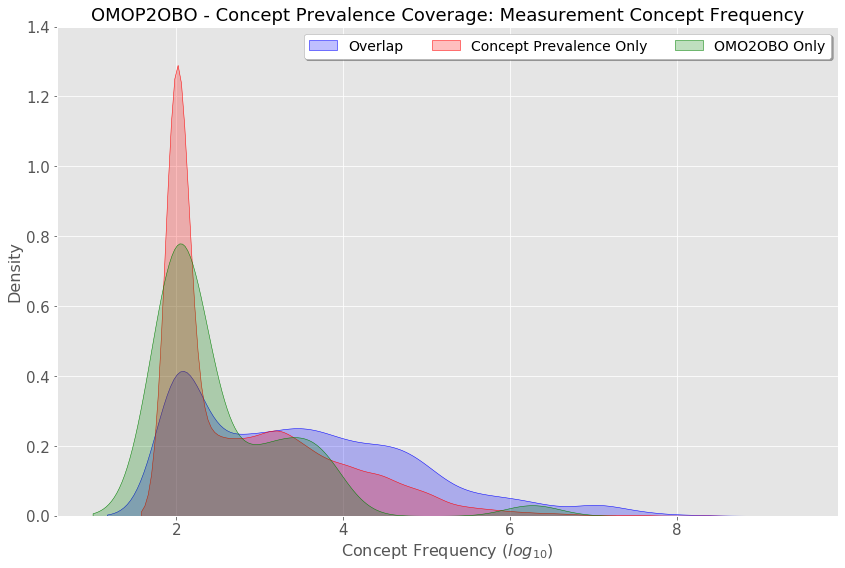

In [158]:
# create histograms
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
y = sns.kdeplot(lab_coverage_sets['overlap']['counts'], color='blue', label='Overlap', shade=True)
y = sns.kdeplot(lab_coverage_sets['cp_only']['counts'], color='red', label='Concept Prevalence Only', shade=True)
y = sns.kdeplot(lab_coverage_sets['omop2obo_only']['counts'], color='green', label='OMO2OBO Only', shade=True)

plt.title('OMOP2OBO - Concept Prevalence Coverage: Measurement Concept Frequency', fontsize=18)
plt.suptitle('')
plt.xlabel('Concept Frequency ($log_{10}$)', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.ylim(0.0, 1.4)
plt.tick_params(labelsize=15)
plt.legend(title='', fontsize=14, title_fontsize=14, shadow=True, facecolor='white', edgecolor='darkgray', ncol=3)
plt.show()

OVERLAP COVERAGE SET

In [159]:
# get stats on concepts in both sets and by ontology
covered_concepts_omop2obo = lab_mappings_standard[lab_mappings_standard.CONCEPT_ID.isin(list(overlap_lab_concepts))]

# split results by concept type (i.e. concepts used in practice, standard concepts)
lab_overlap_res = covered_concepts_omop2obo.groupby('CONCEPT_TYPE')

# re-group by ontology
lab_overlap_prac = lab_overlap_res.get_group('CHCO Concept Used In Practice').drop_duplicates()
lab_overlap_stnd = lab_overlap_res.get_group('LOINC2HPO Concept').drop_duplicates()

# print the number of overlapping concepts
print('{} OMOP concepts ({} lab test results) overlapped in OMOP2OBO and the Concept Prevalence data'.format(len(overlap_lab_concepts),
                                                                                                             len(covered_concepts_omop2obo)))

2620 OMOP concepts (7299 lab test results) overlapped in OMOP2OBO and the Concept Prevalence data


***Concepts Used In Clinical Practice***

In [160]:
print('{} overlapping codes ({} lab test results) for Concepts Used in Practice'.format(len(set(lab_overlap_prac['CONCEPT_ID'])),
                                                                                       len(lab_overlap_prac['CONCEPT_ID'])))

# print mapping categories
lab_prac_hp_cat = lab_overlap_prac.groupby('HP_MAPPING').size().reset_index(name='COUNT')
lab_prac_uberon_cat = lab_overlap_prac.groupby('UBERON_MAPPING').size().reset_index(name='COUNT')
lab_prac_ncbitaxon_cat = lab_overlap_prac.groupby('NCBITAXON_MAPPING').size().reset_index(name='COUNT')
lab_prac_chebi_cat = lab_overlap_prac.groupby('CHEBI_MAPPING').size().reset_index(name='COUNT')
lab_prac_cl_cat = lab_overlap_prac.groupby('CL_MAPPING').size().reset_index(name='COUNT')
lab_prac_pr_cat = lab_overlap_prac.groupby('PR_MAPPING').size().reset_index(name='COUNT')

# create plotting data
overlap_lab_prac_data = pd.DataFrame({'ontology': ['HP'] * len(lab_prac_hp_cat) + ['UBERON'] * len(lab_prac_uberon_cat) + ['NCBITAXON'] * len(lab_prac_ncbitaxon_cat) + ['CHEBI'] * len(lab_prac_chebi_cat) + ['CL'] * len(lab_prac_cl_cat) + ['PR'] * len(lab_prac_pr_cat),
                                      'mapping_category': list(lab_prac_hp_cat['HP_MAPPING']) + list(lab_prac_uberon_cat['UBERON_MAPPING']) + list(lab_prac_ncbitaxon_cat['NCBITAXON_MAPPING']) + list(lab_prac_chebi_cat['CHEBI_MAPPING']) + list(lab_prac_cl_cat['CL_MAPPING']) + list(lab_prac_pr_cat['PR_MAPPING']),
                                      'counts': list(np.log10(lab_prac_hp_cat['COUNT'])) + list(np.log10(lab_prac_uberon_cat['COUNT'])) + list(np.log10(lab_prac_ncbitaxon_cat['COUNT'])) + list(np.log10(lab_prac_chebi_cat['COUNT'])) + list(np.log10(lab_prac_cl_cat['COUNT'])) + list(np.log10(lab_prac_pr_cat['COUNT']))})

1393 overlapping codes (3966 lab test results) for Concepts Used in Practice


In [161]:
# print hpo data
lab_prac_hp_cat

,HP_MAPPING,COUNT
0,Automatic Exact - Ancestor,23
1,Automatic Exact - Concept,17
2,Manual,3788
3,Manual Constructor,33
4,Manual Exact - Concept Similarity,105


In [162]:
# print uberon data
lab_prac_uberon_cat

,UBERON_MAPPING,COUNT
0,Automatic Constructor - Concept,10
1,Automatic Exact - Ancestor,544
2,Automatic Exact - Concept,1765
3,Manual,386
4,Manual Constructor,1211
5,Manual Exact - Concept Similarity,50


In [163]:
# print ncbitaxon data
lab_prac_ncbitaxon_cat

,NCBITAXON_MAPPING,COUNT
0,Automatic Exact - Ancestor,180
1,Automatic Exact - Concept,317
2,Manual,1952
3,Manual Constructor,5
4,Manual Exact - Concept Similarity,44
5,Unmapped,1468


In [164]:
# print chebi data
lab_prac_chebi_cat

,CHEBI_MAPPING,COUNT
0,Automatic Constructor - Ancestor,21
1,Automatic Exact - Ancestor,1321
2,Automatic Exact - Concept,257
3,Manual,1352
4,Manual Constructor,338
5,Manual Exact - Concept Similarity,100
6,Unmapped,577


In [165]:
# print cl data
lab_prac_cl_cat

,CL_MAPPING,COUNT
0,Automatic Constructor - Ancestor,3
1,Automatic Constructor - Concept,43
2,Automatic Exact - Ancestor,11
3,Automatic Exact - Concept,180
4,Manual,256
5,Manual Constructor,30
6,Manual Exact - Concept Similarity,85
7,Unmapped,3358


In [166]:
# print pro data
lab_prac_pr_cat

,PR_MAPPING,COUNT
0,Automatic Exact - Ancestor,15
1,Automatic Exact - Concept,44
2,Manual,1252
3,Manual Constructor,144
4,Manual Exact - Concept Similarity,103
5,Unmapped,2408


***Standard LOINC Concepts Not Used In Practice***

In [167]:
print('{} overlapping codes ({} lab test results) for Standard LOINC Concepts Used in Practice'.format(len(set(lab_overlap_stnd['CONCEPT_ID'])),
                                                                                                       len(lab_overlap_stnd['CONCEPT_ID'])))

# print mapping categories
lab_stnd_hp_cat = lab_overlap_stnd.groupby('HP_MAPPING').size().reset_index(name='COUNT')
lab_stnd_uberon_cat = lab_overlap_stnd.groupby('UBERON_MAPPING').size().reset_index(name='COUNT')
lab_stnd_ncbitaxon_cat = lab_overlap_stnd.groupby('NCBITAXON_MAPPING').size().reset_index(name='COUNT')
lab_stnd_chebi_cat = lab_overlap_stnd.groupby('CHEBI_MAPPING').size().reset_index(name='COUNT')
lab_stnd_cl_cat = lab_overlap_stnd.groupby('CL_MAPPING').size().reset_index(name='COUNT')
lab_stnd_pr_cat = lab_overlap_stnd.groupby('PR_MAPPING').size().reset_index(name='COUNT')

# create plotting data
overlap_lab_stnd_data = pd.DataFrame({'ontology': ['HP'] * len(lab_stnd_hp_cat) + ['UBERON'] * len(lab_stnd_uberon_cat) + ['NCBITAXON'] * len(lab_stnd_ncbitaxon_cat) + ['CHEBI'] * len(lab_stnd_chebi_cat) + ['CL'] * len(lab_stnd_cl_cat) + ['PR'] * len(lab_stnd_pr_cat),
                                      'mapping_category': list(lab_stnd_hp_cat['HP_MAPPING']) + list(lab_stnd_uberon_cat['UBERON_MAPPING']) + list(lab_stnd_ncbitaxon_cat['NCBITAXON_MAPPING']) + list(lab_stnd_chebi_cat['CHEBI_MAPPING']) + list(lab_stnd_cl_cat['CL_MAPPING']) + list(lab_stnd_pr_cat['PR_MAPPING']),
                                      'counts': list(np.log10(lab_stnd_hp_cat['COUNT'])) + list(np.log10(lab_stnd_uberon_cat['COUNT'])) + list(np.log10(lab_stnd_ncbitaxon_cat['COUNT'])) + list(np.log10(lab_stnd_chebi_cat['COUNT'])) + list(np.log10(lab_stnd_cl_cat['COUNT'])) + list(np.log10(lab_stnd_pr_cat['COUNT']))})


1227 overlapping codes (3333 lab test results) for Standard LOINC Concepts Used in Practice


In [168]:
# print hpo data
lab_stnd_hp_cat

,HP_MAPPING,COUNT
0,Automatic Exact - Ancestor,20
1,Automatic Exact - Concept,3
2,Manual,3297
3,Manual Constructor,9
4,Manual Exact - Concept Similarity,4


In [169]:
# print uberon data
lab_stnd_uberon_cat

,UBERON_MAPPING,COUNT
0,Automatic Exact - Ancestor,405
1,Automatic Exact - Concept,1745
2,Manual,275
3,Manual Constructor,837
4,Manual Exact - Concept Similarity,71


In [170]:
# print ncbitaxon data
lab_stnd_ncbitaxon_cat

,NCBITAXON_MAPPING,COUNT
0,Automatic Exact - Ancestor,223
1,Automatic Exact - Concept,279
2,Manual,1441
3,Manual Constructor,132
4,Manual Exact - Concept Similarity,76
5,Unmapped,1182


In [171]:
# print chebi data
lab_stnd_chebi_cat

,CHEBI_MAPPING,COUNT
0,Automatic Exact - Ancestor,999
1,Automatic Exact - Concept,158
2,Manual,1335
3,Manual Constructor,484
4,Manual Exact - Concept Similarity,78
5,Unmapped,279


In [172]:
# print cl data
lab_stnd_cl_cat

,CL_MAPPING,COUNT
0,Automatic Constructor - Concept,21
1,Automatic Exact - Concept,136
2,Manual,130
3,Manual Constructor,9
4,Manual Exact - Concept Similarity,8
5,Unmapped,3029


In [173]:
# print pro data
lab_stnd_pr_cat

,PR_MAPPING,COUNT
0,Automatic Exact - Ancestor,6
1,Automatic Exact - Concept,12
2,Manual,1425
3,Manual Constructor,124
4,Manual Exact - Concept Similarity,23
5,Unmapped,1743


***Plot Counts of Concepts By Mapping Category***

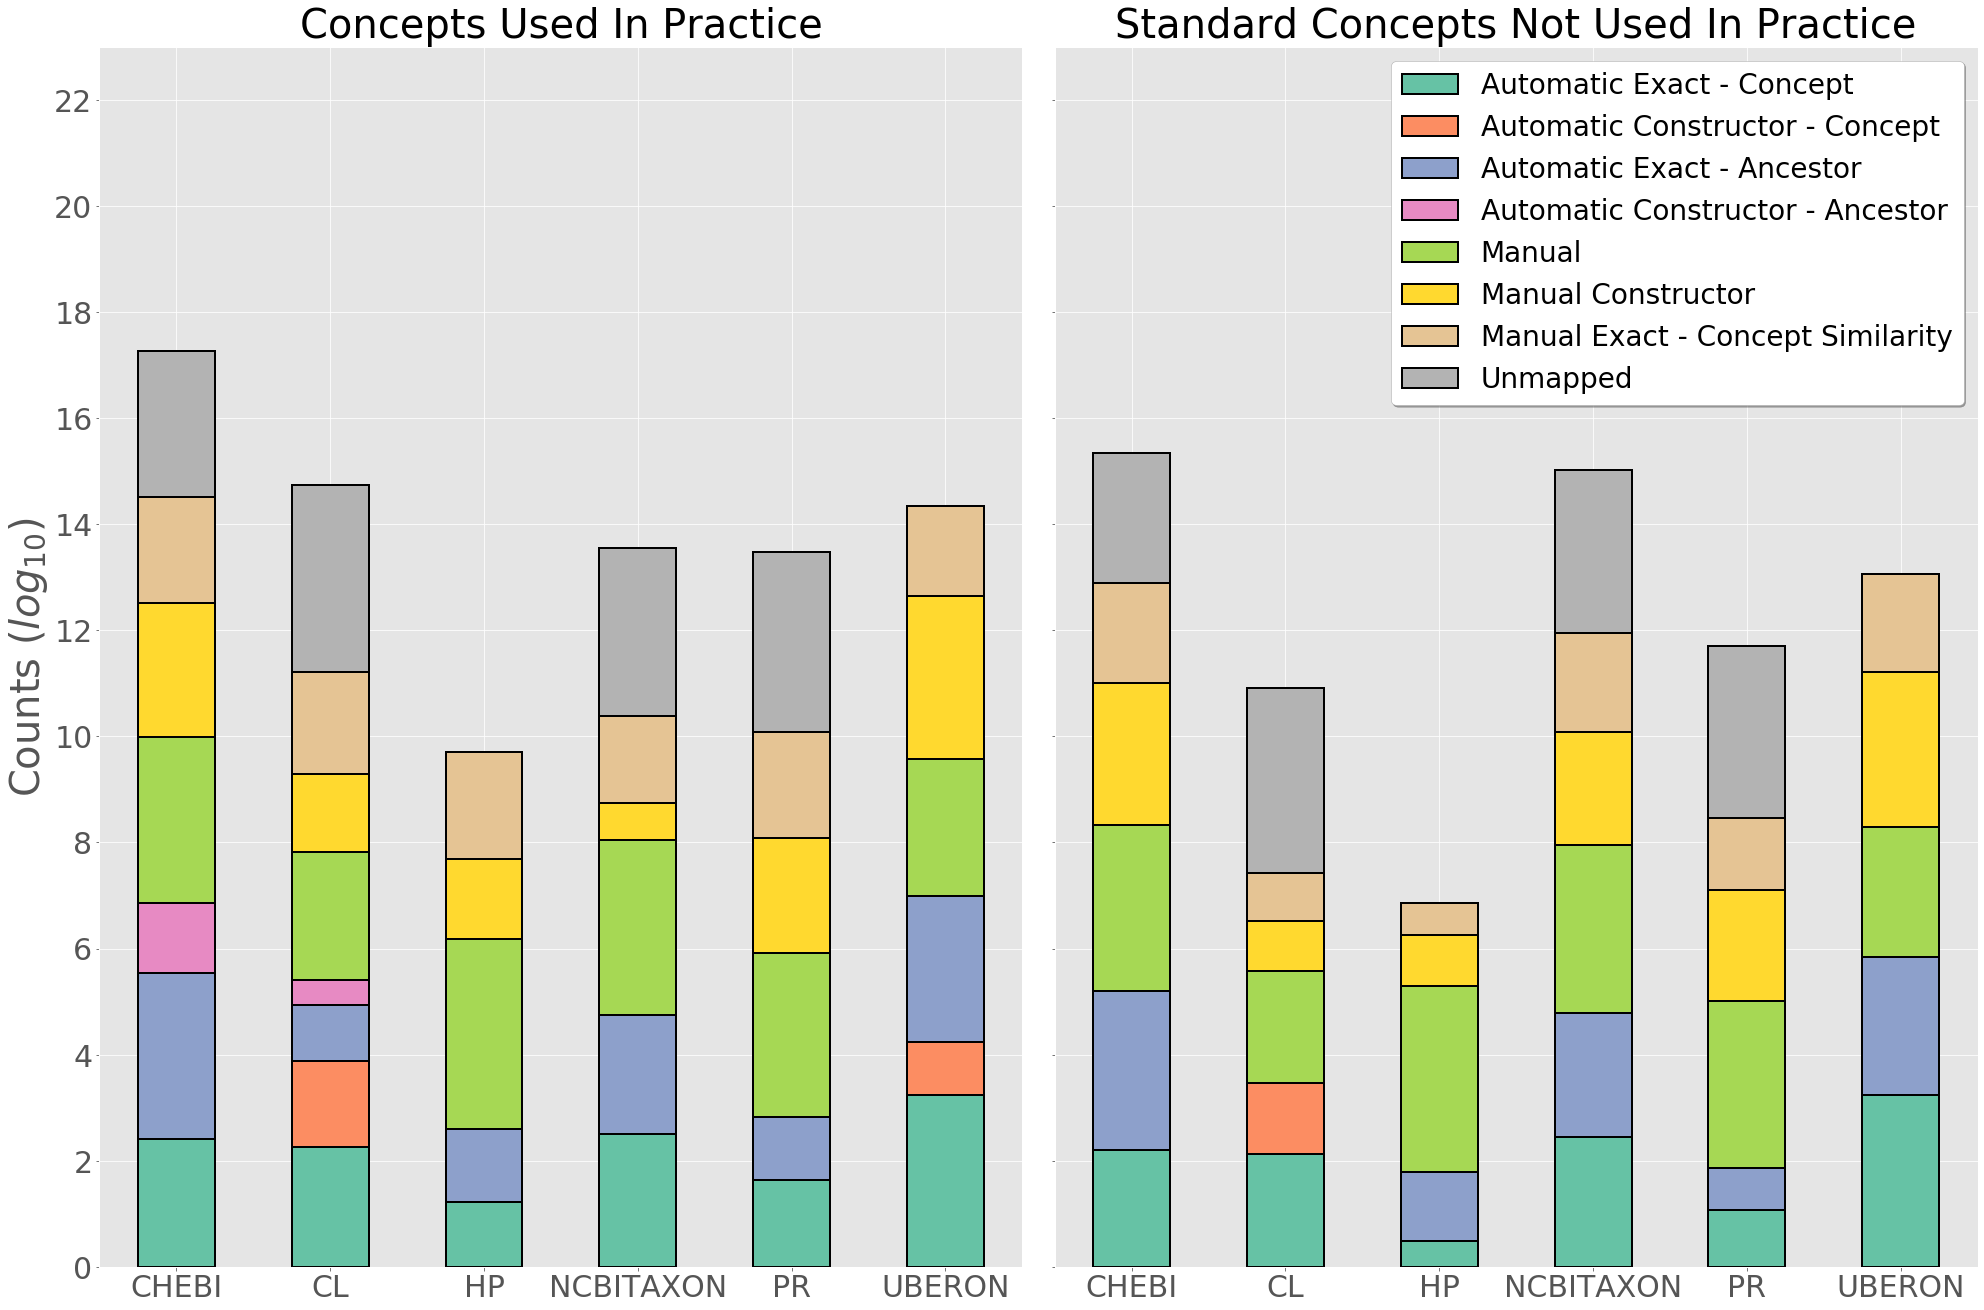

In [174]:
# create plot data
plots = {'Concepts Used In Practice': overlap_lab_prac_data,
         'Standard Concepts Not Used In Practice': overlap_lab_stnd_data}

ordering = ['Automatic Exact - Concept', 'Automatic Constructor - Concept',
           'Automatic Exact - Ancestor', 'Automatic Constructor - Ancestor',
            'Manual', 'Manual Constructor', 'Manual Exact - Concept Similarity', 'Unmapped']

# create plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 18))
scale_min, scale_max, scale_step = 0, 23, 2 
xlabel, ylabel = '', 'Counts ($log_{10}$)'
for df, ax in zip(plots.keys(), axes):
    plt_data = plots[df].pivot(index='ontology', columns='mapping_category', values='counts')
    plt_data = plt_data.reindex(ordering, axis=1)
    ax = plt_data.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', linewidth=2, colormap='Set2')
    ax.set_title(df, fontsize=40, alpha=1.0)
    ax.set_ylabel(ylabel, fontsize=40),
    ax.set_xlabel(xlabel, fontsize=40),
    ax.set_ylim(scale_min, scale_max)
    ax.set_yticks(range(scale_min, scale_max, scale_step))
    ax.set_yticklabels(labels=range(scale_min, scale_max, scale_step), rotation=0, minor=False, fontsize=30)
    ax.set_xticklabels(labels=list(plt_data.index), rotation=0, minor=False, fontsize=30)
    handles, labels = ax.get_legend_handles_labels()

# facet into single plot
plt.tight_layout(pad=0.0, w_pad=-6.5, h_pad=0.0)
axes[1].set_ylabel("")
axes[1].set_yticklabels("")
axes[0].legend().set_visible(False)
axes[1].legend(ordering, fontsize=28, shadow=True, facecolor='white', edgecolor='darkgray', ncol=1)

plt.show()

OMOP2OBO ONLY COVERAGE SET

In [175]:
# get stats on concepts in both sets and by ontology
omop2obo_only_concepts = lab_mappings_standard[lab_mappings_standard.CONCEPT_ID.isin(list(only_omop2obo_lab_concepts))]

# split results by concept type (i.e. concepts used in practice, standard concepts)
lab_omop2obo_res = omop2obo_only_concepts.groupby('CONCEPT_TYPE')

# re-group by ontology
lab_omop2obo_prac = lab_omop2obo_res.get_group('CHCO Concept Used In Practice').drop_duplicates()
lab_omop2obo_stnd = lab_omop2obo_res.get_group('LOINC2HPO Concept').drop_duplicates()

# print the number of overlapping concepts
print('{} OMOP concepts ({} lab test results) Only Found in OMOP2OBO'.format(len(only_omop2obo_lab_concepts),
                                                                             len(omop2obo_only_concepts)))


1207 OMOP concepts (3374 lab test results) Only Found in OMOP2OBO


***Concepts Used In Practice***

In [176]:
print('{} OMOP2OBO only codes ({} lab test results) for Concepts Used in Practice'.format(len(set(lab_omop2obo_prac['CONCEPT_ID'])),
                                                                                         len(lab_omop2obo_prac['CONCEPT_ID'])))

# print mapping categories
lab_prac_hp_cat = lab_omop2obo_prac.groupby('HP_MAPPING').size().reset_index(name='COUNT')
lab_prac_uberon_cat = lab_omop2obo_prac.groupby('UBERON_MAPPING').size().reset_index(name='COUNT')
lab_prac_ncbitaxon_cat = lab_omop2obo_prac.groupby('NCBITAXON_MAPPING').size().reset_index(name='COUNT')
lab_prac_chebi_cat = lab_omop2obo_prac.groupby('CHEBI_MAPPING').size().reset_index(name='COUNT')
lab_prac_cl_cat = lab_omop2obo_prac.groupby('CL_MAPPING').size().reset_index(name='COUNT')
lab_prac_pr_cat = lab_omop2obo_prac.groupby('PR_MAPPING').size().reset_index(name='COUNT')

# create plotting data
omop2obo_lab_prac_data = pd.DataFrame({'ontology': ['HP'] * len(lab_prac_hp_cat) + ['UBERON'] * len(lab_prac_uberon_cat) + ['NCBITAXON'] * len(lab_prac_ncbitaxon_cat) + ['CHEBI'] * len(lab_prac_chebi_cat) + ['CL'] * len(lab_prac_cl_cat) + ['PR'] * len(lab_prac_pr_cat),
                                      'mapping_category': list(lab_prac_hp_cat['HP_MAPPING']) + list(lab_prac_uberon_cat['UBERON_MAPPING']) + list(lab_prac_ncbitaxon_cat['NCBITAXON_MAPPING']) + list(lab_prac_chebi_cat['CHEBI_MAPPING']) + list(lab_prac_cl_cat['CL_MAPPING']) + list(lab_prac_pr_cat['PR_MAPPING']),
                                      'counts': list(np.log10(lab_prac_hp_cat['COUNT'])) + list(np.log10(lab_prac_uberon_cat['COUNT'])) + list(np.log10(lab_prac_ncbitaxon_cat['COUNT'])) + list(np.log10(lab_prac_chebi_cat['COUNT'])) + list(np.log10(lab_prac_cl_cat['COUNT'])) + list(np.log10(lab_prac_pr_cat['COUNT']))})

43 OMOP2OBO only codes (118 lab test results) for Concepts Used in Practice


In [177]:
# print hpo data
lab_prac_hp_cat

,HP_MAPPING,COUNT
0,Manual,111
1,Manual Constructor,4
2,Manual Exact - Concept Similarity,3


In [178]:
# print uberon data
lab_prac_uberon_cat

,UBERON_MAPPING,COUNT
0,Automatic Constructor - Ancestor,2
1,Automatic Exact - Ancestor,48
2,Automatic Exact - Concept,28
3,Manual,17
4,Manual Constructor,23


In [179]:
# print ncbitaxon data
lab_prac_ncbitaxon_cat

,NCBITAXON_MAPPING,COUNT
0,Automatic Exact - Ancestor,4
1,Automatic Exact - Concept,3
2,Manual,67
3,Unmapped,44


In [180]:
# print chebi data
lab_prac_chebi_cat

,CHEBI_MAPPING,COUNT
0,Automatic Exact - Ancestor,61
1,Automatic Exact - Concept,6
2,Manual,17
3,Manual Constructor,12
4,Manual Exact - Concept Similarity,2
5,Unmapped,20


In [181]:
# print cl data
lab_prac_cl_cat

,CL_MAPPING,COUNT
0,Automatic Constructor - Concept,3
1,Automatic Exact - Ancestor,3
2,Automatic Exact - Concept,2
3,Unmapped,110


In [182]:
# print pro data
lab_prac_pr_cat

,PR_MAPPING,COUNT
0,Manual,9
1,Manual Constructor,5
2,Unmapped,104


***Standard LOINC Concepts Not Used In Practice***

In [183]:
print('{} OMOP2OBO only codes ({} lab test results) for Standard LOINC Concepts Used in Practice'.format(len(set(lab_omop2obo_stnd['CONCEPT_ID'])),
                                                                                                         len(lab_omop2obo_stnd['CONCEPT_ID'])))

# print mapping categories
lab_stnd_hp_cat = lab_omop2obo_stnd.groupby('HP_MAPPING').size().reset_index(name='COUNT')
lab_stnd_uberon_cat = lab_omop2obo_stnd.groupby('UBERON_MAPPING').size().reset_index(name='COUNT')
lab_stnd_ncbitaxon_cat = lab_omop2obo_stnd.groupby('NCBITAXON_MAPPING').size().reset_index(name='COUNT')
lab_stnd_chebi_cat = lab_omop2obo_stnd.groupby('CHEBI_MAPPING').size().reset_index(name='COUNT')
lab_stnd_cl_cat = lab_omop2obo_stnd.groupby('CL_MAPPING').size().reset_index(name='COUNT')
lab_stnd_pr_cat = lab_omop2obo_stnd.groupby('PR_MAPPING').size().reset_index(name='COUNT')

# create plotting data
omop2obo_lab_stnd_data = pd.DataFrame({'ontology': ['HP'] * len(lab_stnd_hp_cat) + ['UBERON'] * len(lab_stnd_uberon_cat) + ['NCBITAXON'] * len(lab_stnd_ncbitaxon_cat) + ['CHEBI'] * len(lab_stnd_chebi_cat) + ['CL'] * len(lab_stnd_cl_cat) + ['PR'] * len(lab_stnd_pr_cat),
                                      'mapping_category': list(lab_stnd_hp_cat['HP_MAPPING']) + list(lab_stnd_uberon_cat['UBERON_MAPPING']) + list(lab_stnd_ncbitaxon_cat['NCBITAXON_MAPPING']) + list(lab_stnd_chebi_cat['CHEBI_MAPPING']) + list(lab_stnd_cl_cat['CL_MAPPING']) + list(lab_stnd_pr_cat['PR_MAPPING']),
                                      'counts': list(np.log10(lab_stnd_hp_cat['COUNT'])) + list(np.log10(lab_stnd_uberon_cat['COUNT'])) + list(np.log10(lab_stnd_ncbitaxon_cat['COUNT'])) + list(np.log10(lab_stnd_chebi_cat['COUNT'])) + list(np.log10(lab_stnd_cl_cat['COUNT'])) + list(np.log10(lab_stnd_pr_cat['COUNT']))})

1164 OMOP2OBO only codes (3256 lab test results) for Standard LOINC Concepts Used in Practice


In [184]:
# print hpo data
lab_stnd_hp_cat

,HP_MAPPING,COUNT
0,Manual,3252
1,Manual Constructor,3
2,Manual Exact - Concept Similarity,1


In [185]:
# print uberon data
lab_stnd_uberon_cat

,UBERON_MAPPING,COUNT
0,Automatic Exact - Ancestor,188
1,Automatic Exact - Concept,1820
2,Manual,152
3,Manual Constructor,1084
4,Manual Exact - Concept Similarity,12


In [186]:
# print ncbitaxon data
lab_stnd_ncbitaxon_cat

,NCBITAXON_MAPPING,COUNT
0,Automatic Exact - Ancestor,137
1,Automatic Exact - Concept,165
2,Manual,1929
3,Manual Constructor,322
4,Manual Exact - Concept Similarity,29
5,Unmapped,674


In [187]:
# print chebi data
lab_stnd_chebi_cat

,CHEBI_MAPPING,COUNT
0,Automatic Exact - Ancestor,913
1,Automatic Exact - Concept,147
2,Manual,1008
3,Manual Constructor,848
4,Manual Exact - Concept Similarity,245
5,Unmapped,95


In [188]:
# print cl data
lab_stnd_cl_cat

,CL_MAPPING,COUNT
0,Automatic Constructor - Concept,3
1,Automatic Exact - Concept,47
2,Manual,48
3,Manual Constructor,6
4,Manual Exact - Concept Similarity,12
5,Unmapped,3140


In [189]:
# print pro data
lab_stnd_pr_cat

,PR_MAPPING,COUNT
0,Manual,1610
1,Manual Constructor,65
2,Manual Exact - Concept Similarity,6
3,Unmapped,1575


***Plot Counts of Concepts By Mapping Category***

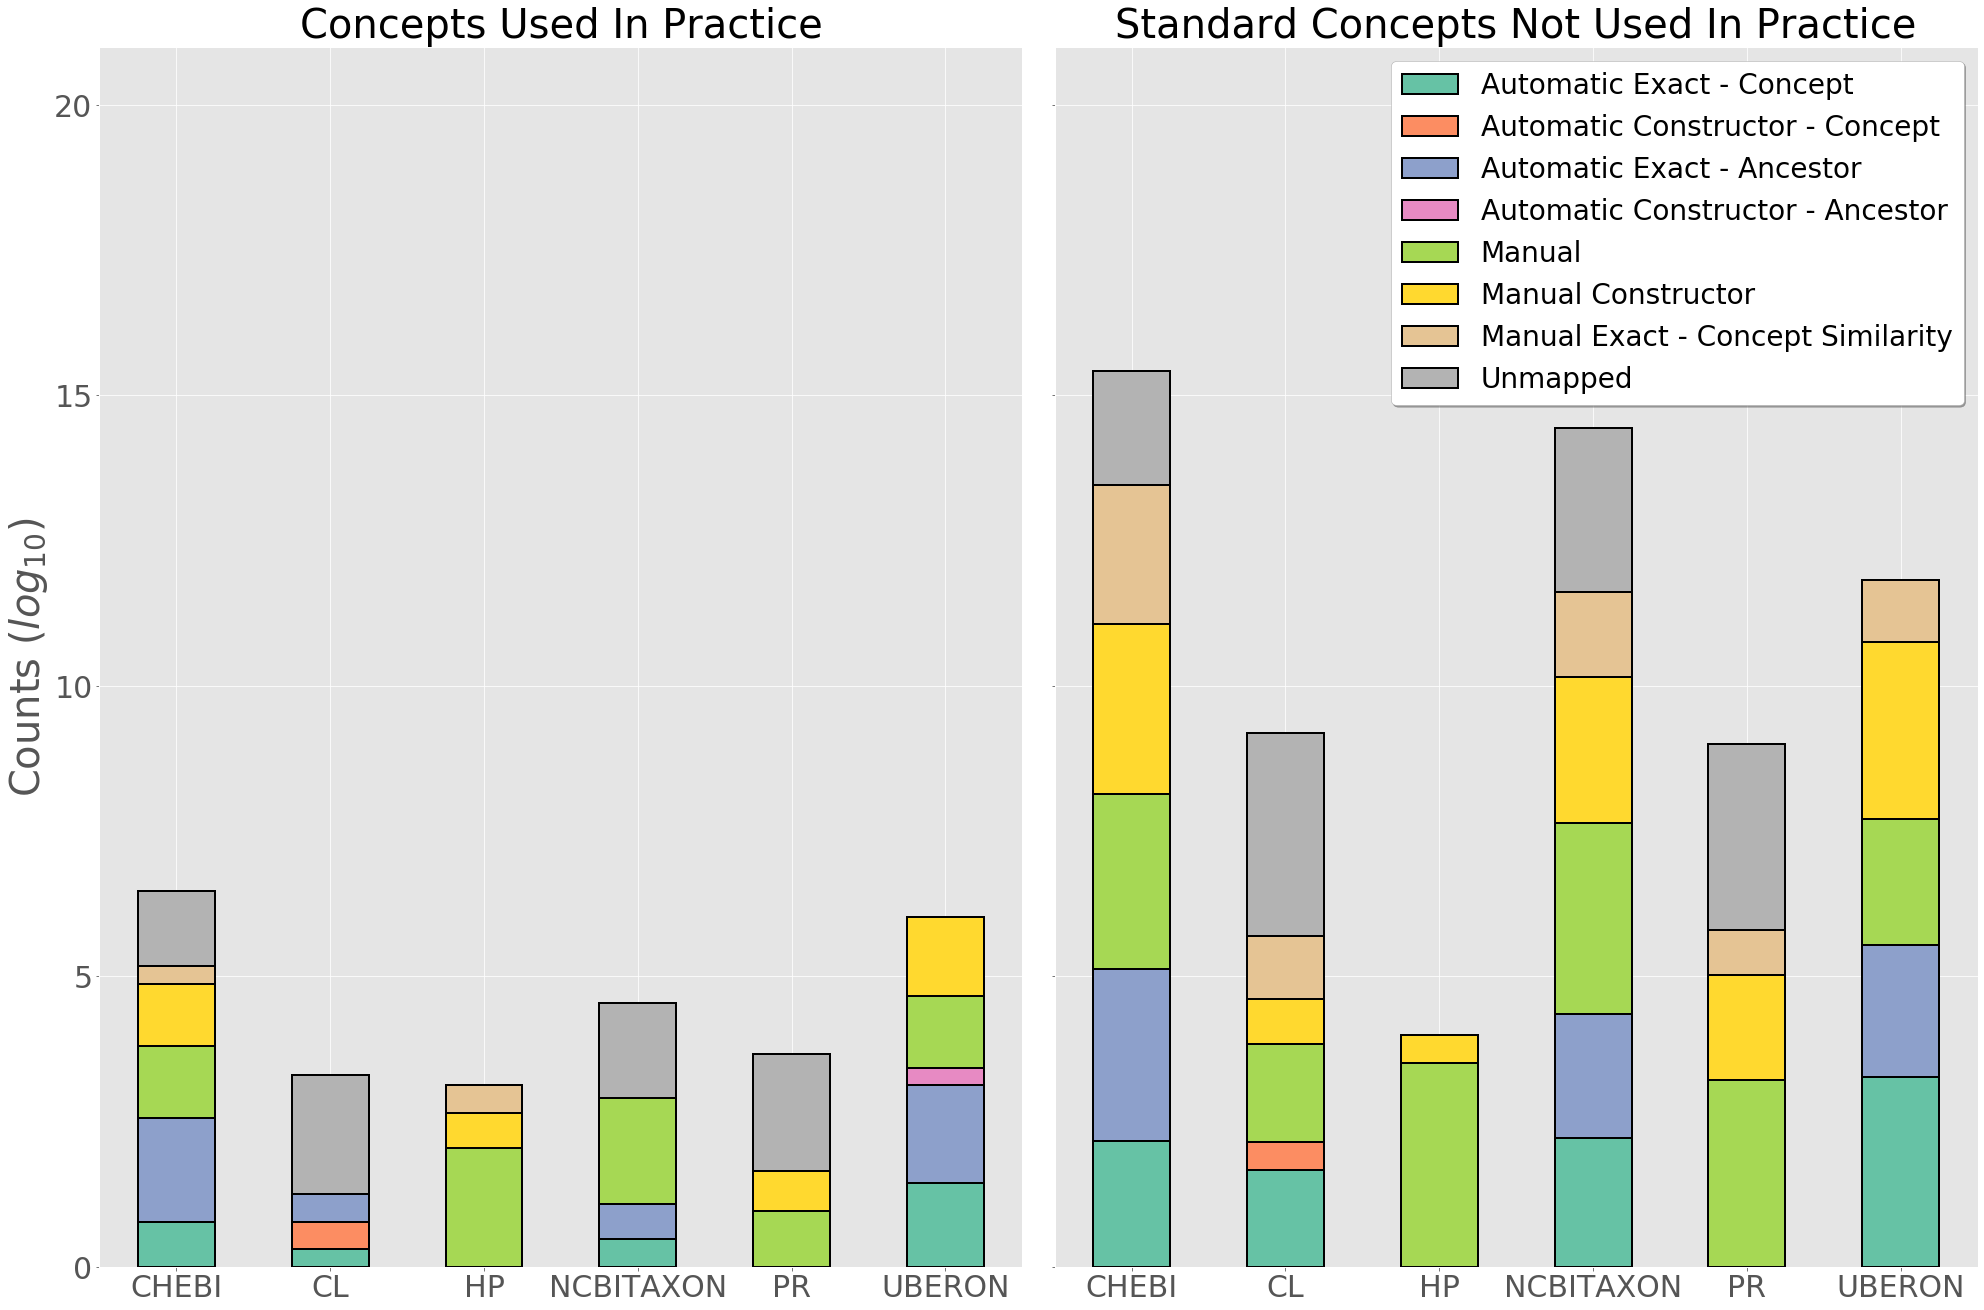

In [190]:
# create plot data
plots = {'Concepts Used In Practice': omop2obo_lab_prac_data,
         'Standard Concepts Not Used In Practice': omop2obo_lab_stnd_data}

ordering = ['Automatic Exact - Concept', 'Automatic Constructor - Concept',
           'Automatic Exact - Ancestor', 'Automatic Constructor - Ancestor',
            'Manual', 'Manual Constructor', 'Manual Exact - Concept Similarity', 'Unmapped']

# create plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 18))
scale_min, scale_max, scale_step = 0, 21, 5 
xlabel, ylabel = '', 'Counts ($log_{10}$)'
for df, ax in zip(plots.keys(), axes):
    plt_data = plots[df].pivot(index='ontology', columns='mapping_category', values='counts')
    plt_data = plt_data.reindex(ordering, axis=1)
    ax = plt_data.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', linewidth=2, colormap='Set2')
    ax.set_title(df, fontsize=40, alpha=1.0)
    ax.set_ylabel(ylabel, fontsize=40),
    ax.set_xlabel(xlabel, fontsize=40),
    ax.set_ylim(scale_min, scale_max)
    ax.set_yticks(range(scale_min, scale_max, scale_step))
    ax.set_yticklabels(labels=range(scale_min, scale_max, scale_step), rotation=0, minor=False, fontsize=30)
    ax.set_xticklabels(labels=list(plt_data.index), rotation=0, minor=False, fontsize=30)
    handles, labels = ax.get_legend_handles_labels()

# facet into single plot
plt.tight_layout(pad=0.0, w_pad=-6.5, h_pad=0.0)
axes[1].set_ylabel("")
axes[1].set_yticklabels("")
axes[0].legend().set_visible(False)
axes[1].legend(ordering, fontsize=28, shadow=True, facecolor='white', edgecolor='darkgray', ncol=1)

plt.show()

ERROR ANALYSIS   
The goal of the error analysis was to try and explain the `OMOP2OBO` concepts that were not found in the `Concept Prevalence` data. For this analysis, we group the `20,893` OMOP concepts not covered by the `OMOP2OBO` mapping set into three groups:  
1. **Error Analysis Concepts:** missing concepts found in a current version of the `OMOP` Common Data Model  
2. **Excluded Concepts:** missing concepts that are in the original mapping data, but were excluded from the final mapping set (see [here](#coverage-labs) for more details)  
3. **Truly Missing Concepts:** missing concepts that cannot be explained by other data sources.

In [192]:
# 20,893 total concepts in CP not included in OMOP2OBO
lab_error_analysis = process_error_analysis_data(error_analysis, only_cp_lab_concepts, lab_mappings,
                                                  lab_mappings_standard, concept_prev_labs)

# find not covered concepts in error analysis data (n=13)
lab_error_analysis_concepts_data = lab_error_analysis[0]

# find not covered concepts in excluded labition mapping data (n=158)
lab_filtered_concepts_data = lab_error_analysis[1]

# remaining not covered concepts (n=20,722)
lab_true_not_covered_concepts_data = lab_error_analysis[2]

# print the results
print('Of the {} concepts not covered by OMOP2OBO:\n  - {} are in the Error Analysis data\n  - {} are in the excluded labition map set data\n  - {} are truly not covered'.format(len(only_cp_lab_concepts),
                                                                                                                                                                                   len(set(lab_error_analysis_concepts_data['TARGET_CONCEPT_ID'])),
                                                                                                                                                                                   len(set(lab_filtered_concepts_data['CONCEPT_ID'])),
                                                                                                                                                                                   len(set(lab_true_not_covered_concepts_data['CONCEPT_ID']))))

Of the 20893 concepts not covered by OMOP2OBO:
  - 13 are in the Error Analysis data
  - 158 are in the excluded labition map set data
  - 20722 are truly not covered


In [193]:
# convert data frames into dictionaries
# create a list of databases
lab_dbs = [concept_prev_labs, lab_mappings, lab_mappings_standard]

# find not covered concepts in error analysis data (n=13)
lab_error_analysis_dict = classifies_missing_concepts(lab_error_analysis_concepts_data, measurement_onts, 'TARGET_CONCEPT_ID', 'error', lab_dbs)

# find not covered concepts in excluded labition mapping data (n=158)
lab_filtered_concepts_dict = classifies_missing_concepts(lab_filtered_concepts_data, measurement_onts, 'CONCEPT_ID', 'excluded', lab_dbs)

# remaining not covered concepts (n=20,722)
lab_tp_not_covered_dict = classifies_missing_concepts(lab_true_not_covered_concepts_data, measurement_onts, 'CONCEPT_ID', 'missing', lab_dbs)


100%|██████████| 20722/20722 [01:51<00:00, 185.05it/s]


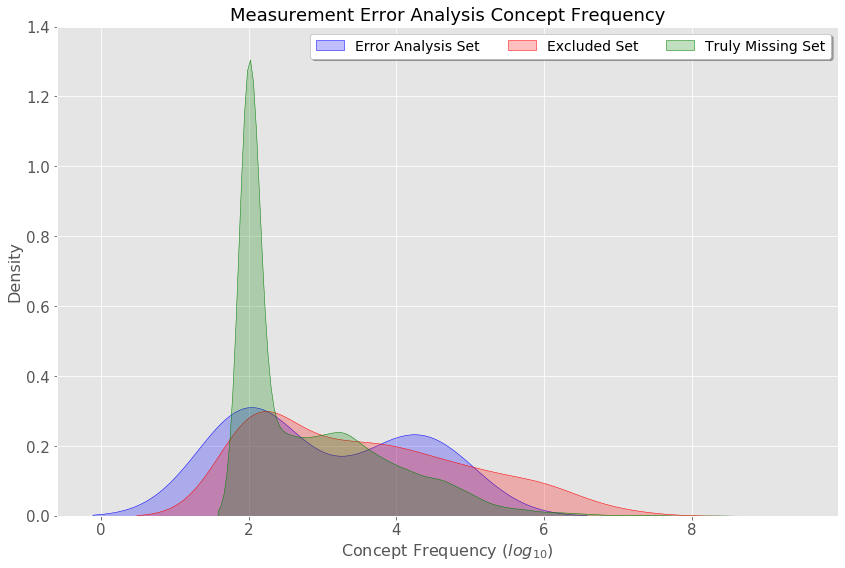

In [194]:
# process count data
lab_error_analysis_counts = [statistics.mean(lab_error_analysis_dict['error'][x]['counts']) for x in lab_error_analysis_dict['error'].keys()]
lab_filtered_counts = [statistics.mean(lab_filtered_concepts_dict['excluded'][x]['counts']) for x in lab_filtered_concepts_dict['excluded'].keys()]
lab_missing_counts = [statistics.mean(lab_tp_not_covered_dict['missing'][x]['counts']) for x in lab_tp_not_covered_dict['missing'].keys()]

# create plot data
plt_data = pd.DataFrame({'set':['Error Analysis Set'] * len(lab_error_analysis_counts) + ['Excluded Set'] * len(lab_filtered_counts) + ['Truly Missing Set'] * len(lab_missing_counts),
                        'counts': np.log10(lab_error_analysis_counts).tolist() + np.log10(lab_filtered_counts).tolist() + np.log10(lab_missing_counts).tolist()})

# create histograms
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
y = sns.kdeplot(np.log10(lab_error_analysis_counts).tolist(), color='blue', label='Error Analysis Set', shade=True)
y = sns.kdeplot(np.log10(lab_filtered_counts).tolist(), color='red', label='Excluded Set', shade=True)
y = sns.kdeplot(np.log10(lab_missing_counts).tolist(), color='green', label='Truly Missing Set', shade=True)

plt.title('Measurement Error Analysis Concept Frequency', fontsize=18)
plt.suptitle('')
plt.xlabel('Concept Frequency ($log_{10}$)', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.ylim(0.0, 1.4)
plt.tick_params(labelsize=15)
plt.legend(title='', fontsize=14, title_fontsize=14, shadow=True, facecolor='white', edgecolor='darkgray', ncol=3)
plt.show()

***Error Analysis Concepts***

In [195]:
# get counts of error analysis types (i.e. newly added concept or replaced concept)
source_concepts, relationship_types = [], []
for x in lab_error_analysis_dict['error'].keys():
    for y in lab_error_analysis_dict['error'][x]['evidence'].keys():
        if y != 'master_evidence':
            source_concepts.append(y)
            relationship_types.append(lab_error_analysis_dict['error'][x]['evidence'][y]['relation']) 

# get counts of relationship ids
lab_error_analysis_types = Counter(relationship_types)

print('The {} missing concepts account can be mapped to {} source concepts using the following relations:'.format(len(lab_error_analysis_dict['error'].keys()),
                                                                                                                 len(source_concepts)))
print('  - ' + '\n  - '.join(['{}: {}'.format(x[0], x[1]) for x in lab_error_analysis_types.items()]))

The 13 missing concepts account can be mapped to 13 source concepts using the following relations:
  - Concept replaced by: 11
  - Maps to: 2


In [196]:
lab_error_analysis_dbs = [lab_error_analysis_dict['error'][x]['dbs'] for x in lab_error_analysis_dict['error'].keys()]
lab_error_analysis_count = [statistics.mean(lab_error_analysis_dict['error'][x]['counts']) for x in lab_error_analysis_dict['error'].keys()]

print('Database site concept occurrence: {} min, {} mean, {} max'.format(min(lab_error_analysis_dbs), round(statistics.mean(lab_error_analysis_dbs), 3), max(lab_error_analysis_dbs)))
print('Concept Frequency information: {} min, {} mean, {} max'.format(min(lab_error_analysis_count), round(statistics.mean(lab_error_analysis_count), 3), max(lab_error_analysis_count)))

Database site concept occurrence: 1 min, 3.231 mean, 5 max
Concept Frequency information: 100 min, 9836.254 mean, 29098.2 max


***Excluded Concepts***

In [197]:
lab_evidence_types = [lab_filtered_concepts_dict['excluded'][x]['evidence'] for x in lab_filtered_concepts_dict['excluded'].keys()]

lab_evidence_type_list = []
for x in lab_evidence_types:
    key = [i for i in x.keys() if i != 'master_evidence']
    for y in key:
        lab_evidence_type_list.append(tuple(x[y]['evidence']))

# get counts of each tye of evidence        
lab_evidence = Counter(lab_evidence_type_list)

print('Of the {} missing variables found in the excluded data frame:\n  - {}'.format(len(lab_filtered_concepts_dict['excluded'].keys()),
                                                                                     '\n  - '.join([str(x[1]) + ' ' + '-'.join(x[0]) for x in lab_evidence.items()])))

Of the 158 missing variables found in the excluded data frame:
  - 76 HP:UNSPECIFIED SAMPLE-CHEBI:UNSPECIFIED SAMPLE-CL:UNSPECIFIED SAMPLE-UBERON:UNSPECIFIED SAMPLE-PR:UNSPECIFIED SAMPLE-NCBITAXON:UNSPECIFIED SAMPLE
  - 79 HP:NOT MAPPED TEST TYPE-CHEBI:NOT MAPPED TEST TYPE-CL:NOT MAPPED TEST TYPE-UBERON:NOT MAPPED TEST TYPE-PR:NOT MAPPED TEST TYPE-NCBITAXON:NOT MAPPED TEST TYPE
  - 3 HP:NONE-CHEBI:NONE-CL:NONE-UBERON:NONE-PR:NONE-NCBITAXON:NONE


In [198]:
lab_excluded_analysis_dbs = [lab_filtered_concepts_dict['excluded'][x]['dbs'] for x in lab_filtered_concepts_dict['excluded'].keys()]
lab_excluded_analysis_count = [statistics.mean(lab_filtered_concepts_dict['excluded'][x]['counts']) for x in lab_filtered_concepts_dict['excluded'].keys()]

print('Database site concept occurrence: {} min, {} mean, {} max'.format(min(lab_excluded_analysis_dbs), statistics.mean(lab_excluded_analysis_dbs), max(lab_excluded_analysis_dbs)))
print('Concept Frequency information: {} min, {} mean, {} max'.format(min(lab_excluded_analysis_count), statistics.mean(lab_excluded_analysis_count), max(lab_excluded_analysis_count)))

Database site concept occurrence: 1 min, 5.1835443037974684 mean, 11 max
Concept Frequency information: 100 min, 282115.28211249015 mean, 14317951.9 max


***Truly Missing Concepts***

In [199]:
# freq_dict = {tp_not_covered_dict['missing'][x]['avg_count']: str(x) + ':' + tp_not_covered_dict['missing'][x]['evidence'] for x in tp_not_covered_dict['missing'].keys()}
counts, dbs, concepts = [], [], []
for x in lab_tp_not_covered_dict['missing'].keys():
    for y in lab_tp_not_covered_dict['missing'][x]:
        for z in lab_tp_not_covered_dict['missing'][x]['evidence'].keys():
            if z != 'master_evidence':
                counts.append(statistics.mean(lab_tp_not_covered_dict['missing'][x]['counts']))
                dbs.append(lab_tp_not_covered_dict['missing'][x]['dbs'])
                concepts.append(str(x) + ': ' + lab_tp_not_covered_dict['missing'][x]['evidence'][z]['evidence'])

# create Pandas DataFrame
lab_truly_mising_df = pd.DataFrame({'Concept Frequency': counts, 'Database Count': dbs, 'Concept': concepts})
                
# print missing concepts sorted descending by concept frequency
lab_truly_mising_df = lab_truly_mising_df.sort_values(['Concept Frequency', 'Database Count'], ascending=False).drop_duplicates()
lab_truly_mising_df.head(n=20)


,Concept Frequency,Database Count,Concept
58284,1219846862.000,1,3045980: Pulse intensity of Unspecified artery...
14064,253609945.000,1,3021716: Penicillin G potassium [Mass] of Dose
53226,246641311.000,1,40760098: Sodium [Moles/volume] in Saliva (ora...
57834,246063202.000,1,3045820: Cotinine/Creatinine [Mass Ratio] in U...
45510,234931483.000,1,3008500: Chloride [Moles/volume] in Saliva (or...
41727,207048040.000,1,3039417: Platelet distribution width [Ratio] i...
56664,200025193.500,2,43055141: Pain severity - 0-10 verbal numeric ...
13422,138601067.000,1,3021222: Alkaline phosphatase.renal/Alkaline p...
43038,125346176.000,2,3040084: Epidermal growth factor receptor Ag [...
27954,116463261.500,2,3032710: Calcium.ionized/Calcium.total correct...


In [200]:
# print missing concepts sorted descending by number of databases with the concept
lab_truly_mising_df = lab_truly_mising_df.sort_values(['Database Count', 'Concept Frequency'], ascending=False)
lab_truly_mising_df.head(n=20)

,Concept Frequency,Database Count,Concept
40014,45324011.357,14,3038553: Body mass index (BMI) [Ratio]
59688,61103.583,12,3013731: Hepatitis B virus surface Ab [Units/v...
21015,27697056.455,11,3026361: Erythrocytes [#/volume] in Blood
48123,969948.500,10,"3009609: Carbon dioxide, total [Moles/volume] ..."
5796,659179.400,10,3017143: Hepatitis C virus Ab [Presence] in Serum
53964,51833.500,10,3011630: Helicobacter pylori [Presence] in Sto...
32034,36636.500,10,3001951: Fetal Crown Rump length US
50688,27986.800,10,3010503: CD19 cells [#/volume] in Blood
2616,27091.900,10,3048446: Mycobacterium tuberculosis tuberculin...
2445,20727.000,10,3015579: Color of Body fluid


In [201]:
lab_tp_analysis_dbs = [lab_tp_not_covered_dict['missing'][x]['dbs'] for x in lab_tp_not_covered_dict['missing'].keys()]
lab_tp_analysis_count = [statistics.mean(lab_tp_not_covered_dict['missing'][x]['counts']) for x in lab_tp_not_covered_dict['missing'].keys()]

print('Database site concept occurrence: {} min, {} mean, {} max'.format(min(lab_tp_analysis_dbs), statistics.mean(lab_tp_analysis_dbs), max(lab_tp_analysis_dbs)))
print('Concept Frequency information: {} min, {} mean, {} max'.format(min(lab_tp_analysis_count), statistics.mean(lab_tp_analysis_count), max(lab_tp_analysis_count)))

Database site concept occurrence: 1 min, 2.81613743847119 mean, 14 max
Concept Frequency information: 100 min, 218874.027722941 mean, 1219846862 max


#### DATA SITE COVERAGE<a class="anchor" id="lab-data-site-coverage"></a>    
This phase of the experiment aimed to demonstrate the coverage of the `OMOP2OBO` condition occurrence concepts for each `Concept Prevalence` study site. Across the `Concept Prevalence` study sites, coverage ranged from `4.22-75.00%`. A Chi-Square test of independence was run to determine if coverage available differed by database. First, an omnibus test was run to determine whether there was a significant relationship between database and coverage. Results from this test (with Yate's correction) revealed a significant association between the database and coverage ($X^{2}(17)=3,872.327$, $p<0.0001$). In order to better understand these findings, post-hoc tests were run using a Bonferroni adjustment to correct for multiple comparisons. These tests confirmed that `93` of the `153` database comparisons had significantly different coverage ($ps<0.001$).

In [202]:
# Get concept coverage by database
labs_coverage_dict = gets_group_stats(concept_prev_labs.copy(), lab_mappings_standard.copy(), 'DATABASE_NAME', 'CONCEPT_ID')

# create contingency table
dbs = list(labs_coverage_dict.keys())
db_covered = [len(labs_coverage_dict[j]['overlap'].keys()) for j in dbs]
db_not_covered = [len(labs_coverage_dict[j]['primary_only'].keys()) for j in dbs]

# convert to Pandas DataFrame
labs_coverage_df = pd.DataFrame({'Database': dbs, 'Covered': db_covered, 'Not Covered': db_not_covered})

# calculate coverage 
labs_coverage_df['% Coverage'] = round(labs_coverage_df['Covered']/(labs_coverage_df['Covered'] + labs_coverage_df['Not Covered'])*100, 3)

# view table
labs_coverage_df.sort_values('% Coverage', ascending=False)

100%|██████████| 18/18 [00:00<00:00, 150.63it/s]

Processing 18 Database groups



,Database,Covered,Not Covered,% Coverage
6,JMDC,15,5,75.000
14,Stanford,177,102,63.441
8,NHIS_Korea,8,6,57.143
2,DA_France,5,5,50.000
1,Australia_JJ,227,241,48.504
13,Pscanner,584,714,44.992
7,MIMIC3_CDM,290,379,43.348
15,UCHealth,1002,1768,36.173
16,ePBRN_OMOP_CDM53_V3a_NOV_2017,434,854,33.696
17,ohdsi_cumc_deid_2018q4,1301,2692,32.582


***Plot Coverage by Concept Prevalence Study Site***

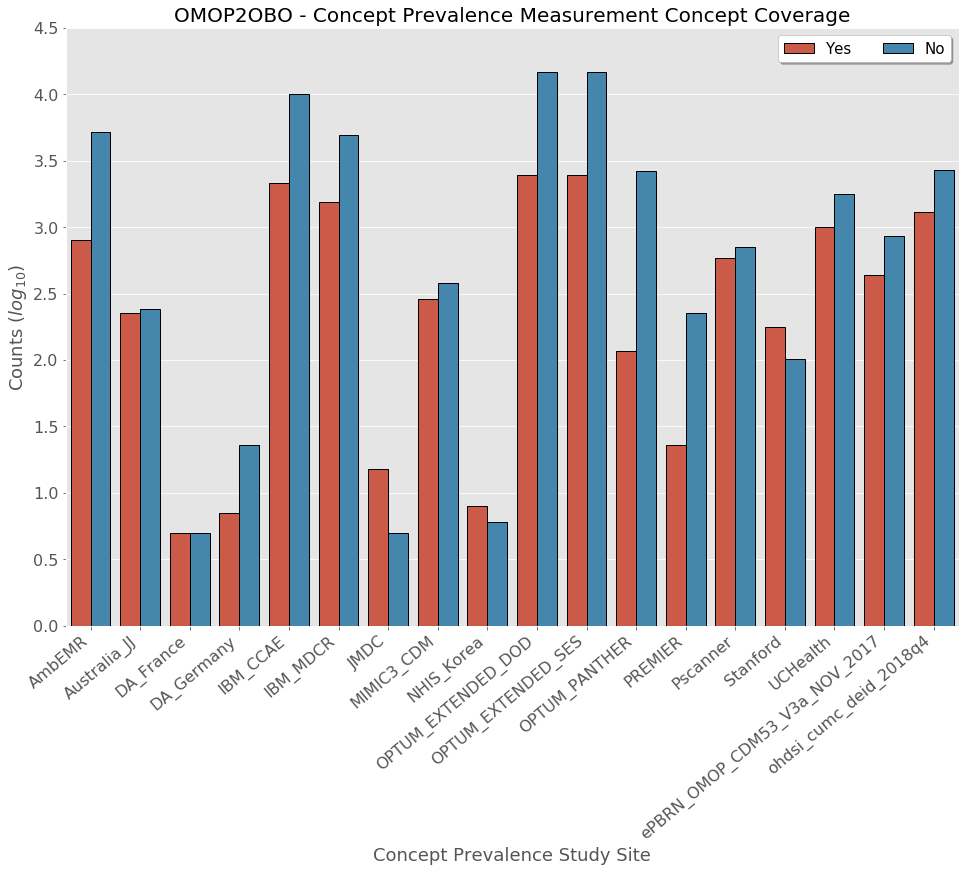

In [203]:
# create plotting data
db_names = dbs * 2
db_coverage = ['Yes'] * len(db_covered) + ['No'] * len(db_not_covered)
db_coverage_counts = np.log10(db_covered + db_not_covered).tolist()

# convert to Pandas DataFrame
conds_cov_df = pd.DataFrame({'Database': db_names, 'Coverage': db_coverage, 'Counts': db_coverage_counts})

# generate bar plot
fig, ax = plt.subplots(1, 1, figsize=(16, 11))

g = sns.barplot(data=conds_cov_df, x='Database', y='Counts', hue="Coverage", edgecolor='black', linewidth=1)
# g = sns.barplot(data=ontology_counts, x='ontology', y='counts', hue="metadata",
#                 palette=sns.color_palette('gray', 4), edgecolor='black', linewidth=1)
g.set_xticklabels(g.get_xticklabels(), rotation=40, horizontalalignment='right')

# set plot label information
plt.ylim(0, 4.5)
plt.title('OMOP2OBO - Concept Prevalence Measurement Concept Coverage', fontsize=20)
plt.xlabel('Concept Prevalence Study Site', fontsize=18)
plt.ylabel('Counts ($log_{10}$)', fontsize=18)
plt.tick_params(labelsize=16)
plt.legend(title='', fontsize=15, title_fontsize=14,
           shadow=True, facecolor='white', edgecolor='darkgray', ncol=3)

plt.show()

***Chi-Square Test***  

In [204]:
# reformat data to create contingency table
dbs = list(labs_coverage_dict.keys())
db_names = [[j] * (len(labs_coverage_dict[j]['overlap'].keys()) + len(labs_coverage_dict[j]['primary_only'].keys())) for j in dbs]
res = [['Yes'] * len(labs_coverage_dict[j]['overlap'].keys()) + ['No'] * len(labs_coverage_dict[j]['primary_only'].keys()) for j in dbs]

# create df
df = pd.DataFrame({'database': [x for y in db_names for x in y], 'coverage': [x for y in res for x in y]})

# create cross-tab view
df_cross = pd.crosstab(df['database'], df['coverage'])

# perform post hoc analysis adjusting applying multiple comparisons correction
# other correction types available: https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
result = chisq_and_posthoc_corrected(df_cross, 'bonferroni')

# group results by outcome
chi_res = result.groupby('reject_h0')
chi_diff = chi_res.get_group(True).drop_duplicates()
chi_same = chi_res.get_group(False).drop_duplicates()

Chi-Square Omnibus Test Results: Test statistic: 3872.327068511476, df: 17, p-value: 0.0
Performing post hoc testing using: bonferroni p-value correction method


Create Heatmap to view Study Site Comparisons

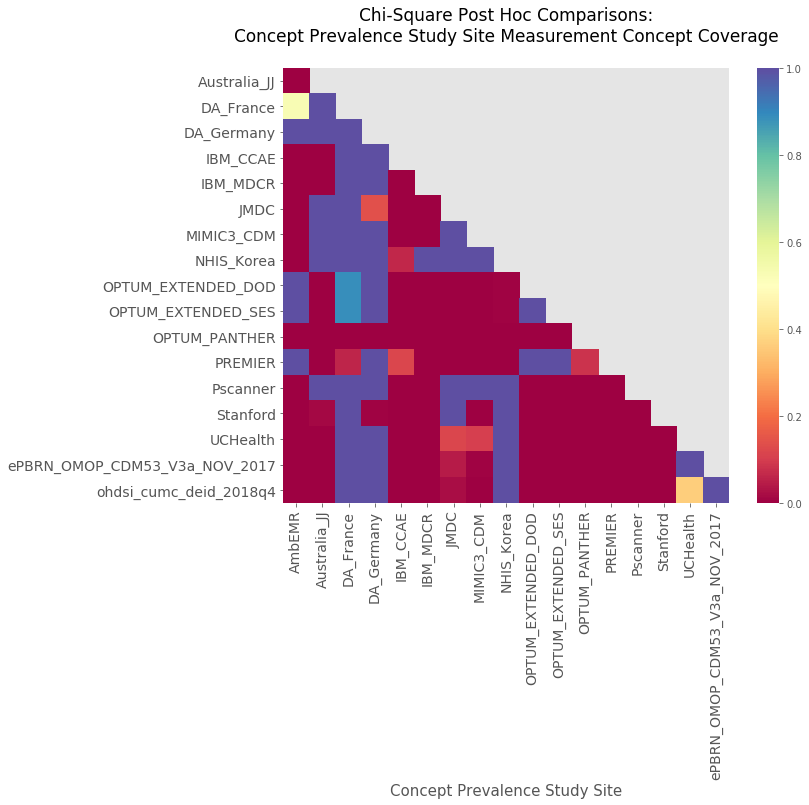

In [205]:
# reformat data and create heat map
result_df = result.copy()

# split comparison column names and add as separate columns
row_names = [x.split('-')[0] for x in list(result_df['comparison'])]
col_names = [x.split('-')[1] for x in list(result_df['comparison'])]
result_df['comparison1'] = row_names
result_df['comparison2'] = col_names

# drop uneeded columns
result_df = result_df.drop(columns=['comparison', 'original_pvalue', 'reject_h0'], axis=1)

# reformat data
res_plot = result_df.pivot(index='comparison2', columns='comparison1', values='corrected_pvalue')

# create heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
g = sns.heatmap(res_plot, annot = False, cmap='Spectral')
# set plot label information
plt.title('Chi-Square Post Hoc Comparisons:\nConcept Prevalence Study Site Measurement Concept Coverage\n', fontsize=17)
plt.xlabel('Concept Prevalence Study Site', fontsize=15)
plt.ylabel('', fontsize=18)
plt.tick_params(labelsize=14)

plt.show()

***OMOP2OBO Overlap Concept Frequency***  
This section examines the frequency of concepts that occurs in both the `OMOP2OBO` map and the `Concept Prevalence` study sites.

In [206]:
# get range of concept frequency for codes in omop2obo and cp
both_covered, both_plt = [], []

for grp in labs_coverage_dict.keys(): 
    overlap = labs_coverage_dict[grp]['overlap'].values()    
    both_covered.append([grp, min(overlap), max(overlap), statistics.median(overlap)])
    both_plt.append([[grp] * len(overlap), overlap])

# create pandas df
lab_covered = pd.DataFrame({'database': [x[0] for x in both_covered],
                            'min_freq': [x[1] for x in both_covered],
                            'max_freq': [x[2] for x in both_covered],
                            'median_freq': [x[3] for x in both_covered]})

In [207]:
lab_covered.sort_values(['median_freq', 'max_freq'], ascending=False)


,database,min_freq,max_freq,median_freq
6,JMDC,9960973,9960973,9960973.000
3,DA_Germany,5443273,14691654,7458619.000
12,PREMIER,100,1223651553,3545365.000
8,NHIS_Korea,1039468,2209462,2208709.000
14,Stanford,1548,11114638,180353.000
2,DA_France,2186,7103774,27517.000
0,AmbEMR,100,79740170,8629.500
11,OPTUM_PANTHER,100,1465815430,8480.500
1,Australia_JJ,100,821322,7408.000
7,MIMIC3_CDM,100,9933578,4129.000


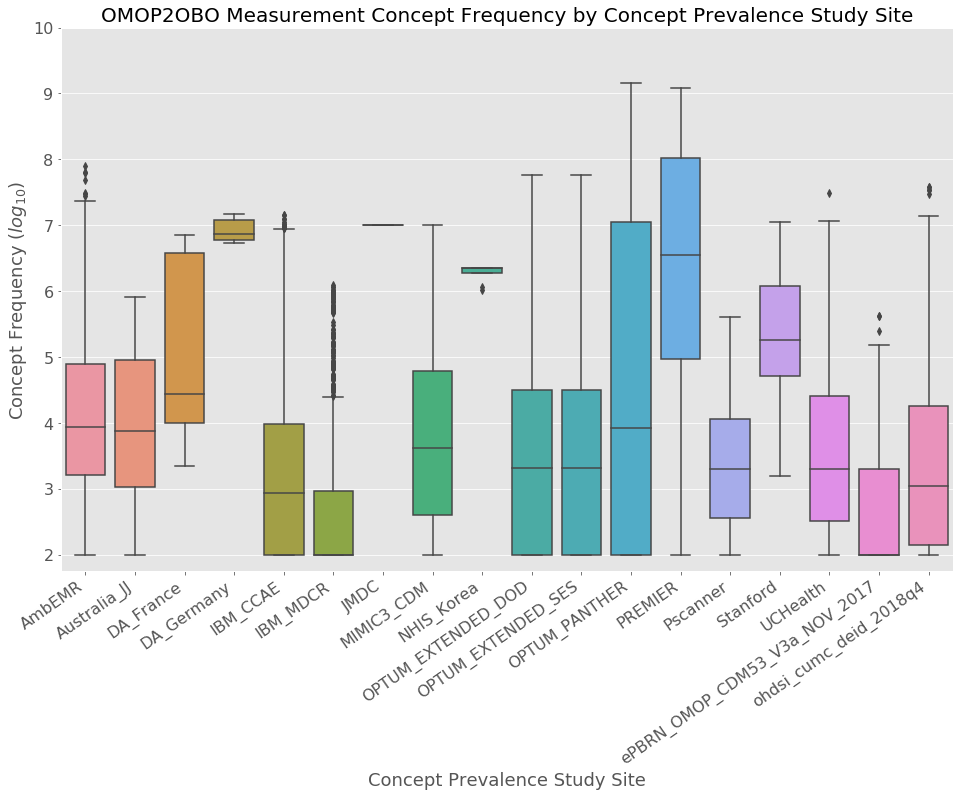

In [208]:
# create plot data
overlap_covered = pd.DataFrame({'database': [x for y in both_plt for x in y[0]],
                                'concept_frequency': [math.log10(x) for y in both_plt for x in y[1]]})

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
sboxplot = sns.boxplot(y='concept_frequency', x='database', data=overlap_covered)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=35, horizontalalignment='right')
plt.title('OMOP2OBO Measurement Concept Frequency by Concept Prevalence Study Site', fontsize=20)
plt.suptitle("")
plt.xlabel('Concept Prevalence Study Site', fontsize=18)
plt.ylabel('Concept Frequency ($log_{10}$)', fontsize=18)
plt.ylim(1.75, 10)
plt.tick_params(labelsize=16)
plt.show()

***OMOP2OBO Missing Concept Frequency***   
This section examines the frequency of concepts that occur in the `Concept Prevalence` study sites, but not the `OMOP2OBO` map.

In [209]:
# get range of concept frequency for codes not covered by OMOP2OBO
cp_not_covered, cp_not_plt = [], []

for grp in labs_coverage_dict.keys(): 
    # cp not in omop2obo
    cp_not = labs_coverage_dict[grp]['primary_only'].values()    
    cp_not_covered.append([grp, min(cp_not), max(cp_not), statistics.median(cp_not)])
    cp_not_plt.append([[grp] * len(cp_not), cp_not])

# create pandas df
lab_cp_not_covered = pd.DataFrame({'database': [x[0] for x in cp_not_covered],
                                   'min_freq': [x[1] for x in cp_not_covered],
                                   'max_freq': [x[2] for x in cp_not_covered],
                                   'median_freq': [x[3] for x in cp_not_covered]})

In [210]:
# concepts not covered by OMOP2OBO
lab_cp_not_covered.sort_values(['median_freq', 'max_freq'], ascending=False)

# {k: v for k, v in sorted(conds_coverage_dict['OpenClaims']['primary_only'].items(), key=lambda item: item[1], reverse=True)}

,database,min_freq,max_freq,median_freq
6,JMDC,9960973,9960973,9960973.000
3,DA_Germany,169907,12935297,7039112.000
8,NHIS_Korea,1039729,2209514,1263802.000
14,Stanford,124,5748495,47668.500
2,DA_France,154,58106,6717.000
0,AmbEMR,100,119761645,4896.000
15,UCHealth,100,22745979,749.000
7,MIMIC3_CDM,100,6379838,422.000
12,PREMIER,100,138601067,395.000
13,Pscanner,100,350751,365.500


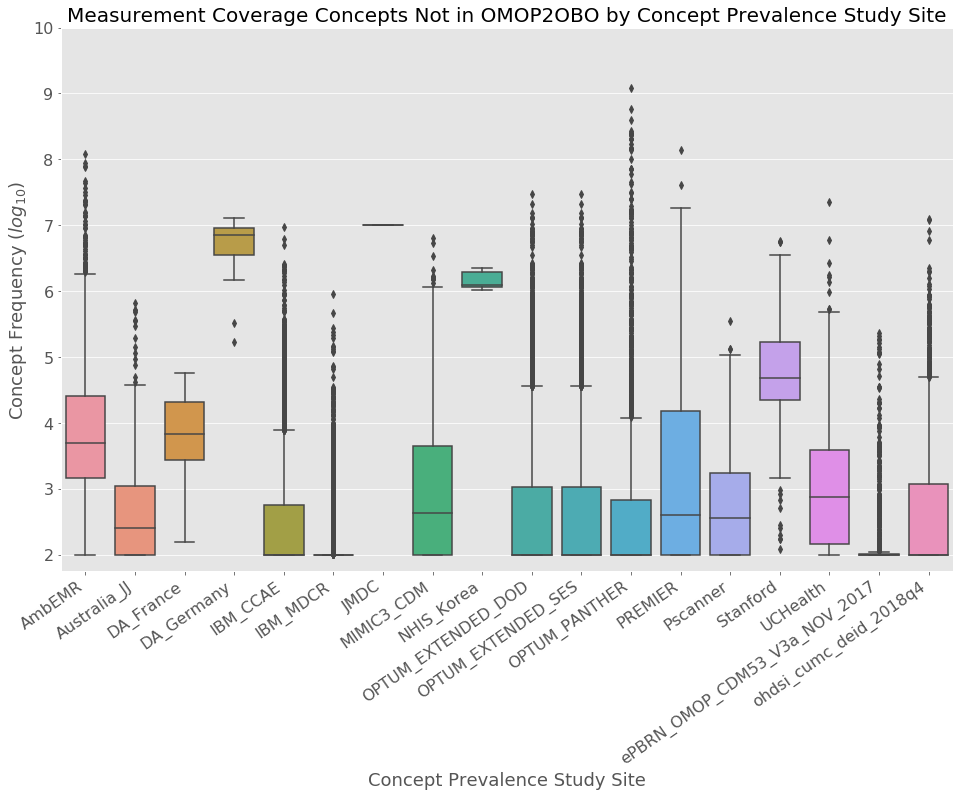

In [211]:
# create plot data
omop_not_lab_plot = pd.DataFrame({'database': [x for y in cp_not_plt for x in y[0]],
                                   'concept_frequency': [math.log10(x) for y in cp_not_plt for x in y[1]]})

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
sboxplot = sns.boxplot(y='concept_frequency', x='database', data=omop_not_lab_plot)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=35, horizontalalignment='right')
plt.title('Measurement Coverage Concepts Not in OMOP2OBO by Concept Prevalence Study Site', fontsize=20)
plt.suptitle("")
plt.xlabel('Concept Prevalence Study Site', fontsize=18)
plt.ylabel('Concept Frequency ($log_{10}$)', fontsize=18)
plt.ylim(1.75, 10)
plt.tick_params(labelsize=16)
plt.show()

***
  
**Click [here](#"coverage-measurements) to return to the Measurements Mapping Validation section**   
**Click [here](#mapping-validation) to return to the Mapping Validation section**  

***

<br>

## Logical Validation <a class="anchor" id="logical-eval"></a>

***
    

***

**Click [here](#mapping-validation) to return to the Mapping Validation section**  

***

***

<br>

This project is licensed under MIT - see the **[`LICENSE.md`](https://github.com/callahantiff/OMOP2OBO/blob/master/LICENSE)** file for details. If you intend to use any of the information on this Wiki, please provide the appropriate attribution by citing this repository:  

```
@misc{callahan_tj_2020_4247939,
  author       = {Callahan, TJ},
  title        = {OMOP2OBO},
  month        = jun,
  year         = 2021,
  doi          = {10.5281/zenodo.4247939},
  url          = {https://doi.org/10.5281/zenodo.4247939}
}
```